### FINM33150 - Quant Trading Strategies
## Homework 5
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: May 6th, 2021

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import seaborn as sns
import quandl
import datetime as dt
import functools
import os
from tqdm import tqdm
import copy
import time
from scipy.stats import norm
import statsmodels.api as sm

quandl_key = os.environ.get('QUANDL_API_KEY') # Works now, might need to reset env or computer to have it work 

In [2]:
plt.style.use('fivethirtyeight')

%matplotlib inline
pd.set_option("precision", 4)

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [5]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities, start, end):
        print("Fetching from Quandl")
        if isinstance(my_securities, str):
            qdata = quandl.get(my_securities, returns="pandas",
                              api_key=quandl_key,
                              start_date=start, end_date=end)
        else:
            qdata = quandl.get(list(my_securities), returns="pandas",
                              api_key=quandl_key,
                              start_date=start, end_date=end)
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


# 1. Data and Cleaning 

In [6]:
start_date =  "1900-01-01"
end_date = "2021-04-30"
df_jp_3m_libor = pd.read_csv("JPY3MTD156N.csv", index_col = "DATE")
df_jp_3m_libor.index = pd.to_datetime(df_jp_3m_libor.index)
df_jp_3m_libor = df_jp_3m_libor.replace('.', np.nan)
df_jp_3m_libor = df_jp_3m_libor.astype(float)
df_jp_3m_libor /= 100
rates = np.where(df_jp_3m_libor.isnull(), df_jp_3m_libor.fillna(method='ffill') + df_jp_3m_libor.fillna(method='bfill')/2, df_jp_3m_libor)
df_jp_3m_libor.JPY3MLibor = rates
df_jp_3m_libor

JPY3MLibor
DATE                  
2009-04-02      0.0059
2009-04-03      0.0059
2009-04-06      0.0059
2009-04-07      0.0058
2009-04-08      0.0058
...                ...
2021-04-19     -0.0007
2021-04-20     -0.0007
2021-04-21     -0.0007
2021-04-22     -0.0007
2021-04-23     -0.0007

[3147 rows x 1 columns]

In [7]:
yield_curves = ("YC/USA", "YC/THA","YC/ROU","YC/JPN", "YC/IDN")
df_yc = []
for yc in yield_curves:
    df_yc.append(fetch_quandl(yc, start_date, end_date))

Fetching from Quandl
Fetching from Quandl
Fetching from Quandl
Fetching from Quandl
Fetching from Quandl


In [8]:
currency_rates = ("CUR/THB", "CUR/RON", "CUR/JPY","CUR/IDR" )
df_fx = []
for fx in currency_rates:
    df_fx.append(fetch_quandl(fx, start_date, end_date))

Fetching from Quandl
Fetching from Quandl
Fetching from Quandl
Fetching from Quandl


In [9]:
def clean_quandl_columns(dataframe, fx = False, borrow = False, yc = False):
    replacement_columns = {}
    for c in dataframe.columns:
        if fx:
            if not borrow:
                replacement_columns[c] = "FX_Rate_Lend"
            else:
                replacement_columns[c] = "FX_Rate_Borrow"
        if yc:
            replacement_columns[c] = c    
        renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data.dropna()
for i in range(len(df_yc)):
    df_yc[i] = clean_quandl_columns(df_yc[i], yc = True)
    if i<4:
        if i == 2:
            df_fx[i] = clean_quandl_columns(df_fx[i], fx = True, borrow = True)
        else:         
            df_fx[i] = clean_quandl_columns(df_fx[i], fx = True)


In [10]:
def compute_zcb_curve(spot_rates_curve):
    """
    Computes zero-coupon bond curbe given for a given spot curve and tenors 
    """
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>=0.5:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [11]:
def create_zcb_df(df):
    """
    Computes the zero-coupon bond rates for every day given the everyday spot rates for different tenors
    """
    original_columns = df.columns 
    new_col = []
    for col in df.columns:
        count, unit = col.split('-')
        if unit[0].lower() == 'm':
            new_col.append(int(count)/12)
        else:
            new_col.append(int(count))
            
    df.columns = new_col
    df = df.T/100
    df = compute_zcb_curve(df).T
    df.columns = original_columns
    return df
    

In [12]:
df_zcb = [] 
for df in df_yc:
    df_zcb.append(create_zcb_df(df))
df_zcb[1].head()

<ipython-input-10-661a95698c77>:14: RuntimeWarning: invalid value encountered in log
  zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor


1-Month  3-Month  6-Month  1-Year  2-Year  3-Year  4-Year  5-Year  \
Date                                                                            
2014-12-01   0.0201   0.0202   0.0201  0.0200  0.0207  0.0208  0.0223  0.0231   
2014-12-02   0.0201   0.0202   0.0201  0.0199  0.0207  0.0207  0.0223  0.0230   
2014-12-03   0.0201   0.0201   0.0200  0.0199  0.0207  0.0207  0.0221  0.0232   
2014-12-04   0.0201   0.0201   0.0200  0.0199  0.0206  0.0208  0.0224  0.0232   
2014-12-05   0.0201   0.0201   0.0200  0.0199  0.0206  0.0208  0.0224  0.0232   

            6-Year  7-Year  8-Year  9-Year  10-Year  15-Year  
Date                                                          
2014-12-01  0.0238  0.0339  0.0270  0.0274   0.0340   0.0327  
2014-12-02  0.0237  0.0339  0.0269  0.0274   0.0340   0.0323  
2014-12-03  0.0238  0.0339  0.0269  0.0276   0.0294   0.0331  
2014-12-04  0.0240  0.0339  0.0270  0.0276   0.0293   0.0330  
2014-12-05  0.0240  0.0339  0.0270  0.0276   0.0293   0.0330

# 2. Analyzing Thai Baht vs 3M Libor JPN Yen Carry Trade

Below we merge all 4 dataframes (FX Borrow, FX Lend, Yield-Curve Borrow, Yield-Curbe Lend). Because each dataframes have different set of indexes, we need to select the index in a way that we have data for all dataframes for that given index. This allows us to maximize the period of trading where we have data for each dataframes.

In [13]:
def index_selection_process(dfs):
    """
    This function iterates through dataframes and grabs the smallest index out of them 
    """
    res = 0 
    for i in range(len(dfs)):
        count = 0
        for j in range(len(dfs)):
            if i != j:
                len_idx_i = len(dfs[i].index)
                len_idx_in_j = dfs[i].index.isin(dfs[j].index).sum()
                if len_idx_i == len_idx_in_j:
                    count +=1 
        # Given that we skip the dataframe index we are testing, the only index that is in all other index
        # will be the index that is in all of them, if another index has this property, then it has the same 
        # indexing and it doesn't change anything for our goal. Any index bigger will not have count = len(dfs) - 1 
        if count == len(dfs)-1:
            return dfs[i].index
    

We'll analyze three different carry trade strategies, 1Y, 3Y and 10Y for Thai. I chose three since for each currencies there are at least 3 different Tenor of 1Y+ to analyze for homogeneity.

In [14]:
dfs_thai = [df_zcb[1]['1-Year'].to_frame(),df_zcb[1]['5-Year'].to_frame(),df_zcb[1]['10-Year'].to_frame()]

In [15]:
def carry_trade_simulation(df_lend_yc, df_borrow_yc, df_lend_fx, df_borrow_fx):
        dfs = [df_lend_yc, df_borrow_yc, df_lend_fx, df_borrow_fx]
        idx = index_selection_process(dfs)
        df_port = df_lend_yc[df_lend_yc.index.isin(idx)]
        for df_temp in dfs[1:]:
            df_temp = df_temp[df_temp.index.isin(idx)]
            df_port = df_port.merge(df_temp, left_index=True, right_index=True)
        df_port = df_port.resample("W-WED").first()
        print("Printing number of null values in dataframe: \n{}".format(df_port.isnull().sum()))
        num_years = int(df_port.columns[0].split('-')[0])
        # Making sure we are only trading when the different in the zcb curbes is more than 50bps
        df_port = df_port[abs(df_port[df_port.columns[0]] - df_port[df_port.columns[1]])>0.005]
        # Value of Bonds at Time of Opening
        df_port['Bond_lend_open'] = np.exp(-df_port[df_port.columns[0]]*num_years)
        df_port['Bond_borrow_open'] = np.exp(-df_port[df_port.columns[1]]*0.25)
        # Notional in Local Currency at the time of trade 
        df_port['Notional_Capital_Borrow'] = 1e7 * df_port.FX_Rate_Borrow
        df_port['Notional_Capital_Lend'] = 1e7 * df_port.FX_Rate_Lend
        # Number of Bonds for each currencies
        df_port['Num_bond_lend_open'] = df_port['Notional_Capital_Lend'] / df_port['Bond_lend_open'] 
        df_port['Num_bond_borrow_open'] = df_port['Notional_Capital_Borrow'] / df_port['Bond_borrow_open'] 
        # Number of days over 360 between trading periods (for simple interest)
        delta_days = (df_port.index.shift(1)-df_port.index).days/360
        # Value of the Bond at time of closing the position 
        df_port['Bond_lend_close'] = np.exp(-df_port[df_port.columns[0]]*(num_years-delta_days))
        df_port['Bond_borrow_close'] = np.exp(-df_port[df_port.columns[1]]*(0.25-delta_days))
        # Notional Value of the currencies in US$ after closing position
        df_port['Notional_lend_US'] = df_port['Num_bond_lend_open'].shift(1) * df_port['Bond_lend_close']/ df_port['FX_Rate_Lend']
        df_port['Notional_borrow_US'] = df_port['Num_bond_borrow_open'].shift(1) * df_port['Bond_borrow_close'] /df_port['FX_Rate_Borrow']
        # THIS IS DIFFERENT THAN WHAT WAS ASKED IN THE HOMEWORK ASSIGNMENT BUT I FELT LIKE IT WAS MORE REALISTIC THUS MORE INTERESTING TO TEST
        # The rest cannot be vectorized since the amount we are borrowing depends on the current capital appreciation since we are always trading for 10MM$ 
        # Instead of always borrow $8MM USD and always trading $10MM USD, it makes more sense to adjust the amount borrow to pay less interest 
        # Although more realistic, it has the disadvantage to not being vectorize anymore
        df_port['Interest'] = 0
        df_port['PnL'] = 0
        df_port['PnL_Accumulated'] = 0
        df_port['Capital'] = 1e7

        for date in df_port.index[1:]:
            yst_date = df_port.index.get_loc(date) - 1
            # We are adjusting the interest not by 7/360 days but actually the numbers of days passed between trades in case the swap rates were less than 50bps of each other 
            df_port['Interest'].loc[date] = (1e7 - df_port.iloc[yst_date]['Capital'] + 8e6)*((0.005+df_port.iloc[yst_date]['JPY3MLibor'])*(df_port.index[yst_date+1]-df_port.index[yst_date]).days/360)
            df_port['Interest_w/out_fund_cost'] = (1e7 - df_port.iloc[yst_date]['Capital'] + 8e6)*((df_port.iloc[yst_date]['JPY3MLibor'])*(df_port.index[yst_date+1]-df_port.index[yst_date]).days/360)
            df_port["PnL"].loc[date] = - df_port.loc[date]['Interest'] + df_port.loc[date]['Notional_lend_US'] - df_port.loc[date]['Notional_borrow_US']
            df_port['Capital'].loc[date] =  df_port.iloc[yst_date]['Capital'] + df_port.loc[date]["PnL"]
        df_port['PnL_Accumulated'] = df_port.PnL.cumsum()
        df_port['Leverage'] = 1e7/(df_port.Capital - 8e6)
        df_port['Net_Capital'] = 1e7/df_port['Leverage']
        df_port['Log_Returns'] = np.log(df_port['Net_Capital']/df_port['Net_Capital'].shift(1))
        # Finds the number of time FX rates went against us on both sides and how many time we still achieved positive PnL
        df_port['Strat_vs_FX'] = np.where((df_port['FX_Rate_Borrow'].diff() < 0) &  (df_port['FX_Rate_Lend'].diff() > 0),1,0)
        df_port['Strat_vs_FX'][(df_port['Strat_vs_FX'] > 0) & (df_port['PnL'] < 0)] = -1
        
        # Finds the number of time FX rates went against us on both sides and how many time we still achieved positive PnL
        df_port['Strat_vs_Bond'] = np.where((df_port['Bond_lend_close'].diff() < 0) &  (df_port['Bond_borrow_close'].diff() > 0),1,0)
        df_port['Strat_vs_Bond'][(df_port['Strat_vs_Bond'] > 0) & (df_port['PnL'] < 0)] = -1
        
        df_port = df_port.fillna(0)
        return df_port

In [16]:
dfs_port_thai = [] 
for i in range(len(dfs_thai)):
    dfs_port_thai.append(carry_trade_simulation(dfs_thai[i], df_jp_3m_libor, df_fx[2], df_fx[0]))
    

Printing number of null values in dataframe: 
1-Year            0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64


C:\Users\laure\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Printing number of null values in dataframe: 
5-Year            0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64
Printing number of null values in dataframe: 
10-Year           0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64


## 2.1 Bond Prices Statistics

In [17]:
col_names = ['JPN 3M-ZCBond','Thai 1Yr-ZCBond', 'Thai 5Yr-ZCBond', 'Thai 10Yr-ZCBond']
col_data = ['Bond_borrow_open'] + 3*['Bond_lend_open']

def bond_moments_dataframe(dfs, col_names, col_data):
    stats = pd.DataFrame(data = None, columns = col_names, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
    for i in range(-1,len(dfs)):
        if i == -1:
            data = dfs[0][col_data[0]]
        else:
            data = dfs[i][col_data[i+1]]
        stats[col_names[i+1]].loc['Mean'] = data.mean()
        stats[col_names[i+1]].loc['Median'] = data.median()
        stats[col_names[i+1]].loc['Std Dev'] = data.std()
        stats[col_names[i+1]].loc['1st Quartile'] = data.quantile(0.25)
        stats[col_names[i+1]].loc['3rd Quartile'] = data.quantile(0.75)
        stats[col_names[i+1]].loc['Skew'] = sp.stats.skew(data.dropna())
        stats[col_names[i+1]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
    return stats
bond_moments_dataframe(dfs_port_thai, col_names, col_data)

JPN 3M-ZCBond Thai 1Yr-ZCBond Thai 5Yr-ZCBond Thai 10Yr-ZCBond
Mean                   1.0          0.9849          0.9052           0.7717
Median                 1.0          0.9852          0.9039           0.7652
Std Dev             0.0002          0.0015          0.0111             0.03
1st Quartile        0.9998          0.9849          0.8963            0.752
3rd Quartile        1.0001          0.9857          0.9134           0.7912
Skew               -0.6992         -2.0543          0.3629           0.4568
Kurtosis           -1.0009          3.6298         -0.4363          -0.3175

The Japense 3M Libor Bond evaluation doesn't vary across time as one would expect, it is pretty flat. Interestingly, as the tenor increase, the skew seems to be more and more positive. More importantly, let's look at the 

## 2.2 FX Statistics

In [18]:
col_names = ['JPN/YEN FX','Thai/BAHT FX', 'YEN/BAHT Spread']
col_data = ['FX_Rate_Borrow', 'FX_Rate_Lend']

def fx_moments_dataframe(dfs, col_names, col_data):
    stats = pd.DataFrame(data = None, columns = col_names, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
    
    for i in range(3):
        if i < 2:
            data = dfs[0][col_data[i]]
        else:
            data = dfs[0][col_data[0]]/dfs[0][col_data[1]]
        stats[col_names[i]].loc['Mean'] = data.mean()
        stats[col_names[i]].loc['Median'] = data.median()
        stats[col_names[i]].loc['Std Dev'] = data.std()
        stats[col_names[i]].loc['1st Quartile'] = data.quantile(0.25)
        stats[col_names[i]].loc['3rd Quartile'] = data.quantile(0.75)
        stats[col_names[i]].loc['Skew'] = sp.stats.skew(data.dropna())
        stats[col_names[i]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
    return stats
fx_moments_dataframe(dfs_port_thai, col_names, col_data)

JPN/YEN FX Thai/BAHT FX YEN/BAHT Spread
Mean           113.2879      33.9981          3.3369
Median         112.5266      34.0708          3.3498
Std Dev          6.0094       1.4266          0.2068
1st Quartile   109.4949      32.8256          3.2166
3rd Quartile   119.0407      35.2307          3.4542
Skew             0.0033      -0.2194         -0.2551
Kurtosis        -0.7076      -1.1283         -0.4436

Nothing too distinguishable once normalized between the two currency and the relative spread between them. 

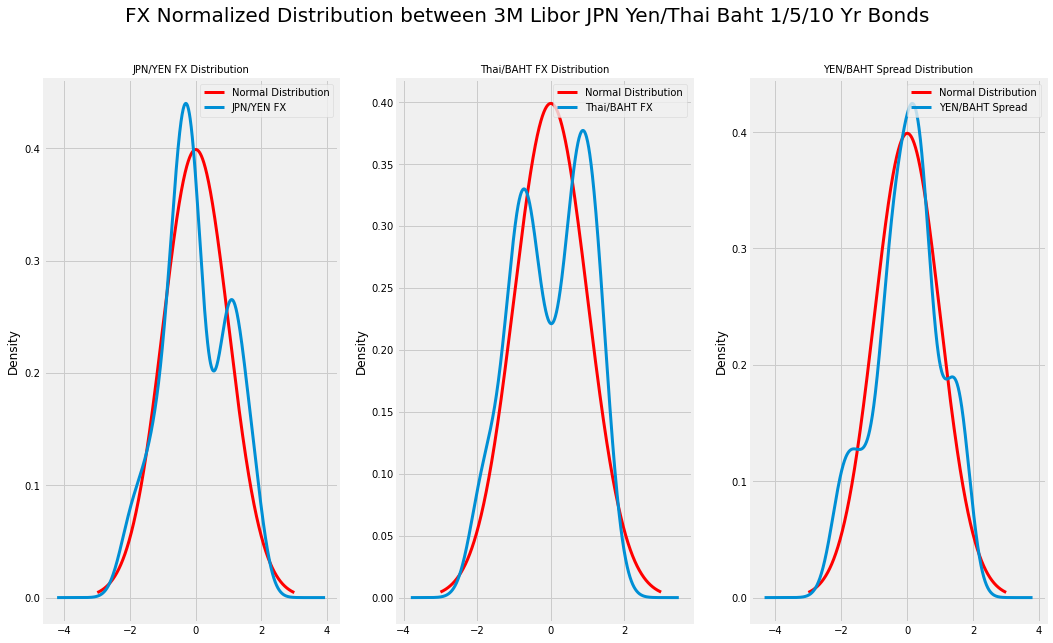

In [19]:
def fx_distribution_plot(dfs, col_names, col_data, title):
    n_x = np.arange(-3,3,0.001)
    y = pd.Series(norm.pdf(n_x,0,1), index = n_x, name = 'Normal Distribution')
    fig, axs = plt.subplots(1,3,figsize=(16,10))
    plt.style.use('fivethirtyeight')
    fig.suptitle(title, fontsize = 20)
    
    for i in range(3):
        if i < 2:
            data = dfs[0][col_data[i]]
        else:
            data = dfs[0][col_data[0]]/dfs[0][col_data[1]]
        mean = data.mean()
        std = data.std()
        normalize = (data - mean)/std

        axs[i].plot(n_x,y, c= 'r', lw=3, label = 'Normal Distribution')
        axs[i].set_ylabel('Density')
        normalize.plot.kde(ax=axs[i], label = col_names[i], lw=3)
        axs[i].set_title(col_names[i] + " Distribution", fontsize = 10)
        axs[i].legend(loc="upper right", fontsize = 10)
        
    plt.show()
        
fx_distribution_plot(dfs_port_thai, col_names, col_data, 'FX Normalized Distribution between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds')

We can observe that there is a bimodal distribution for both the Japanese Yen and the Thai Baht but that they seem to juxtapose so when taking their spread the effect diminishes. Likely that the FX Rate tends to stay higher for a long time period and tends to stay lower for a long period as well not following a mean-reversing over long period but can exhibit mean-reversing behavior in short-time periods. Say an economic crisis, or an important sector of the economy has been hit or is greatly profiting from the rise of price of a commodity can lead to periods of time that the rates tends to stick to a higher or lower value longer.

## 2.3 Daily Returns

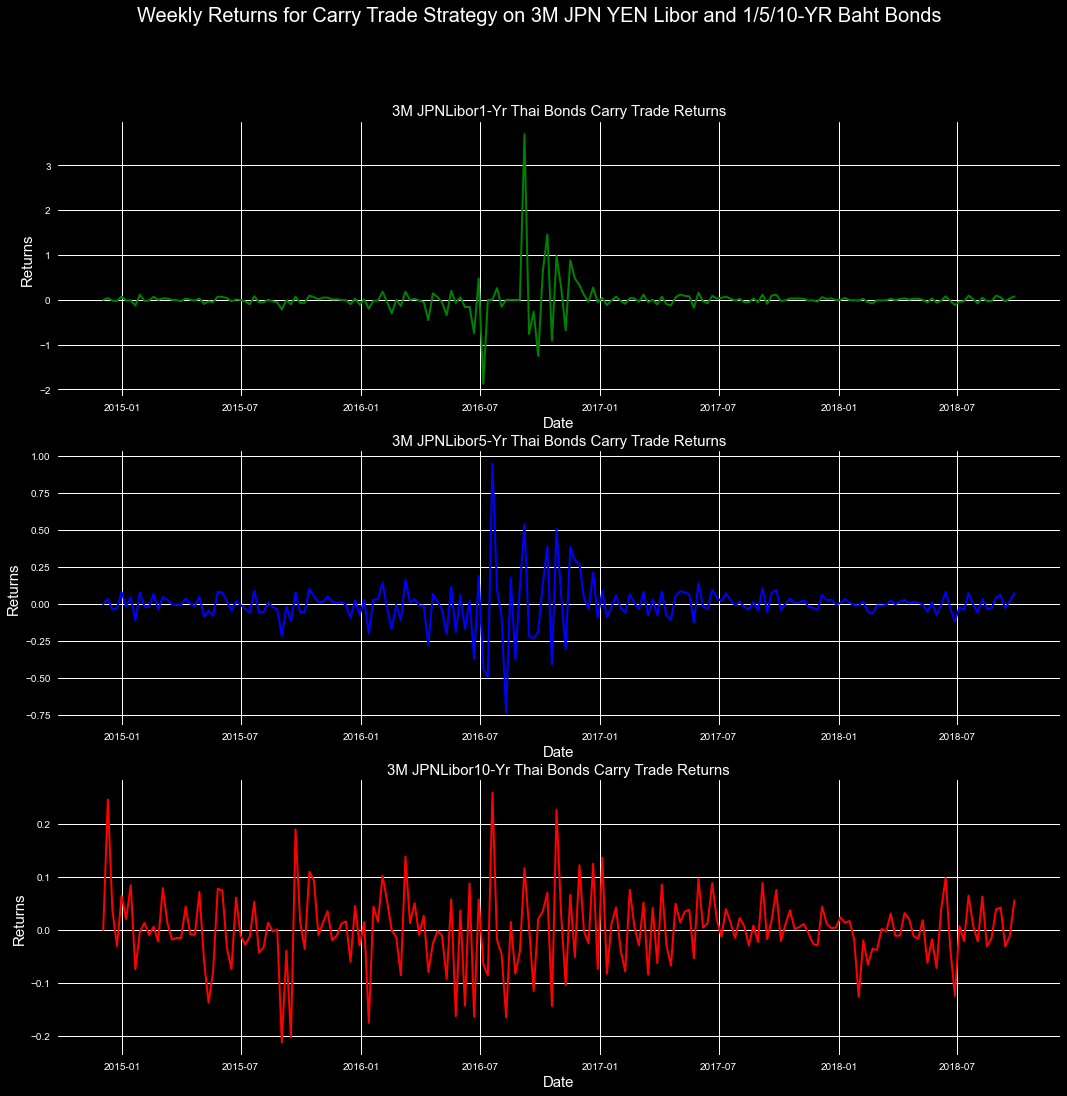

In [95]:
col_names = ["3M JPNLibor"+str(i)+"-Yr Thai Bonds" for i in [1,5,10]]
def daily_returns_carry_trade(dfs, col_names):
    
    fig, axs = plt.subplots(3,1,figsize=(16,16))
    plt.style.use('dark_background')
    fig.suptitle('Weekly Returns for Carry Trade Strategy on 3M JPN YEN Libor and 1/5/10-YR Baht Bonds ', fontsize = 20)
    colors = ['g', 'b', 'r']
    for i in range(3):
        data = dfs[i]['Log_Returns']
        axs[i].plot(data, c=colors[i], lw= 2)
        axs[i].set_title("{} Carry Trade Returns".format(col_names[i]), fontsize = 15)
        axs[i].set_ylabel("Returns", fontsize = 15)
        axs[i].set_xlabel("Date", fontsize = 15)
        
    plt.show()
daily_returns_carry_trade(dfs_port_thai, col_names)

Looking at the y-axis it looks like there was massive deviation from the mean around 2016 for the 1-Yr and 3-Yr Carry trades strategies. The range of values also seems to diminish as the maturity duration of the lending borrow increases. Let's look at the distribution and statistics of the returns. 

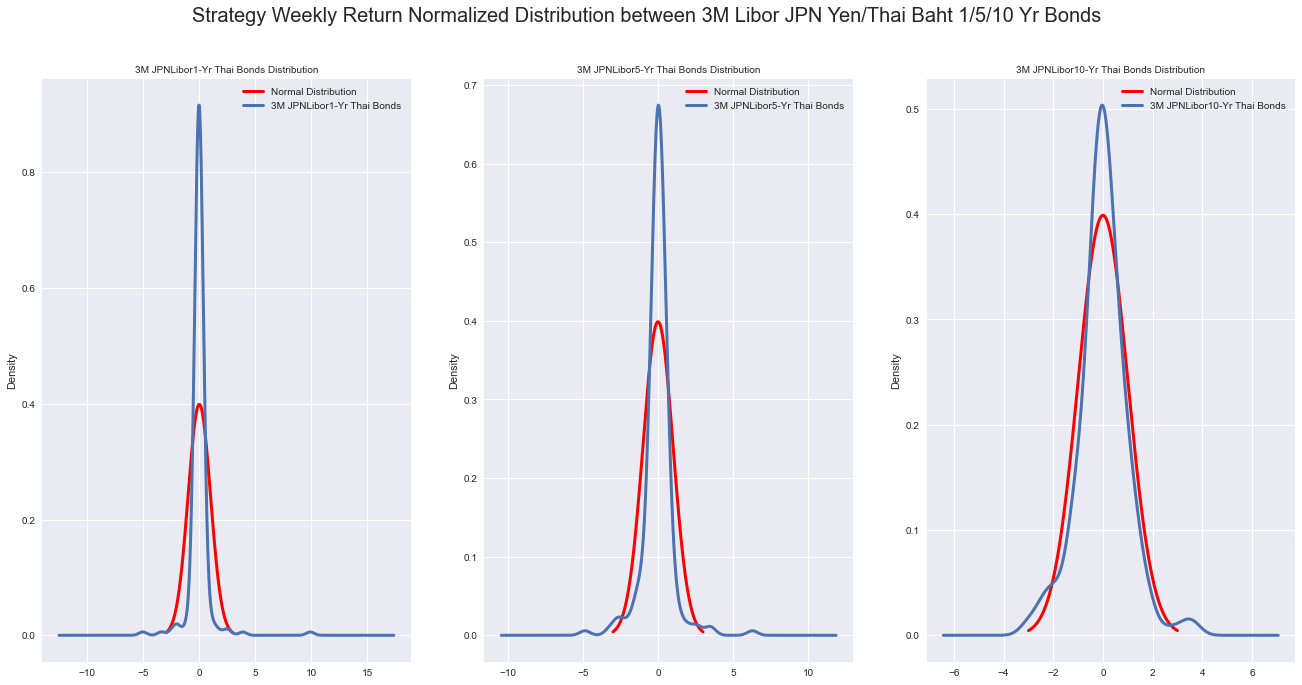

In [97]:
def distribution_plot(dfs, col_names, col):
    n_x = np.arange(-3,3,0.001)
    y = pd.Series(norm.pdf(n_x,0,1), index = n_x, name = 'Normal Distribution')
    fig, axs = plt.subplots(1,3,figsize=(20,10))
    plt.style.use('seaborn')
    fig.suptitle('Strategy Weekly Return Normalized Distribution between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds', fontsize = 20)
    
    for i in range(3):
        data = dfs[i][col]
        mean = data.mean()
        std = data.std()
        normalize = (data - mean)/std

        axs[i].plot(n_x,y, c= 'r', lw=3, label = 'Normal Distribution')
        axs[i].set_ylabel('Density')
        normalize.plot.kde(ax=axs[i], label = col_names[i], lw=3)
        axs[i].set_title(col_names[i] + " Distribution", fontsize = 10)
        axs[i].legend(loc="upper right", fontsize = 10)
        
    plt.show()
distribution_plot(dfs_port_thai, col_names, 'Log_Returns')

The strategy does seem to exhibit kurtosis and the shorter the maturity duration of the bonds is, the higher it seems to be. Let's look at the statistics of the distribution now.

In [22]:
def moments_dataframe(dfs, col_names, col):
    stats = pd.DataFrame(data = None, columns = col_names, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
    for i in range(len(dfs)):
        data = dfs[i][col]
        stats[col_names[i]].loc['Mean'] = data.mean()
        stats[col_names[i]].loc['Median'] = data.median()
        stats[col_names[i]].loc['Std Dev'] = data.std()
        stats[col_names[i]].loc['1st Quartile'] = data.quantile(0.25)
        stats[col_names[i]].loc['3rd Quartile'] = data.quantile(0.75)
        stats[col_names[i]].loc['Skew'] = sp.stats.skew(data.dropna())
        stats[col_names[i]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
    return stats
moments_dataframe(dfs_port_thai, col_names, 'Log_Returns')

3M JPNLibor1-Yr Thai Bonds 3M JPNLibor5-Yr Thai Bonds  \
Mean                             0.0106                     0.0002   
Median                              0.0                     0.0036   
Std Dev                          0.3721                     0.1511   
1st Quartile                    -0.0482                    -0.0395   
3rd Quartile                     0.0437                     0.0484   
Skew                             4.3489                      0.663   
Kurtosis                         51.835                    11.7096   

             3M JPNLibor10-Yr Thai Bonds  
Mean                              0.0013  
Median                            0.0018  
Std Dev                           0.0697  
1st Quartile                     -0.0293  
3rd Quartile                      0.0378  
Skew                              0.1674  
Kurtosis                          2.1329

The kurtosis on the 1-Yr Thai bonds is absurdly high! Even with the 3-Yr Thai bond we have higher kurtosis and positive skew on both. From the Daily Returns graph, it really looks like something happen in 2016 that really blew up the PnL Let's look at it more closely.

## 2.4 PnL

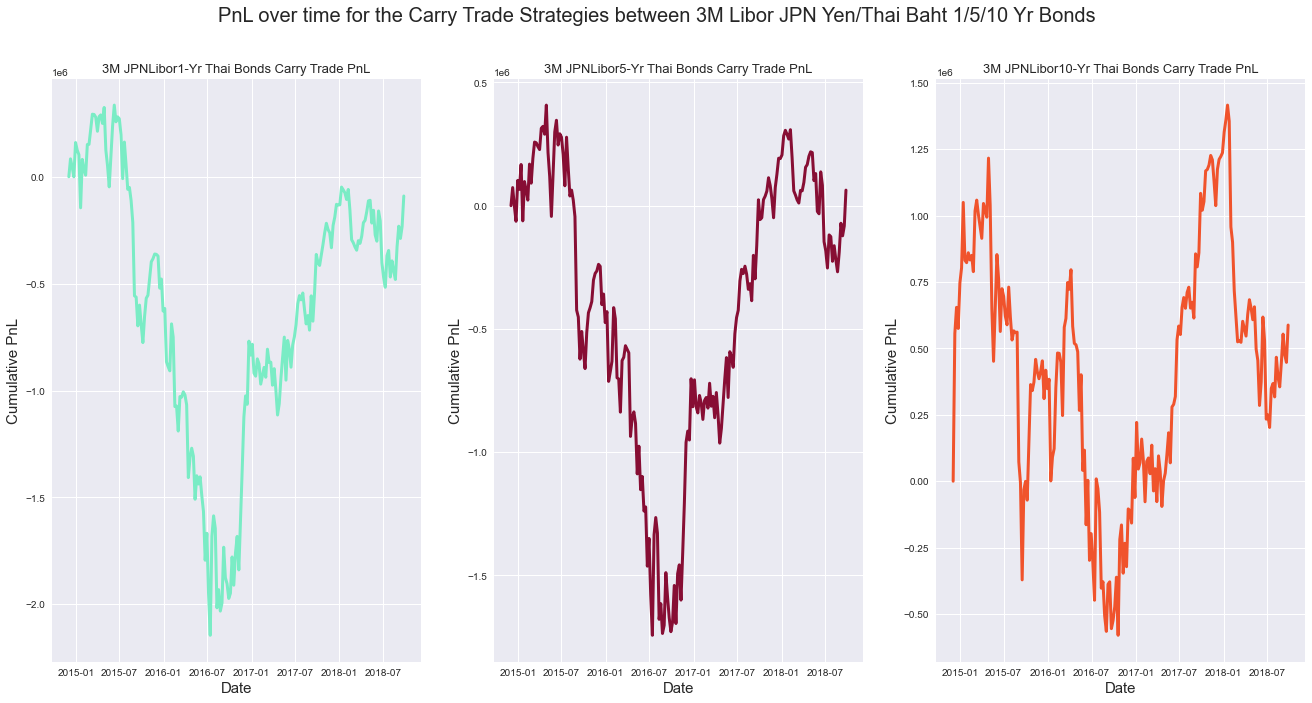

In [23]:
def pnl_plots(dfs, col_names):
    fig, axs = plt.subplots(1,3,figsize=(20,10))
    plt.style.use('ggplot')
    fig.suptitle('PnL over time for the Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds', fontsize = 20)
    
    for i in range(3):
        data = dfs[i]['PnL_Accumulated']
        axs[i].plot(data, c=np.random.rand(3,), lw= 3)
        axs[i].set_title("{} Carry Trade PnL".format(col_names[i]), fontsize = 13)
        axs[i].set_ylabel("Cumulative PnL", fontsize = 15)
        axs[i].set_xlabel("Date", fontsize = 15)
        
    plt.show()
pnl_plots(dfs_port_thai, col_names)

Our strategy get's absolutely crushed in 2016. We go pass our initial 2MM$ USD account. This explains some of the insanely high kurtosis we saw earlier.

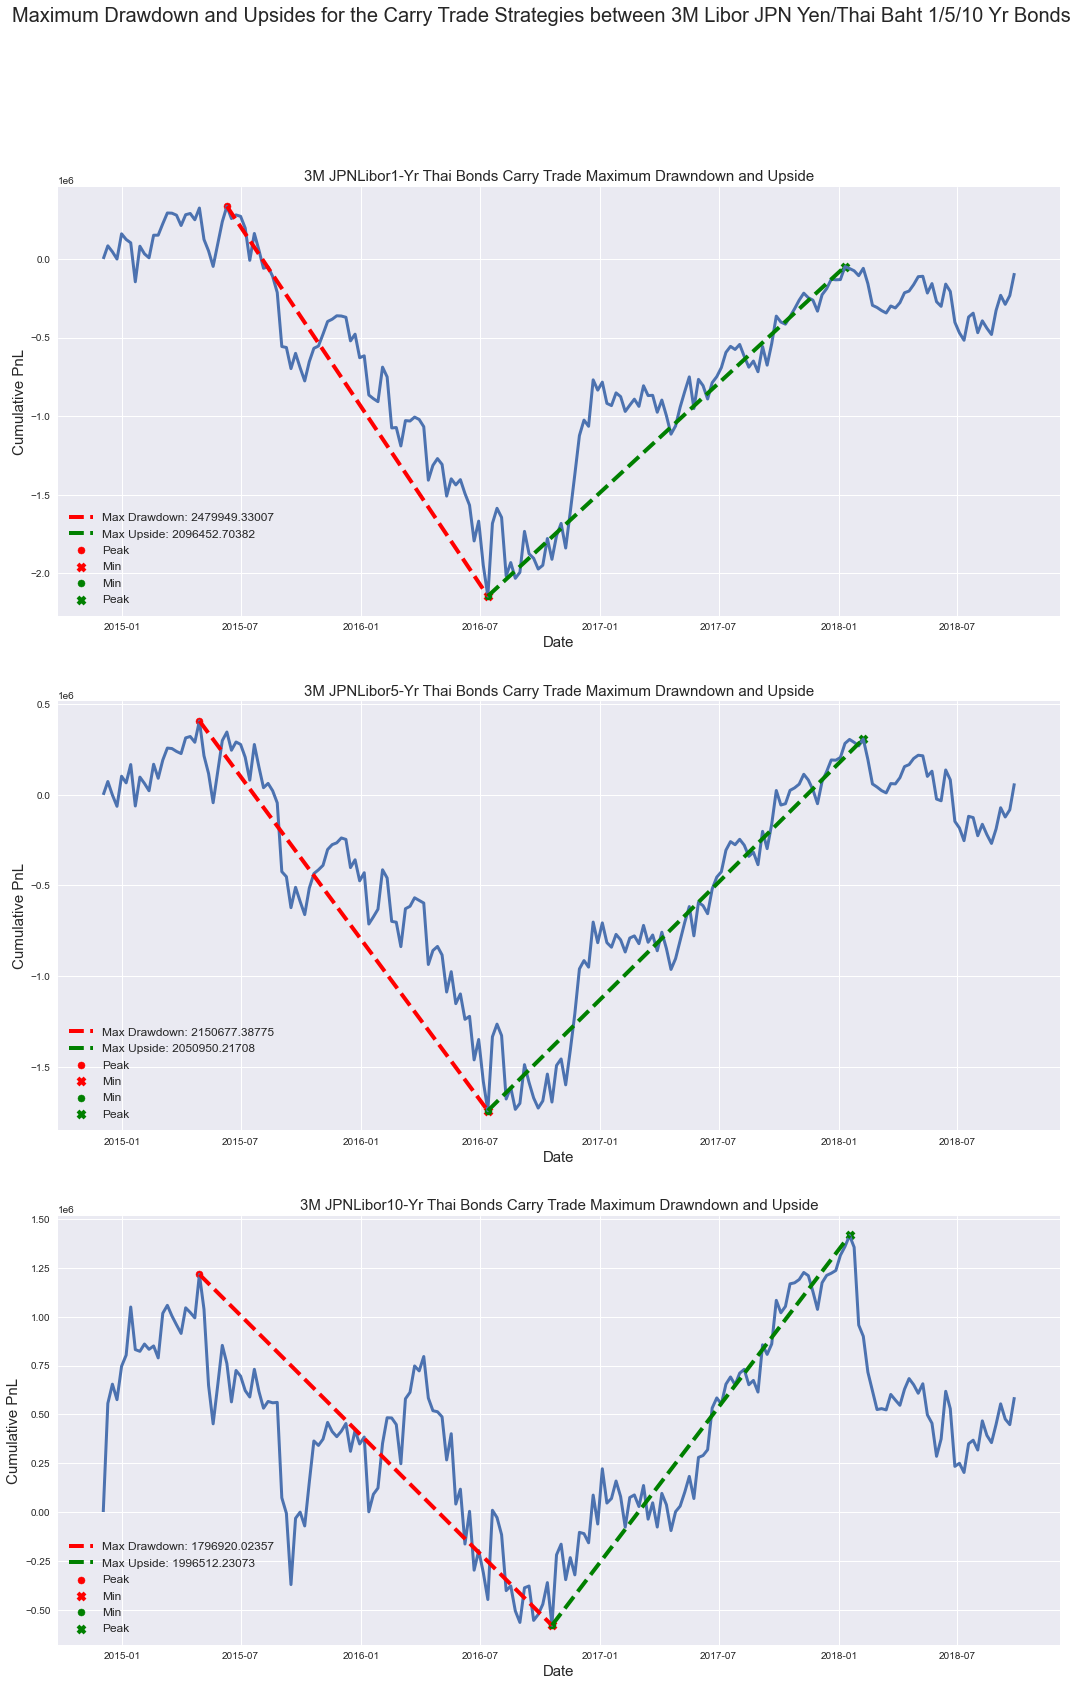

In [98]:
def drawdown_plots(dfs, col_names):
    fig, axs = plt.subplots(3,1,figsize=(16,25))
    plt.style.use('fivethirtyeight')
    fig.suptitle('Maximum Drawdown and Upsides for the Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds', fontsize = 20)
    
    for k in range(3):
        data = dfs[k]['PnL_Accumulated']
        axs[k].plot(data, lw= 3)
        axs[k].set_title("{} Carry Trade Maximum Drawndown and Upside".format(col_names[k]), fontsize = 15)
        axs[k].set_ylabel("Cumulative PnL", fontsize = 15)
        axs[k].set_xlabel("Date", fontsize = 15)
        i = np.argmax(np.maximum.accumulate(data) - data) # end of the period
        j = np.argmax(data[:i]) # start of period

        drawdown_start = data.index[j]
        drawdown_end = data.index[i]

        drawdown_peak = data.iloc[j]
        drawdown_min = data.iloc[i]
        
        drawdown = drawdown_peak - drawdown_min
        axs[k].scatter(drawdown_start,drawdown_peak, marker='o',color='red',label = 'Peak')
        axs[k].scatter(drawdown_end,drawdown_min, marker='x',color='red',label = 'Min')

        date_range = [drawdown_start, drawdown_end]
        data_range = [drawdown_peak, drawdown_min]

        axs[k].plot(date_range, data_range, '--', color = 'r',label = 'Max Drawdown: ' + str(round(drawdown,5)))

        i = np.argmax(data - np.minimum.accumulate(data)) # end of the period
        j = np.argmin(data[:i]) # start of period

        upside_start = data.index[j]
        upside_end = data.index[i]

        upside_peak = data.iloc[i]
        upside_min = data.iloc[j]

        upside = upside_peak - upside_min
        axs[k].scatter(upside_start,upside_min, marker='o',color='green',label = 'Min')
        axs[k].scatter(upside_end,upside_peak, marker='x',color='green',label = 'Peak')

        date_range = [upside_start, upside_end]
        data_range = [upside_min, upside_peak]

        axs[k].plot(date_range, data_range, '--', color ='green', label = 'Max Upside: ' + str(round(upside,5)))
        axs[k].legend(loc="best", fontsize = 12)
    plt.show()
drawdown_plots(dfs_port_thai, col_names)

## 2.5 Period Analysis 2016-2018 

Considering how heavily affected our strategy is in 2016 where our Accumulated PnL get's shattered then bounced back nicely in 2017 leading in to 2018. Let's look at the bond prices and FX price of what we borrow versus what we lend for the period.

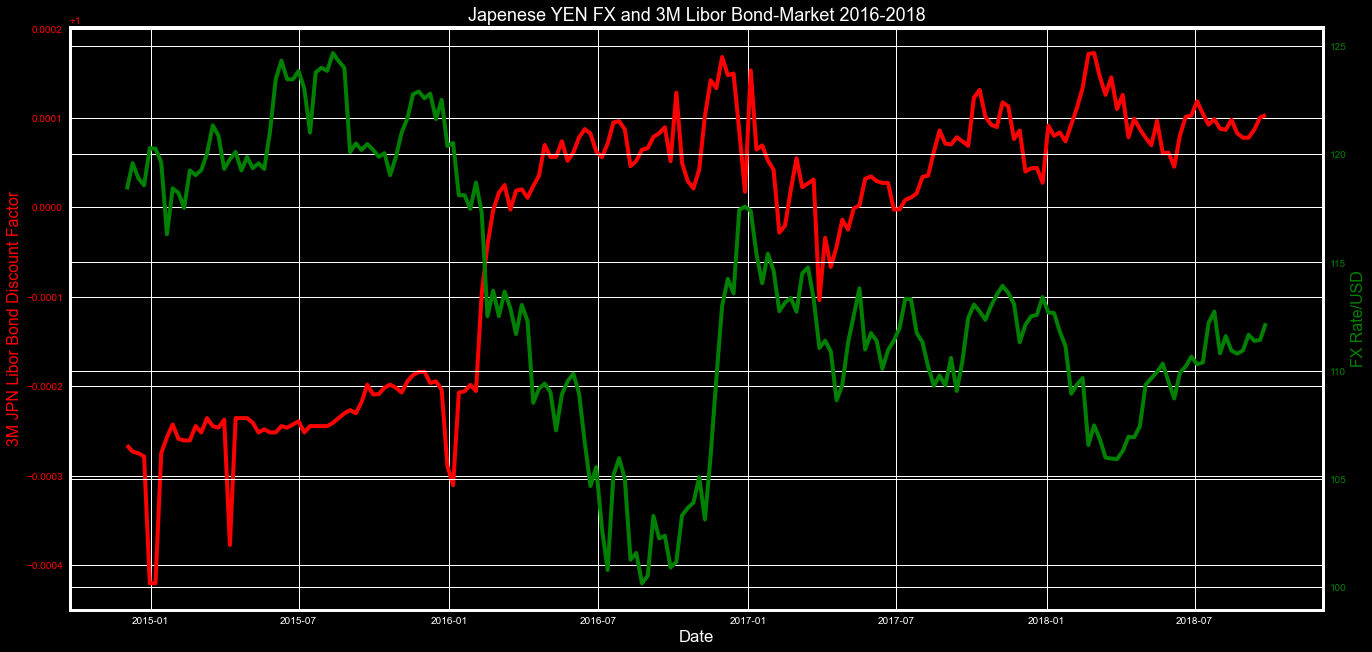

In [100]:
def bond_prices_plots(df, fx_col, bond_col, title, col_title,start_date = None, end_date = None):

    fig, ax1 = plt.subplots(figsize=(20, 10))
    plt.style.use('dark_background')
    if start_date and end_date:
        data_left = df[(df.index > start_date) & (df.index < end_date)][bond_col]
        data_right = df[(df.index > start_date) & (df.index < end_date)][fx_col]
    elif start_date and not end_date:
        data_left = df[(df.index > start_date)][bond_col]
        data_right = df[(df.index > start_date)][fx_col]
    elif not start_date and end_date:
        data_left = df[(df.index < end_date)][bond_col]
        data_right = df[(df.index < end_date)][fx_col]
    else:
        data_left = df[bond_col]
        data_right = df[fx_col]

    ax1.set_xlabel('Date')
    ax1.set_ylabel(col_title, color='red', size = 16) 
    ax1.plot(data_left.index, data_left, color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('FX Rate/USD', color='green', size = 16) 
    ax2.plot(data_right.index, data_right, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title(title, fontsize = 18) 
    plt.show()

bond_prices_plots(dfs_port_thai[0], 'FX_Rate_Borrow', 'Bond_borrow_open', "Japenese YEN FX and 3M Libor Bond-Market 2016-2018", '3M JPN Libor Bond Discount Factor')

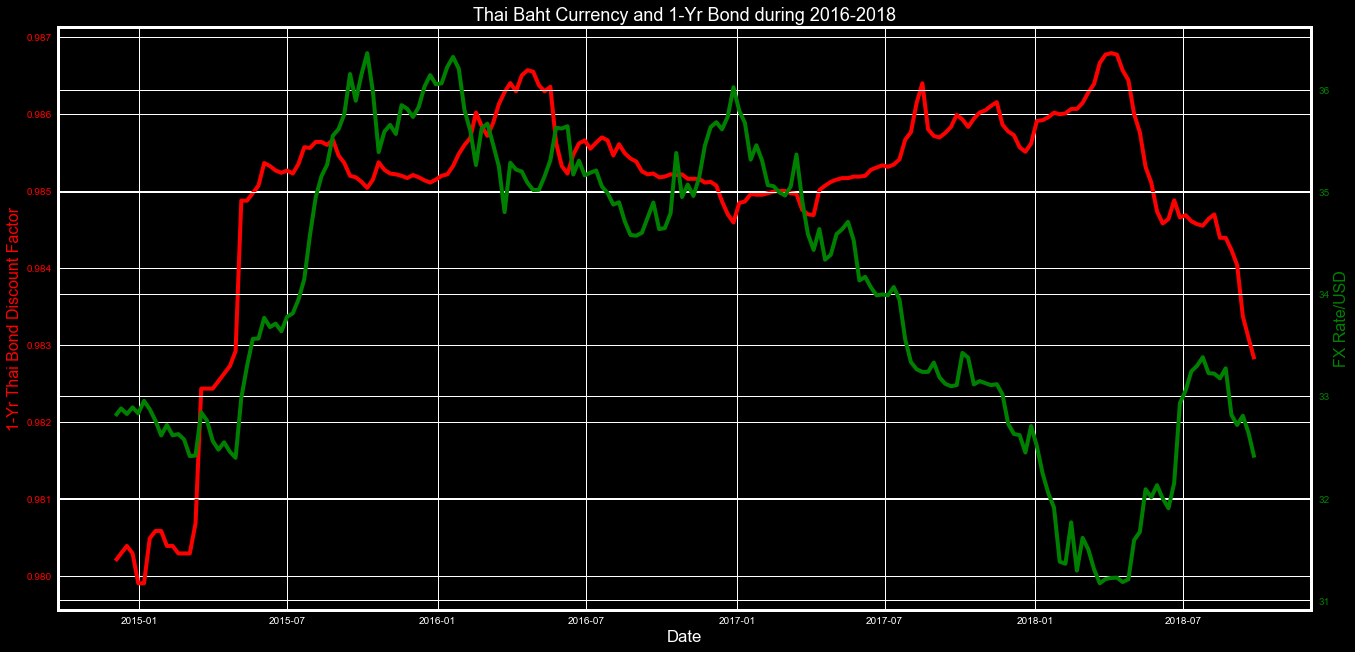

In [26]:
bond_prices_plots(dfs_port_thai[0], 'FX_Rate_Lend', 'Bond_lend_open', "Thai Baht Currency and 1-Yr Bond during 2016-2018","1-Yr Thai Bond Discount Factor")

Here we see an increase in the evaluation of the JPN Bond and a bigger increase in the evaluation of the YEN making our $US Dollar much less dominant. During the same period the Baht currency seems pretty stable samething for the bond. This explains why we have such a big loss during that period. 
When we look at 2017, the Thai currency appreciates vs the dollar but the bond market discount remains stable.

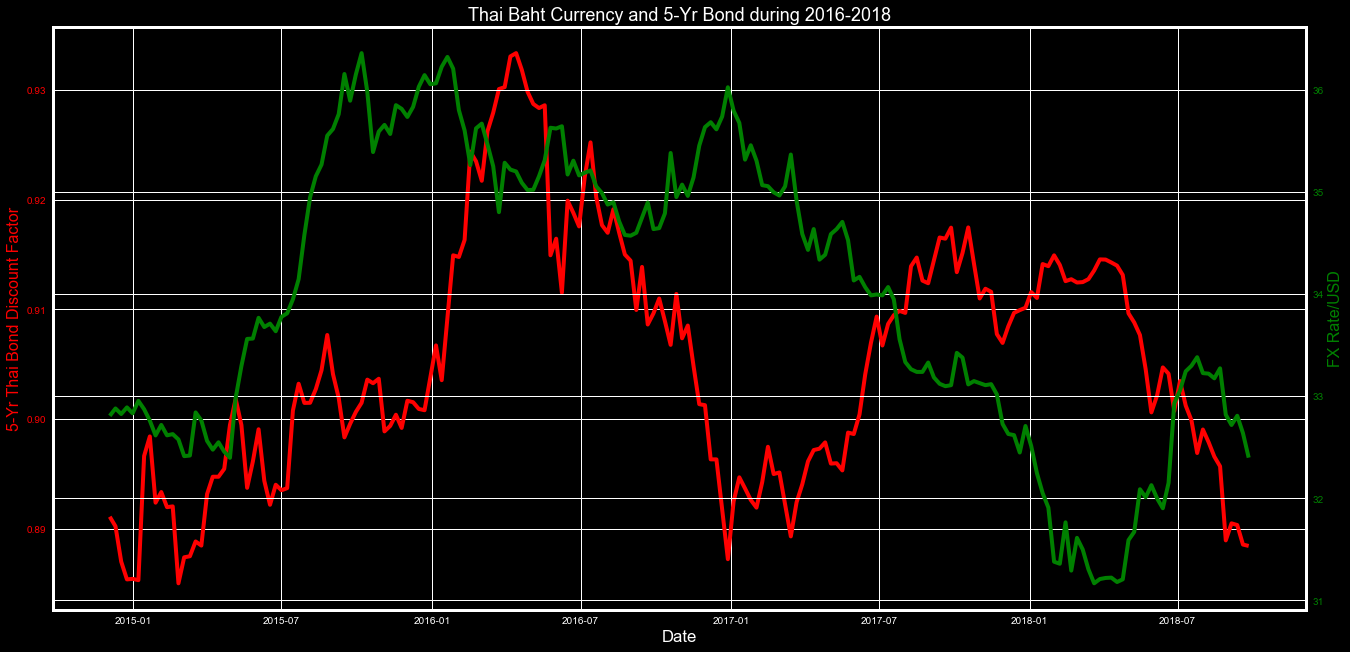

In [27]:
bond_prices_plots(dfs_port_thai[1], 'FX_Rate_Lend', 'Bond_lend_open', "Thai Baht Currency and 5-Yr Bond during 2016-2018", "5-Yr Thai Bond Discount Factor")

The decrease of the bond price that we are lending in 2016 does not offset the surge of the evaluation in the Japanese FX currency.  

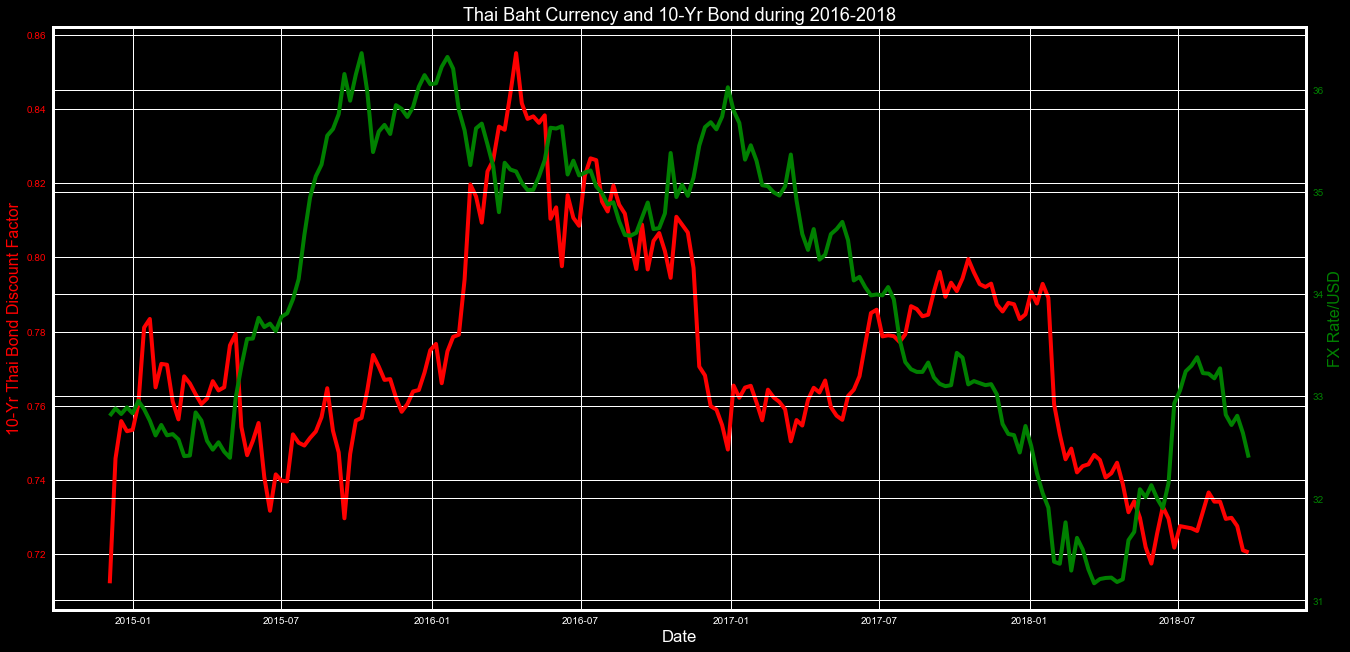

In [28]:
bond_prices_plots(dfs_port_thai[2], 'FX_Rate_Lend', 'Bond_lend_open', "Thai Baht Currency and 10-Yr Bond during 2016-2018","10-Yr Thai Bond Discount Factor")

Both in the 3-Yr and 10-Yr bond market we have a sizable run up in the bond market in 2016 which goes against us but then in the second half of 2016 things start getting better when the evaluation of the bonds goes down. Even though the FX rate goes down and we'd prefer if it was trending up, the gain we are making through the bonds offset that loss and we end up recovering our PnL in the 2nd half 2016.

## 2.6 Time-Series Analysis

Let's start by checking the ACF and PACF of the returns of our strategies

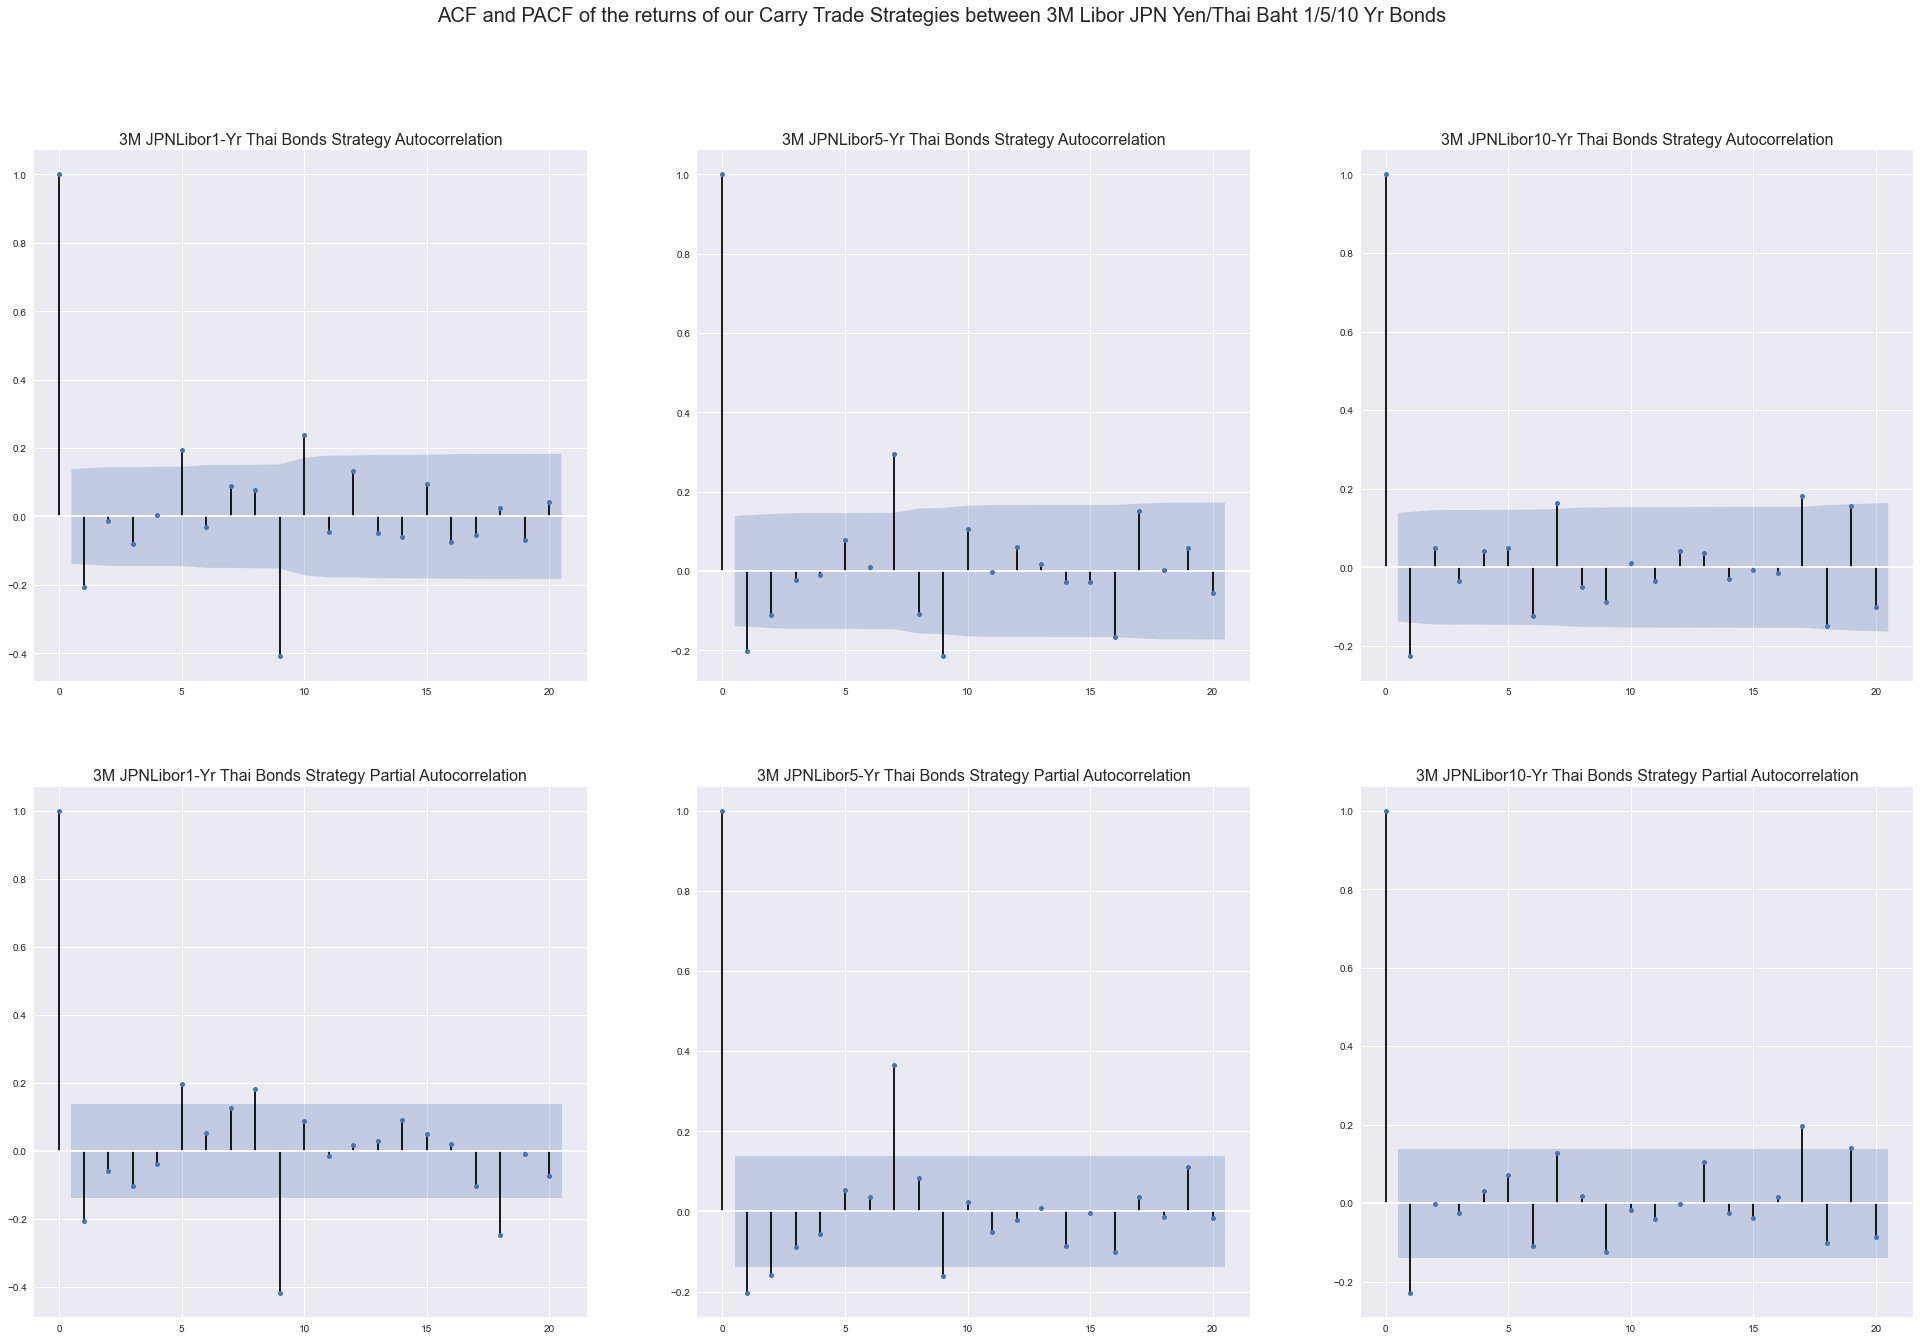

In [102]:
def plot_acf_pacf(dfs, col_names, title):
    fig, axs = plt.subplots(2,3,figsize=(30,20))
    plt.style.use('seaborn')
    fig.suptitle(title, fontsize = 20)

    for i in range(3):
        data = dfs[i]['Log_Returns']
        sm.graphics.tsa.plot_acf(data, ax = axs[0,i], lags = 20)
        sm.graphics.tsa.plot_pacf(data, ax = axs[1,i], lags = 20)
        axs[0,i].set_title('{} Strategy Autocorrelation'.format(col_names[i]), fontsize = 16)
        axs[1,i].set_title('{} Strategy Partial Autocorrelation'.format(col_names[i]), fontsize = 16)

plot_acf_pacf(dfs_port_thai,col_names,'ACF and PACF of the returns of our Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds')

There doesn't seem to be too anysignificant autocorrelation or partial autocorrelation other than a few outlier, let's run further analysis finding the first few values of PACF using Yule-Walker method. 

In [30]:
def yule_walker_pacf_df(dfs, col_names, lag):
    df = pd.DataFrame(columns = col_names)
    for i in range(len(dfs)):
        data = dfs[i]['Log_Returns']
        df[col_names[i]] = sm.tsa.stattools.pacf_yw(data, nlags = lag)
    return df
yule_walker_pacf_df(dfs_port_thai, col_names, 10)

3M JPNLibor1-Yr Thai Bonds  3M JPNLibor5-Yr Thai Bonds  \
0                       1.0000                      1.0000   
1                      -0.2073                     -0.2028   
2                      -0.0594                     -0.1586   
3                      -0.1028                     -0.0878   
4                      -0.0374                     -0.0570   
5                       0.1957                      0.0545   
6                       0.0513                      0.0362   
7                       0.1252                      0.3661   
8                       0.1829                      0.0847   
9                      -0.4171                     -0.1601   
10                      0.0880                      0.0236   

    3M JPNLibor10-Yr Thai Bonds  
0                        1.0000  
1                       -0.2282  
2                       -0.0024  
3                       -0.0248  
4                        0.0316  
5                        0.0710  
6                       -0.1089  
7                        0.1267  
8                        0.0173  
9                       -0.1253  
10                      -0.0185

There doesn't seem to be any patern that could be exploited. There does seem to be an outlier for the strategy with 3Yr Thai bonds but considering we're looking at a period of <200 weeks it is fairly possible that we have a statistical outlier from the low frequency of the data and if you keep digging around paterns there's always a possibility that the randomization in this case just didn't have enough time to mean-revert.  We can check for normality using Augmented Dickey Fuller Test.

In [31]:
def adf_df(dfs,col_names):
    df = pd.DataFrame(columns = ['p-value','ADF Stat'], index = col_names)
    for i in range(len(dfs)):
        data = dfs[i]['Log_Returns'].dropna().values
        ADF= sm.tsa.stattools.adfuller(data)
        df['p-value'].iloc[i] = ADF[1]
        df['ADF Stat'].iloc[i] = ADF[0]
        
    return df.T

adf_df(dfs_port_thai,col_names)

3M JPNLibor1-Yr Thai Bonds 3M JPNLibor5-Yr Thai Bonds  \
p-value                         0.0                     0.0039   
ADF Stat                    -4.8961                    -3.7121   

         3M JPNLibor10-Yr Thai Bonds  
p-value                          0.0  
ADF Stat                     -17.668

Given that for a dataset with a sample of ~250 the critical values of the ADF Test without trend are (-3.46, -2.88) for (1%/5%) and we are lower than that. We can have a confidence of 95%+ that there is no unit root present and that our data is mostly stationary. Let's look if there is any seasonality.

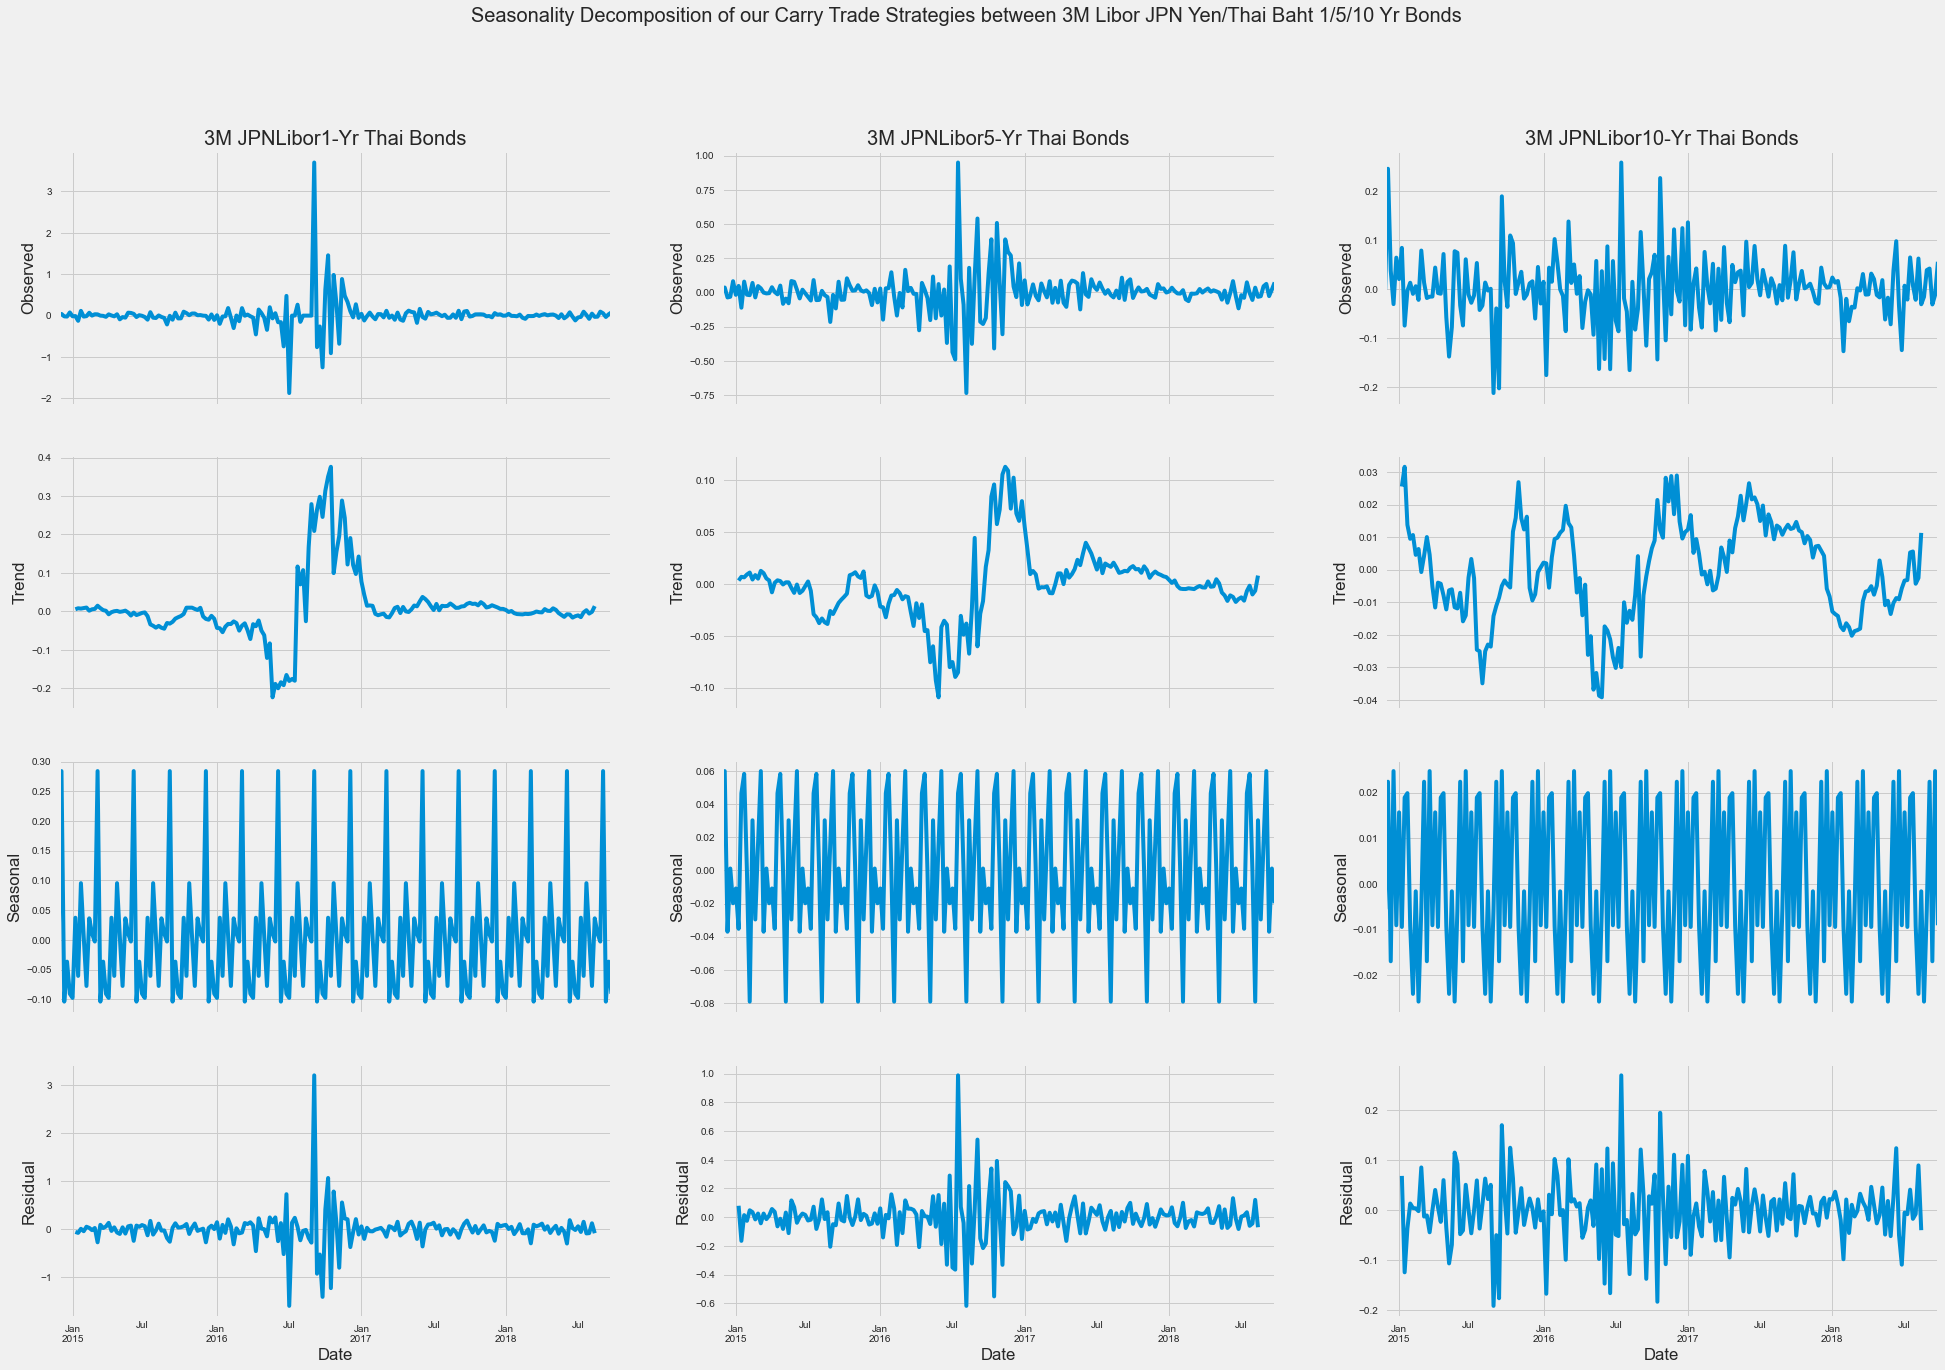

In [104]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
def plot_seasonality(dfs, col_names, title, per):
    fig, axs = plt.subplots(4,3,sharex=True,figsize=(30,20))
    plt.style.use('fivethirtyeight')
    fig.suptitle(title, fontsize = 20)
    
    for i in range(3):
        data = dfs[i]['Log_Returns']
        seasonality = sm.tsa.seasonal_decompose(data, model='additive', period=per)
        plotseasonal(seasonality, axs[:,i])
        axs[0,i].set_title(col_names[i])
    plt.show()
    
plot_seasonality(dfs_port_thai, col_names, 'Seasonality Decomposition of our Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds', per = 13)

Other than the period of 2016 where the trend went up for the shorter maturity bonds and the excessively high residuals in those periods, there doesn't seem to have anything interesting there. I decided to use a period of 13 since we are trading every week and I was trying to find quarterly patterns but even when I run it with different periods, there seem to have any additional valuable information. Perhaps the seasonality in trading the 1-Yr bond is enough to be relevant. Let's check how seasonality adjusted cumulative returns look like. 

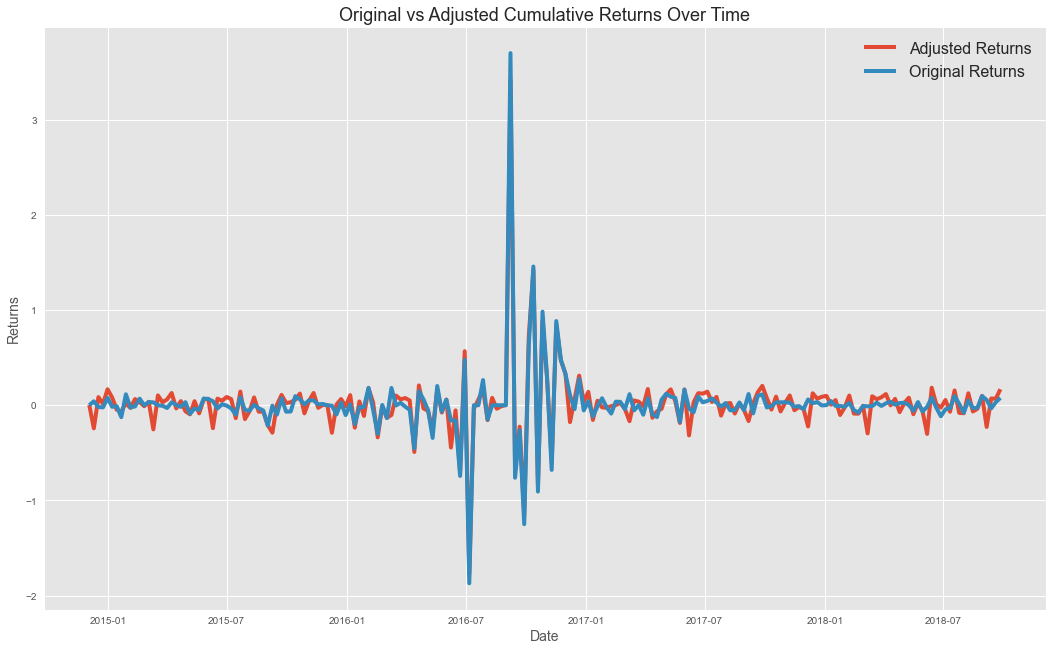

In [33]:
def seasonality_adjusted_plot(df, col, title, per):
    data = df[col]
    seasonality = sm.tsa.seasonal_decompose(data, model='additive', period=per)
    adj_data = data - seasonality.seasonal.dropna().to_frame('Seasonal')['Seasonal']
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(adj_data, label = 'Adjusted Returns')
    ax.plot(data, label = 'Original Returns')
    ax.set_xlabel("Date", fontsize = 14)
    ax.set_ylabel('Returns', fontsize = 14)
    ax.set_title(title, fontsize = 18)
    plt.legend(fontsize = 16)
    plt.show()
    
seasonality_adjusted_plot(dfs_port_thai[0], 'Log_Returns', 'Original vs Adjusted Cumulative Returns Over Time', 13)

There seem to be a significant different prior to 2016-07 and after 2017-01. This is probably the result of overcompensation for the turbulant period. Let's look at the QQ plots for the residuals, we would expect significant deviation from normal distribution.

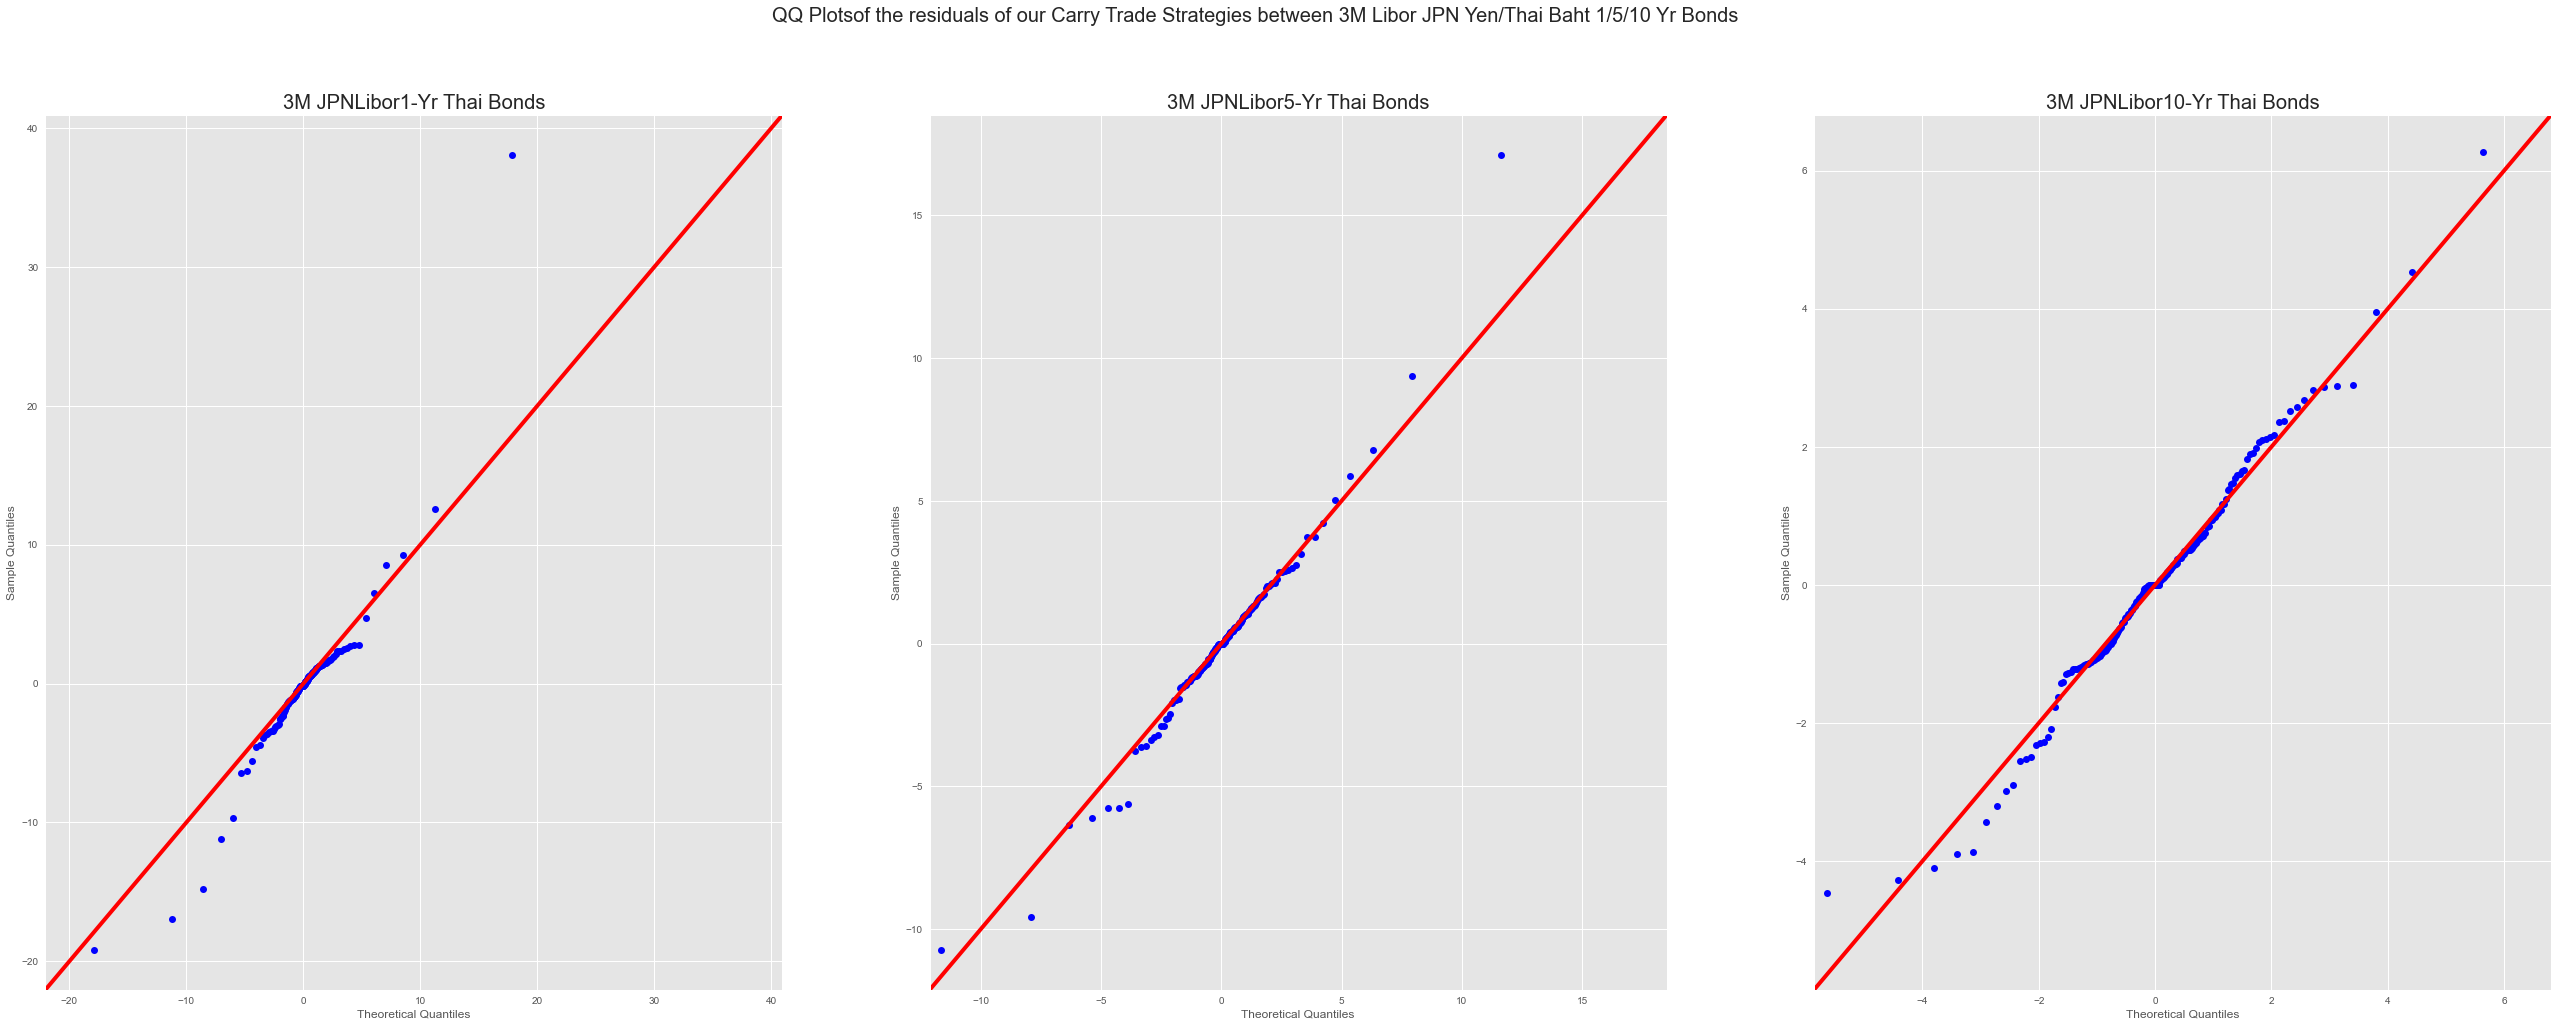

In [34]:
def qq_plots(dfs, col_names, title, per):
    fig, axs = plt.subplots(1,3,figsize=(40,15))
    plt.style.use('fivethirtyeight')
    fig.suptitle(title, fontsize = 20)
    
    for i in range(3):
        data = dfs[i]['Log_Returns']
        seasonality = sm.tsa.seasonal_decompose(data, model='additive', period=per)
        res = seasonality.resid
        res = res.fillna(res.mean())
        sm.qqplot(res, sp.stats.t, fit=True, line="45", ax = axs[i])
        axs[i].set_title(col_names[i])
    plt.show()
    
qq_plots(dfs_port_thai,col_names,'QQ Plotsof the residuals of our Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds', 13)

Clearly, when we get away from the mean and the mode of the distribution there is significant different than what would be expected from a normal distribution given the eratic behavior in 2016.

## 2.7 Farma-French Regression

In [35]:
def ff_regression(dfs, col_names,col):
    ff_path = 'F-F_Research_Data_Factors_daily.CSV'
    ff_df = pd.read_csv(ff_path)
    ff_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
    ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
    corr_dfs= []
    regression_dfs = []
    for i in range(len(dfs)):
        ff_df_temp = copy.deepcopy(ff_df)
        ff_df_temp = ff_df_temp.set_index(["Date"])
        ff_df_temp  = ff_df_temp[ff_df_temp.index.isin(dfs[i].index)]
        ff_df_temp ['Ret'] = dfs[i][col]
        ff_df_temp ['Mkt'] = ff_df_temp ['Mkt-RF'] + ff_df_temp ['RF']
        ff_df_temp  = ff_df_temp .fillna(0)
        corr_df = ff_df_temp.corrwith(ff_df_temp ['Ret']).to_frame().rename_axis("Factors")
        corr_dfs.append(corr_df)
        regression_dfs.append(ff_df_temp)
        
    correlation_df = pd.concat(corr_dfs, axis=1)
    correlation_df.columns = col_names
    return correlation_df, regression_dfs

ff_dfs = ff_regression(dfs_port_thai, col_names,"Log_Returns")
ff_dfs[0]

3M JPNLibor1-Yr Thai Bonds  3M JPNLibor5-Yr Thai Bonds  \
Factors                                                           
Mkt-RF                      -0.0649                     -0.0516   
SMB                         -0.0031                      0.0426   
HML                         -0.0042                     -0.0739   
RF                           0.0039                      0.0341   
Ret                          1.0000                      1.0000   
Mkt                         -0.0649                     -0.0515   

         3M JPNLibor10-Yr Thai Bonds  
Factors                               
Mkt-RF                       -0.0918  
SMB                           0.0080  
HML                          -0.1077  
RF                            0.0120  
Ret                           1.0000  
Mkt                          -0.0918

Our strategy shows very little correlation with Farma-French Factors, let's visualize it.

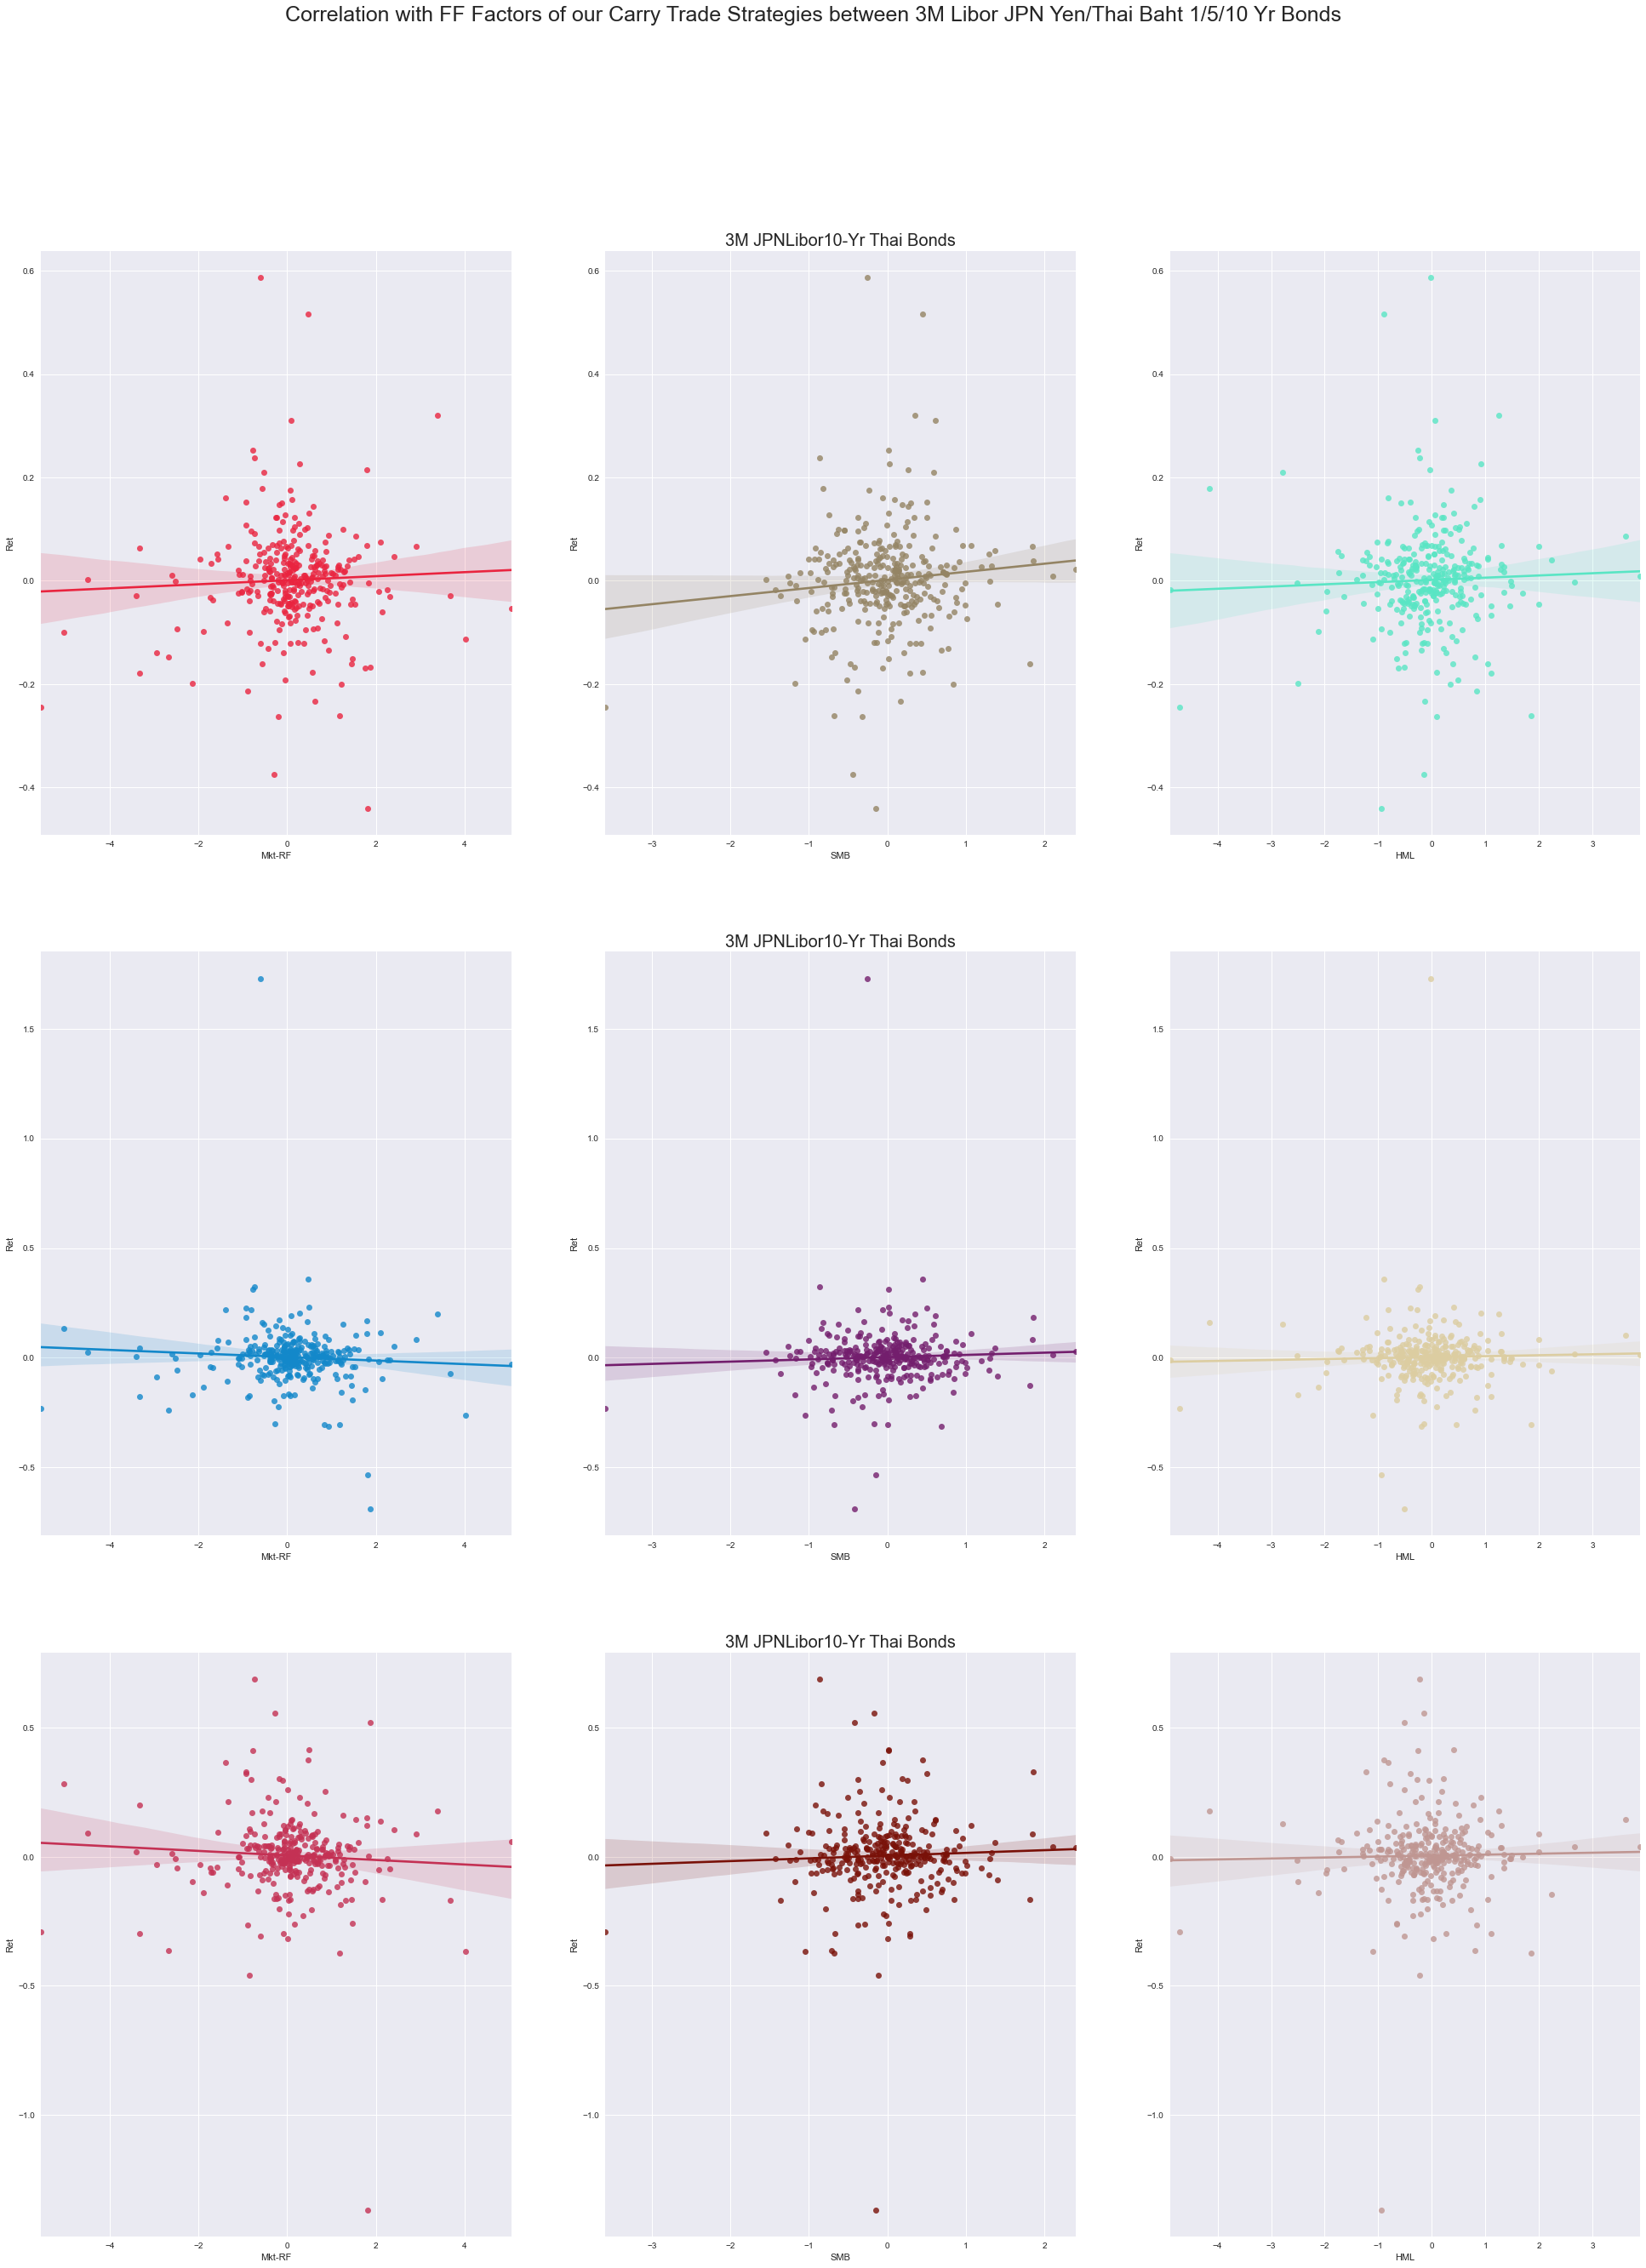

In [106]:
def ff_plot(regress_dfs, col_name, title):
    plt.style.use('seaborn')
    fig, axs = plt.subplots(len(regress_dfs),3, figsize = (30,40))
    fig.suptitle(title, fontsize = 25)
    for j in range(len(regress_dfs)):
        for i in range(3):
            sns.regplot(data =regress_dfs[j],y = 'Ret',x=regress_dfs[j].columns[i], ax = axs[j,i], color= np.random.rand(3,))
        axs[j,1].set_title(col_names[i], fontsize = 20)
    plt.show()
ff_plot(ff_dfs[1], col_names, 'Correlation with FF Factors of our Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds')

As we'd expect and the points are everywhere and there little the regression can predict.

In [37]:
def ff_portfolio_metrics(dfs, col_names,col):
    ff_path = 'F-F_Research_Data_Factors_daily.CSV'
    ff_df = pd.read_csv(ff_path)
    ff_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
    ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
    port_metrics_dfs= []
    downside_beta_dfs = []
    for i in range(len(dfs)):
        ff_df_temp = copy.deepcopy(ff_df)
        ff_df_temp = ff_df_temp.set_index(["Date"])
        ff_df_temp = ff_df_temp[ff_df_temp.index.isin(dfs[i].index)]
        ff_df_temp['Ret'] = dfs[i][col]
        ff_df_temp["RF"] /= 100
        ff_df_temp['Mkt-RF'] /= 100
        ff_df_temp['Mkt'] = ff_df_temp ['Mkt-RF'] + ff_df_temp ['RF']
        ff_df_temp = ff_df_temp.fillna(0)
        
        Sharpe_Ratio = np.sqrt(52)*(ff_df_temp['Ret'] - ff_df_temp["RF"]).mean()/ff_df_temp['Ret'].std()
        Sortino_Ratio  = np.sqrt(52)*(ff_df_temp['Ret'] - ff_df_temp["RF"]).mean()/ (np.sqrt(ff_df_temp['Ret'][ff_df_temp['Ret']<0]**2).sum()/len(ff_df_temp['Ret']))
        Treynor_Ratio = 52*(ff_df_temp['Ret'] - ff_df_temp["RF"]).mean()/np.corrcoef(ff_df_temp['Ret'],ff_df_temp['Mkt-RF'])[0][1]
        metric_df = pd.Series({'Sharpe_Ratio':Sharpe_Ratio,'Sortino_Ratio':Sortino_Ratio,'Treynor_Ratio':Treynor_Ratio}).to_frame().rename_axis("Metrics")
        port_metrics_dfs.append(metric_df)
        
        downmkt_df = ff_df_temp[ff_df_temp['Mkt-RF'] + ff_df_temp['RF'] < 0]
        y = downmkt_df['Ret']
        x = sm.add_constant(downmkt_df['Mkt-RF'])

        downside_beta = sm.OLS(y, x).fit().params.to_frame('Downside Beta Regression {}'.format(col_names[i]))
        downside_beta.loc['R${^2}$'] = sm.OLS(y, x).fit().rsquared
        downside_beta_dfs.append(downside_beta)
        
    port_metrics_dfs = pd.concat(port_metrics_dfs, axis=1)
    port_metrics_dfs.columns = col_names
    
    downside_beta_dfs = pd.concat(downside_beta_dfs, axis=1)
    return port_metrics_dfs, downside_beta_dfs

ff_metrics = ff_portfolio_metrics(dfs_port_thai, col_names,"Log_Returns")
ff_metrics[0]

3M JPNLibor1-Yr Thai Bonds  3M JPNLibor5-Yr Thai Bonds  \
Metrics                                                                 
Sharpe_Ratio                       0.2092                      0.0111   
Sortino_Ratio                      1.2738                      0.0398   
Treynor_Ratio                     -8.6620                     -0.2355   

               3M JPNLibor10-Yr Thai Bonds  
Metrics                                     
Sharpe_Ratio                        0.1277  
Sortino_Ratio                       0.3693  
Treynor_Ratio                      -0.7006

As we'd suspect all of these metrics are pretty bad which is not surprising given how volatile and the poor performance of the strategy surprisingly the Sortino Ratio is not too bad for 1-Yr bond case. As for the other two cases,the metrics are quite bad. Let's look into the downside beta that may help explains the Sortino Ratio for the 1-Yr case. 

In [38]:
ff_metrics[1]

Downside Beta Regression 3M JPNLibor1-Yr Thai Bonds  \
const                                               0.0381     
Mkt-RF                                              4.0660     
R${^2}$                                             0.0096     

         Downside Beta Regression 3M JPNLibor5-Yr Thai Bonds  \
const                                               0.0101     
Mkt-RF                                              2.1805     
R${^2}$                                             0.0051     

         Downside Beta Regression 3M JPNLibor10-Yr Thai Bonds  
const                                               0.0199     
Mkt-RF                                              1.6682     
R${^2}$                                             0.0127

Given our low correlation to any of the factors or the S&P market in general , it is not too surprising if not expected of a result to have little to no correlation to downside. Different market different type of macroeconomic and factors that affect it's market at different size and time. While the parameters for the 1-Yr bond are greater than the other two, it is not enough to make any conclusion with such a low $R^2$.

## 2.8 Additional Analysis

Considering we opted out for a strategy that changes the leverage over time, let's see how it varies over time.

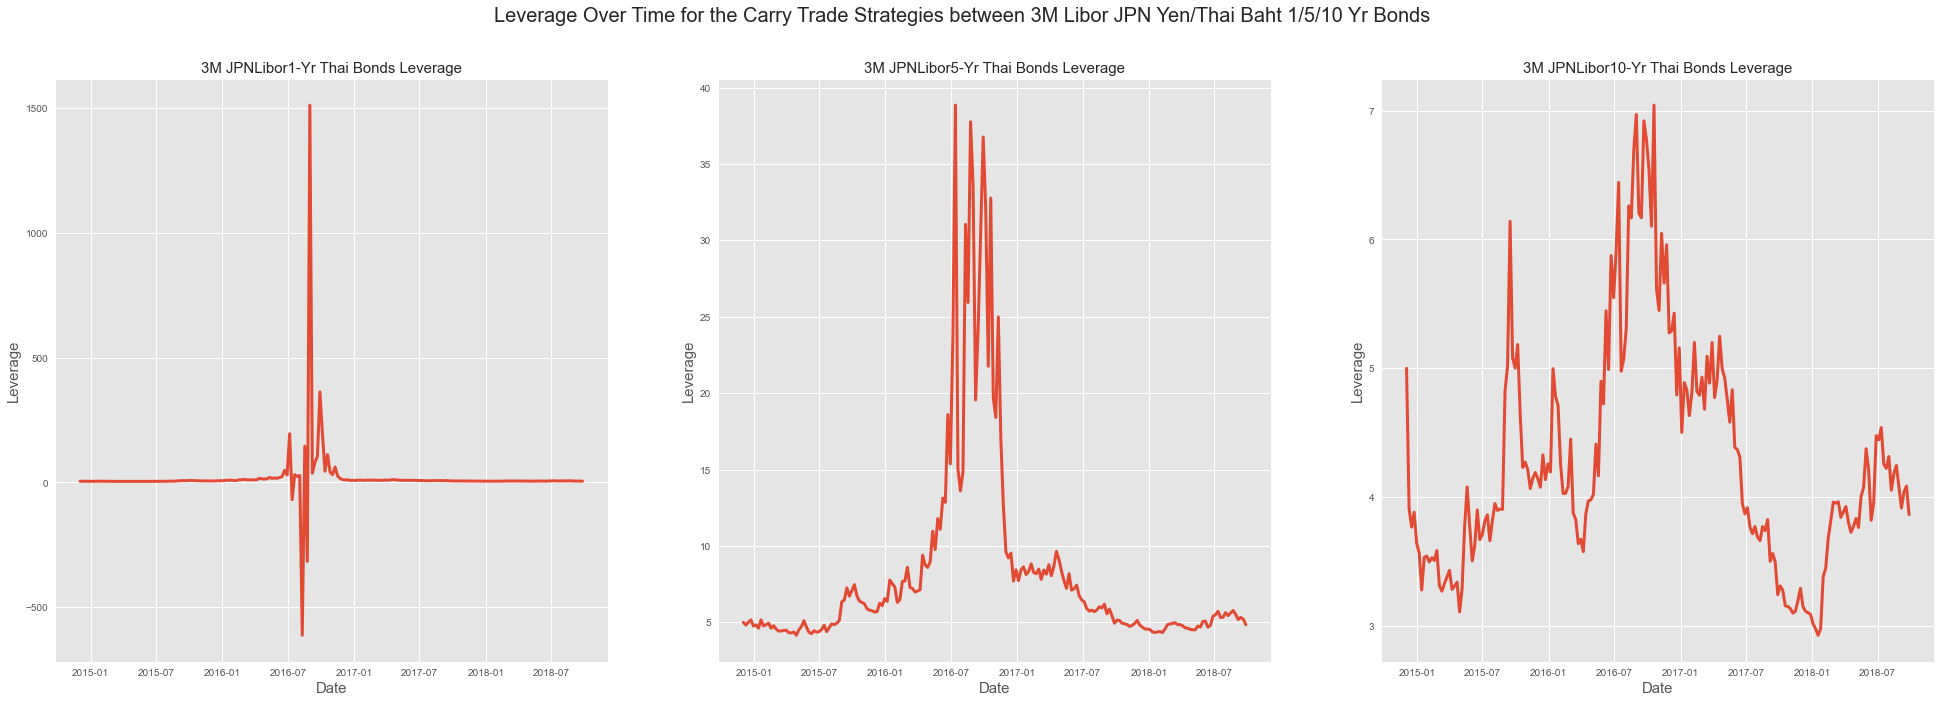

In [109]:
def leverage_plots(dfs, col_names, title):
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    plt.style.use('ggplot')
    fig.suptitle(title, fontsize = 20)
    
    for k in range(3):
        data = dfs[k]['Leverage']
        axs[k].plot(data, lw= 3)
        axs[k].set_title("{} Leverage".format(col_names[k]), fontsize = 15)
        axs[k].set_ylabel("Leverage", fontsize = 15)
        axs[k].set_xlabel("Date", fontsize = 15)
        
    plt.show()
leverage_plots(dfs_port_thai, col_names, 'Leverage Over Time for the Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds')

Notice how the leverage goes absolute nuts in the first one. This is because we essentially blew out more money than we had and we should have terminated but for the sake of the exercise we continued trading. In the second one, we nearly blew our portfolio and came back to our initial 5x leverage and for the longer and more stable maturity, we were able to keep the leverage in check within a gap of +/- 2x of our original leverage.

The next plot shows how many trades were losts (-1) vs wins (+1) when both FX currencies goes against us.

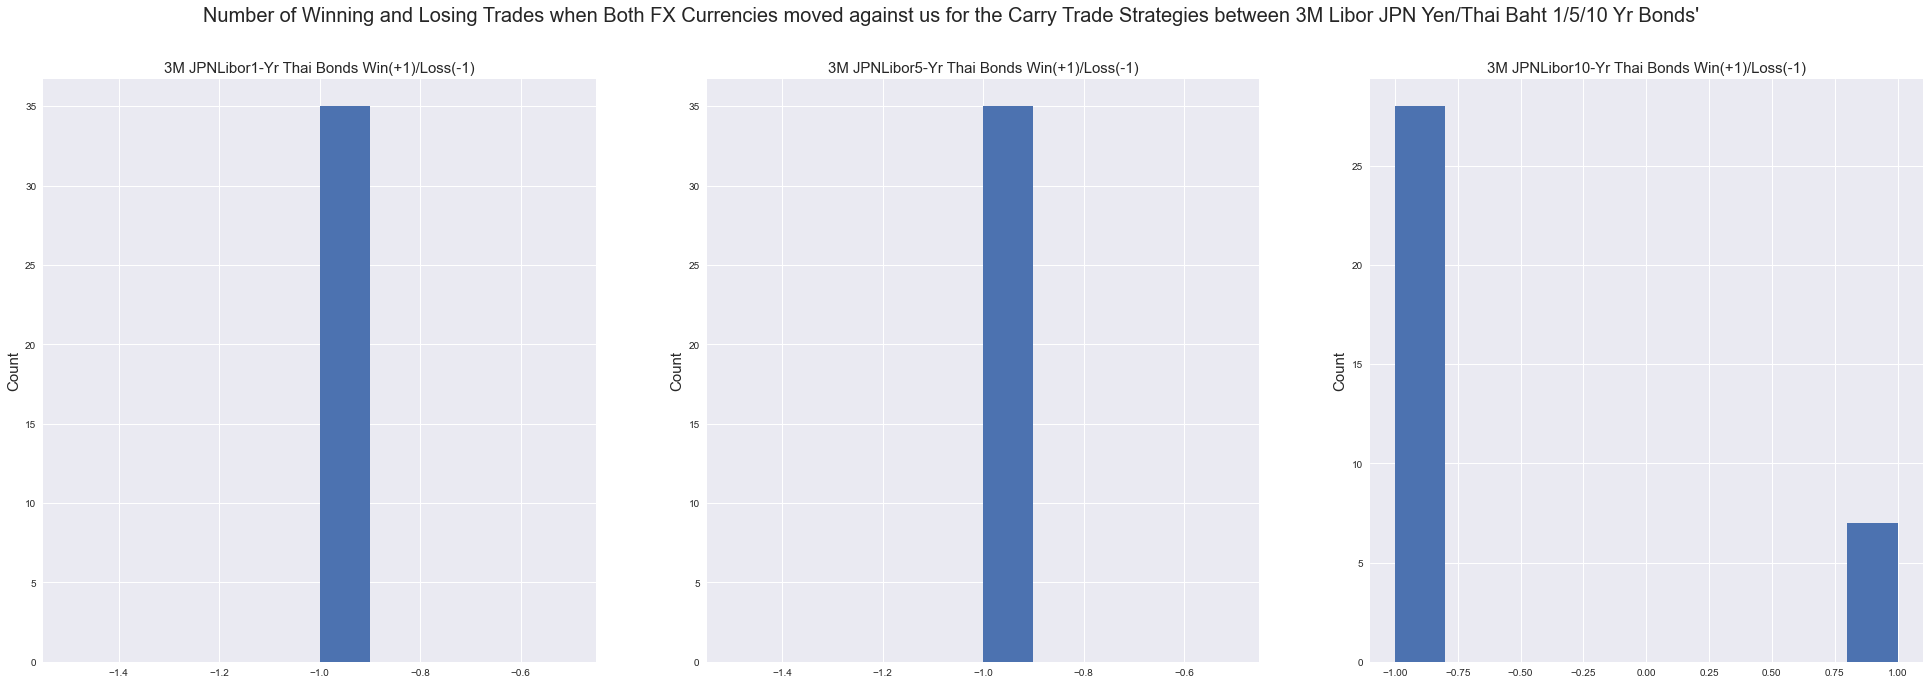

In [107]:
def win_lost_vs_FX(dfs, col_names, title):
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    plt.style.use('seaborn')
    fig.suptitle(title, fontsize = 20)
    
    for k in range(3):
        data = dfs[k][dfs[k]['Strat_vs_FX'] != 0]['Strat_vs_FX']
        axs[k].hist(data)
        axs[k].set_title("{} Win(+1)/Loss(-1)".format(col_names[k]), fontsize = 15)
        axs[k].set_ylabel("Count", fontsize = 15)
        
    plt.show()

win_lost_vs_FX(dfs_port_thai, col_names, "Number of Winning and Losing Trades when Both FX Currencies moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds'")

Again the strategy with selling longer term bonds shows more stable and robust by having us win trades even when the currencies moved against us. Let's look at when the bonds moved against us. 

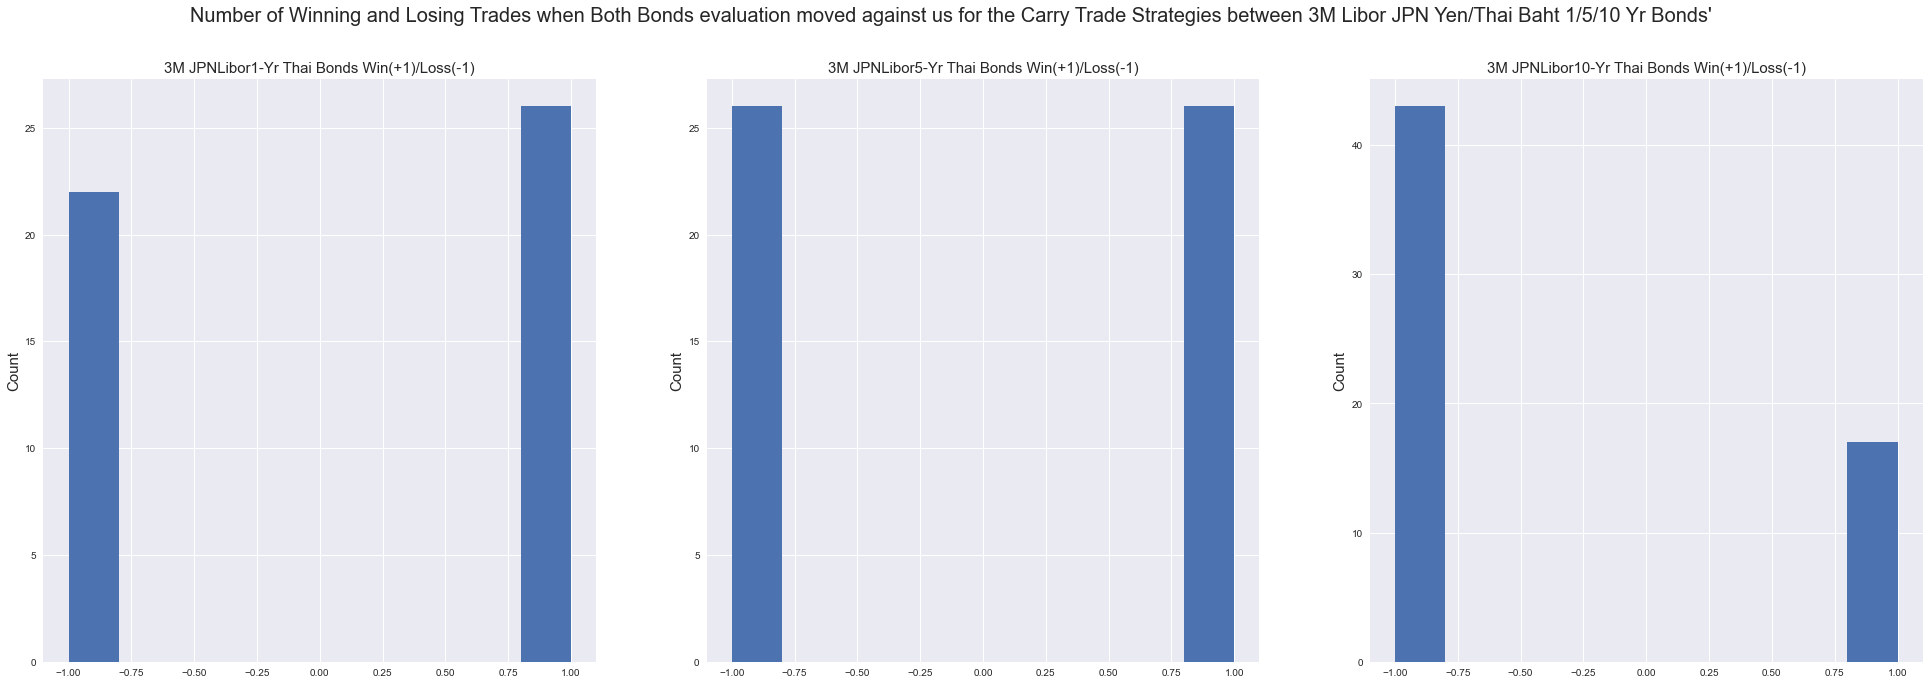

In [41]:
def win_lost_vs_bonds(dfs, col_names, title):
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    plt.style.use('seaborn')
    fig.suptitle(title, fontsize = 20)
    
    for k in range(3):
        data = dfs[k][dfs[k]['Strat_vs_Bond'] != 0]['Strat_vs_Bond']
        axs[k].hist(data)
        axs[k].set_title("{} Win(+1)/Loss(-1)".format(col_names[k]), fontsize = 15)
        axs[k].set_ylabel("Count", fontsize = 15)
        
    plt.show()

win_lost_vs_bonds(dfs_port_thai, col_names, "Number of Winning and Losing Trades when Both Bonds evaluation moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Thai Baht 1/5/10 Yr Bonds'")

There seems to be very little correlation with the weekly move in bond prices comapre to the effect of FX on the evaluation given that when both bonds moved against us, in the first 2 cases we have more or equal amount of winning trades. As for the longer maturity where things seems more stable, we observe more losing trades. 

# 3. Analyzing Roumanian Leu vs 3M Libor JPN Yen Carry Trade

We'll analyze three different carry trade strategies, 1Y, 5Y and 10Y for Roumanian Leu. I chose three since for each currencies there are at least 3 different Tenor of 1Y+ to analyze for homogeneity and we had the same tenors available for the Thai Baht which could be interesting to compare.

In [42]:
dfs_rou = [df_zcb[2]['12-Month'].to_frame()[df_zcb[2].index < '2021-04-23'],df_zcb[2]['5-Year'].to_frame()[df_zcb[2].index < '2021-04-23'],df_zcb[2]['10-Year'].to_frame()[df_zcb[2].index < '2021-04-23']]

In [43]:
dfs_port_rou = [] 
for i in range(len(dfs_rou)):
    dfs_port_rou.append(carry_trade_simulation(dfs_rou[i], df_jp_3m_libor, df_fx[2], df_fx[1]))

Printing number of null values in dataframe: 
12-Month          0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64
Printing number of null values in dataframe: 
5-Year            0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64
Printing number of null values in dataframe: 
10-Year           0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64


## 3.1 Bond Prices Statistics

In [44]:
col_names = ['JPN 3M-ZCBond','Rou 1Yr-ZCBond', 'Rou 5Yr-ZCBond', 'Rou 10Yr-ZCBond']
col_data = ['Bond_borrow_open'] + 3*['Bond_lend_open']

bond_moments_dataframe(dfs_port_rou, col_names, col_data)

JPN 3M-ZCBond Rou 1Yr-ZCBond Rou 5Yr-ZCBond Rou 10Yr-ZCBond
Mean                0.9999         0.7109         0.8157          0.6252
Median                 1.0         0.7082         0.8237           0.637
Std Dev             0.0003         0.1482         0.0627          0.0766
1st Quartile        0.9996         0.6193         0.7867          0.5841
3rd Quartile        1.0001         0.8385         0.8734          0.6826
Skew               -0.0739        -0.2486        -0.5524         -0.4642
Kurtosis           -1.5887        -0.9674        -0.7902         -0.7326

Here we do not notice the same phenomena with really high kurtosis for any of them, it seens to be a lot more stable in terms of bond pricing. For the Thai version, we had positive skews for the longer term bonds (5/10) Years and in this case we have negative skew.

## 3.2 FX Statistics

In [45]:
col_names = ['JPN/YEN FX','Rou/LEU FX', 'YEN/LEU Spread']
col_data = ['FX_Rate_Borrow', 'FX_Rate_Lend']

fx_moments_dataframe(dfs_port_rou, col_names, col_data)

JPN/YEN FX Rou/LEU FX YEN/LEU Spread
Mean           103.2331     3.7833        27.3487
Median         107.0725     3.9452        27.2342
Std Dev         13.1324     0.4229          2.593
1st Quartile    98.5865     3.3471        25.4567
3rd Quartile   111.5864     4.1157        29.2355
Skew            -0.7798    -0.4513        -0.0056
Kurtosis        -0.4403    -1.0542        -0.5569

Similar values than the Baht currency, nothing too distinguishable here again.

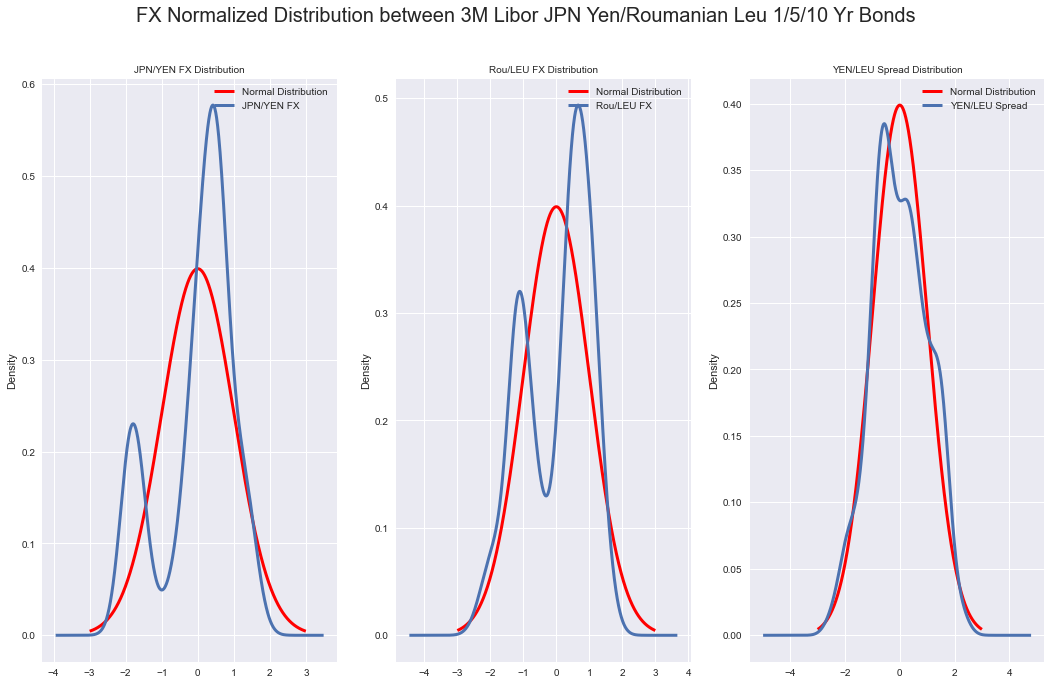

In [46]:
fx_distribution_plot(dfs_port_rou, col_names, col_data, 'FX Normalized Distribution between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

We can observe that there is a bimodal distribution for both the Japanese Yen and the Roumanian Leu but that they seem to juxtapose so when taking their spread the effect diminishes. Likely that the FX Rate tends to stay higher for a long time period and tends to stay lower for a long period as well not following a mean-reversing over long period but can exhibit mean-reversing behavior in short-time periods. Say an economic crisis, or an important sector of the economy has been hit or is greatly profiting from the rise of price of a commodity can lead to periods of time that the rates tends to stick to a higher or lower value longer.

## 3.3 Daily Returns

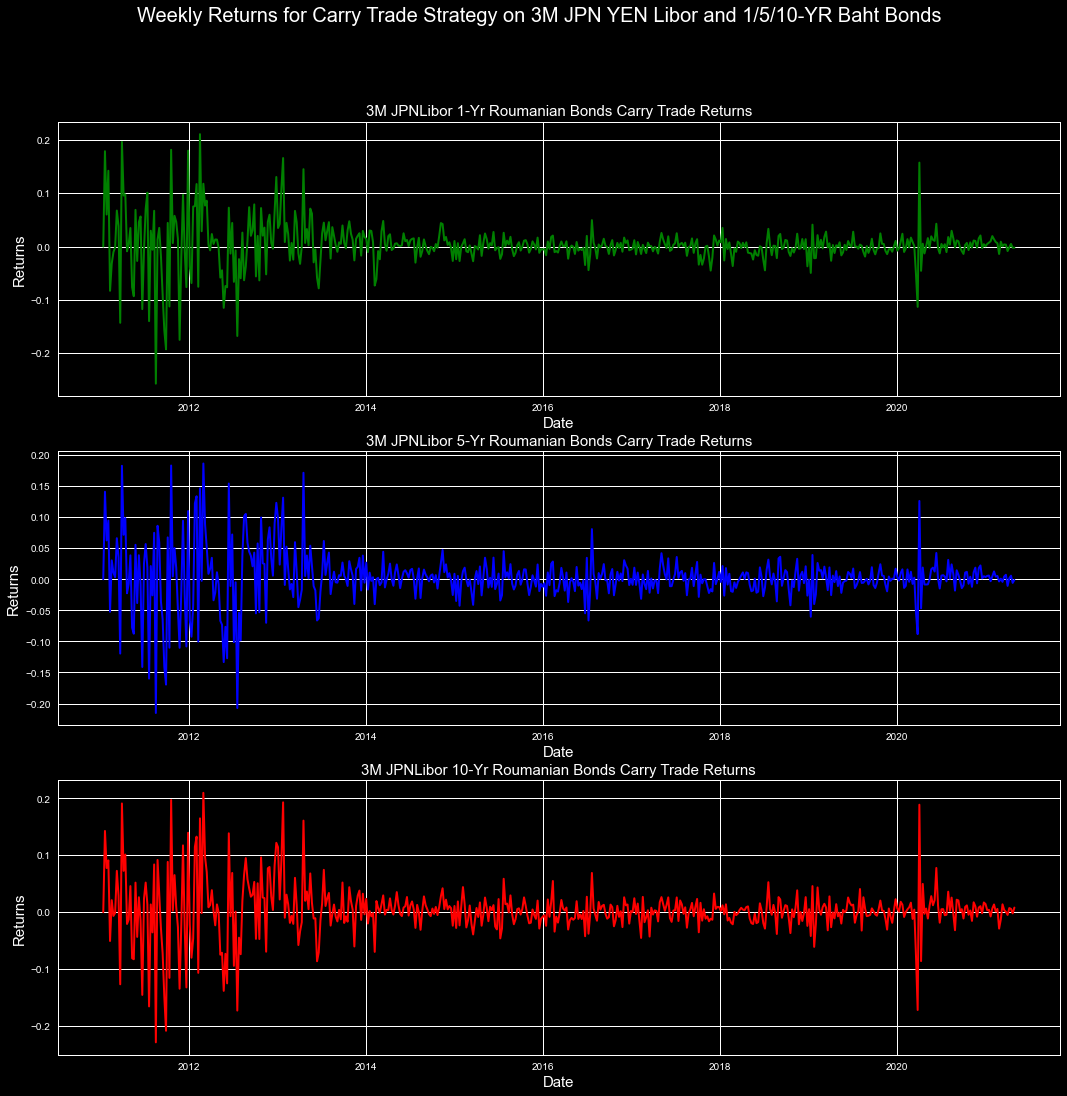

In [111]:
col_names = ["3M JPNLibor "+str(i)+"-Yr Roumanian Bonds" for i in [1,5,10]]
daily_returns_carry_trade(dfs_port_rou, col_names)

In all the cases the returns looks very similar with more hectic behavior around 2012 and the spread of the returns doesn't go astronomical like it did with the Thai currency. We have something that looks a lot more stable in this strategy pair, already I would consider it more interesting and a better candidate for a potential trading strategy.  Let's look at the distribution and statistics of the returns. 

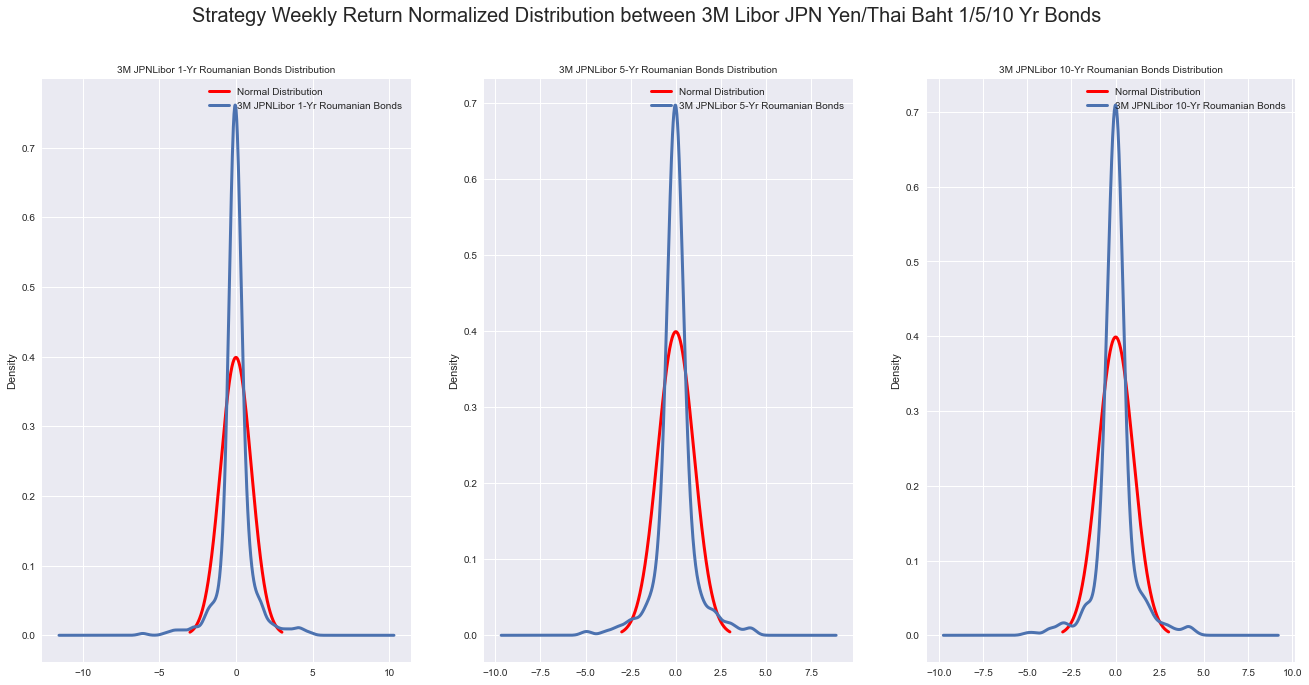

In [113]:
distribution_plot(dfs_port_rou, col_names, 'Log_Returns')

The strategy does seem to exhibit kurtosis for all the maturities duration of the bonds Let's look at the statistics of the distribution now.

In [49]:
moments_dataframe(dfs_port_rou, col_names, 'Log_Returns')

3M JPNLibor 1-Yr Roumanian Bonds  \
Mean                                   0.0033   
Median                                 0.0013   
Std Dev                                0.0429   
1st Quartile                          -0.0089   
3rd Quartile                           0.0139   
Skew                                   0.0114   
Kurtosis                               8.4718   

             3M JPNLibor 5-Yr Roumanian Bonds  \
Mean                                   0.0028   
Median                                 0.0015   
Std Dev                                0.0433   
1st Quartile                           -0.011   
3rd Quartile                           0.0162   
Skew                                  -0.0296   
Kurtosis                               5.9666   

             3M JPNLibor 10-Yr Roumanian Bonds  
Mean                                    0.0033  
Median                                  0.0036  
Std Dev                                 0.0462  
1st Quartile                           -0.0119  
3rd Quartile                            0.0162  
Skew                                    0.0475  
Kurtosis                                6.2928

The kurtosis on each one of them is really high, the rest of the statistical information seems pretty normal with the skew being around 0. 

## 3.4 PnL

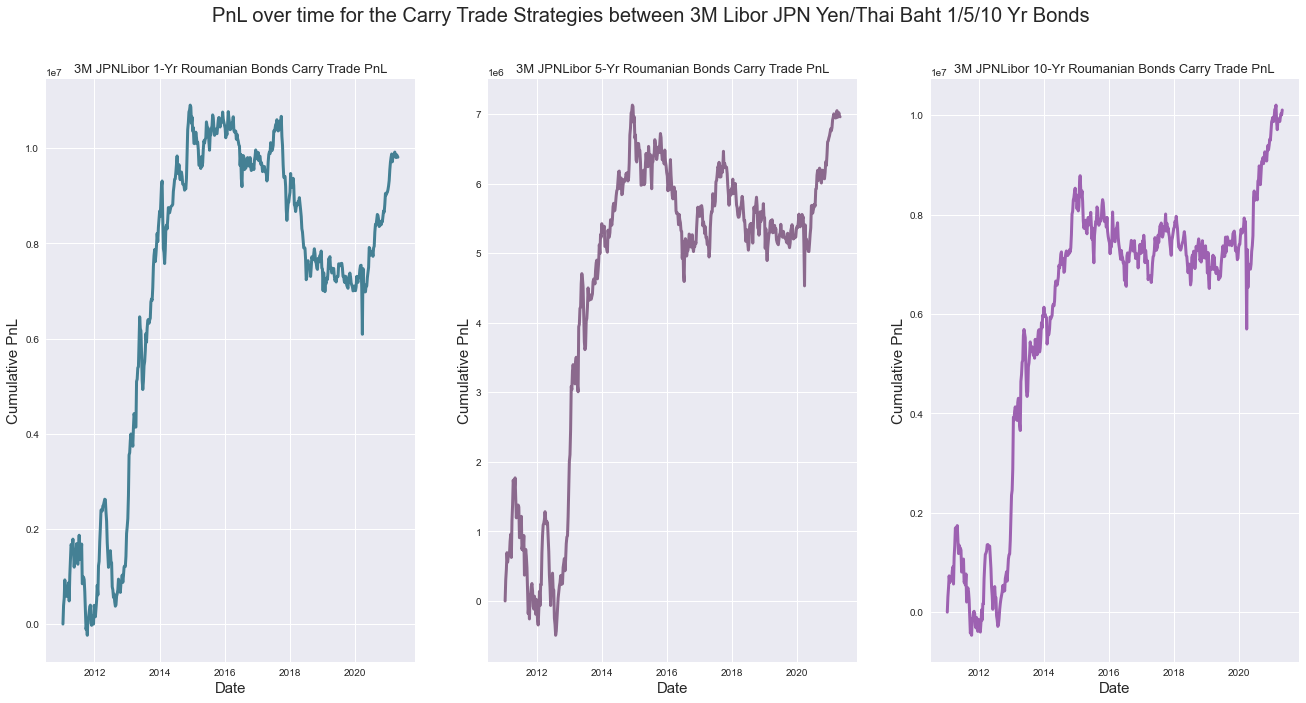

In [50]:
pnl_plots(dfs_port_rou, col_names)

Our strategy looks a lot more like you'd expect iwht a carry trade strategy without any huge catalyst. Most of the gains occured between 2012-2016, then as we previously seen the JPN currency goes against us and the strategy remains flat for a while until 2020 where perhaps an increase in volatility and markets was profitable. 

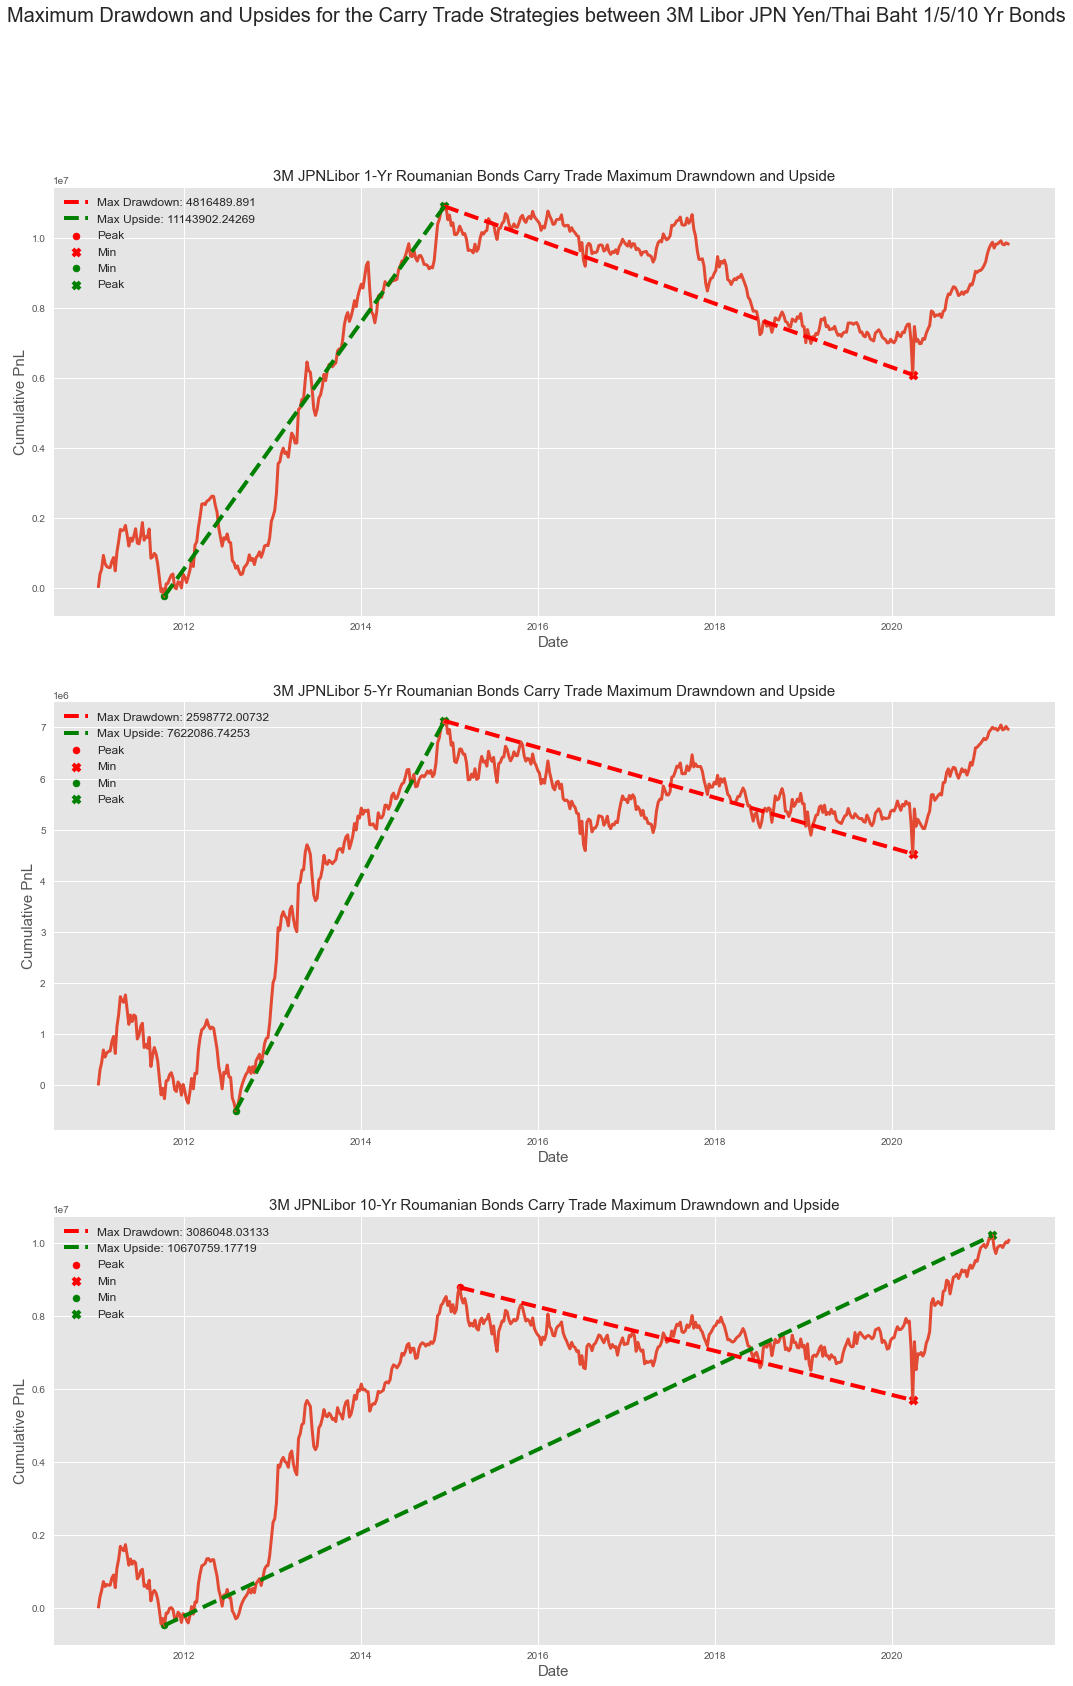

In [51]:
drawdown_plots(dfs_port_rou, col_names)

Very similar in all cases except 10-Yr bonds where the run-up in 2020 was enough to increase the maximum upside well into 2020 and coincide with the max drawdown. 

## 3.5 Period Analysis 2014-2020

Considering that this is the period that coincide with our maximum drawdown, we'll look at the bond valuation and FX rates more closely for that period.

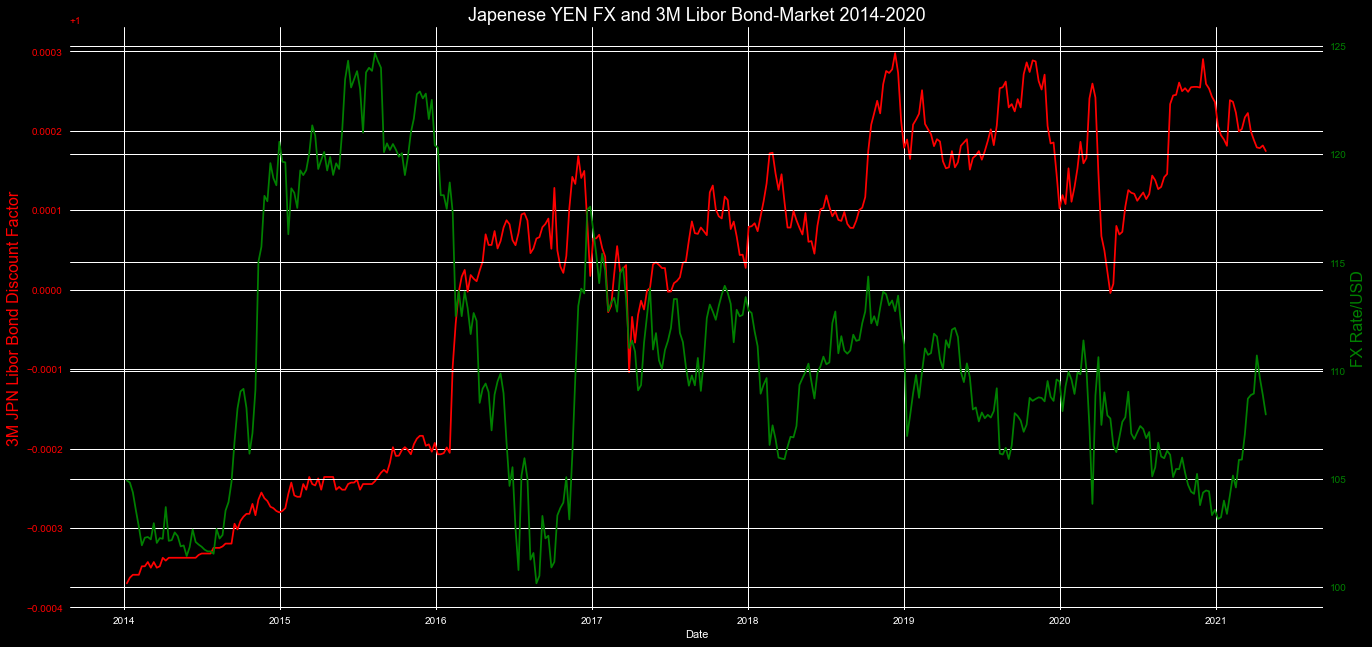

In [115]:
bond_prices_plots(dfs_port_rou[0], 'FX_Rate_Borrow', 'Bond_borrow_open', "Japenese YEN FX and 3M Libor Bond-Market 2014-2020", '3M JPN Libor Bond Discount Factor','2014-01-01')

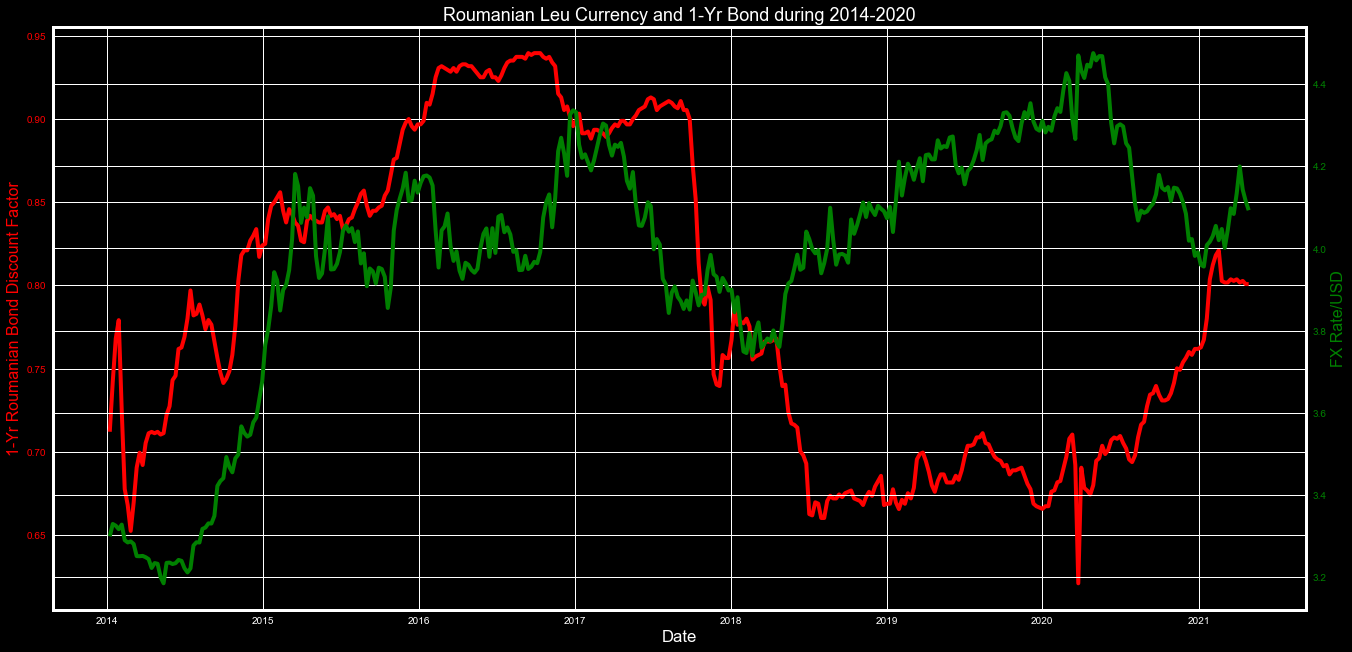

In [53]:
bond_prices_plots(dfs_port_rou[0], 'FX_Rate_Lend', 'Bond_lend_open', "Roumanian Leu Currency and 1-Yr Bond during 2014-2020", "1-Yr Roumanian Bond Discount Factor",'2014-01-01')

The increase in the evaluation of the Roumanian Bonds starting in 2014 well into 2017 countered the effect of decreasing value of the Leu. As for in 2020, we see that while the bonds increased in price the increase in the value of the Leu compared to USD while the Yen was relatively stable both in it's currency and bond evaluation for that period. Big divergence from the currency and bond evaluation in 2018 came back early 2021.

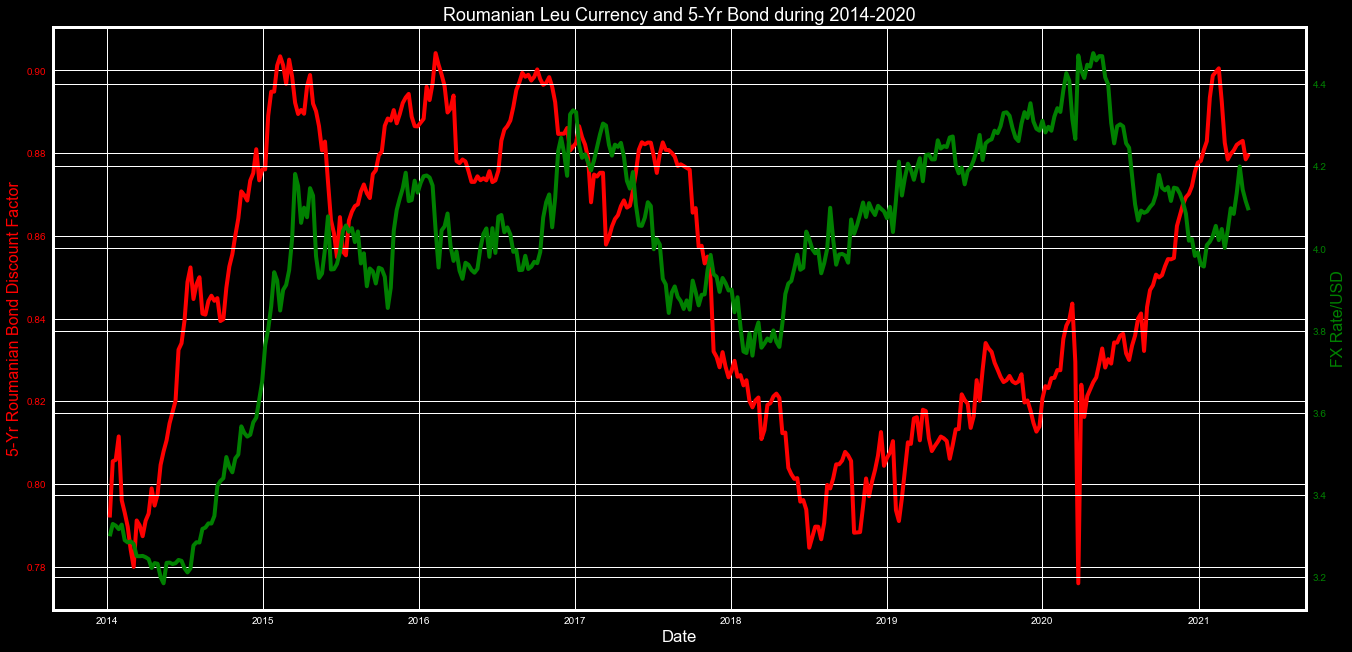

In [54]:
bond_prices_plots(dfs_port_rou[1], 'FX_Rate_Lend', 'Bond_lend_open', "Roumanian Leu Currency and 5-Yr Bond during 2014-2020", "5-Yr Roumanian Bond Discount Factor",'2014-01-01')

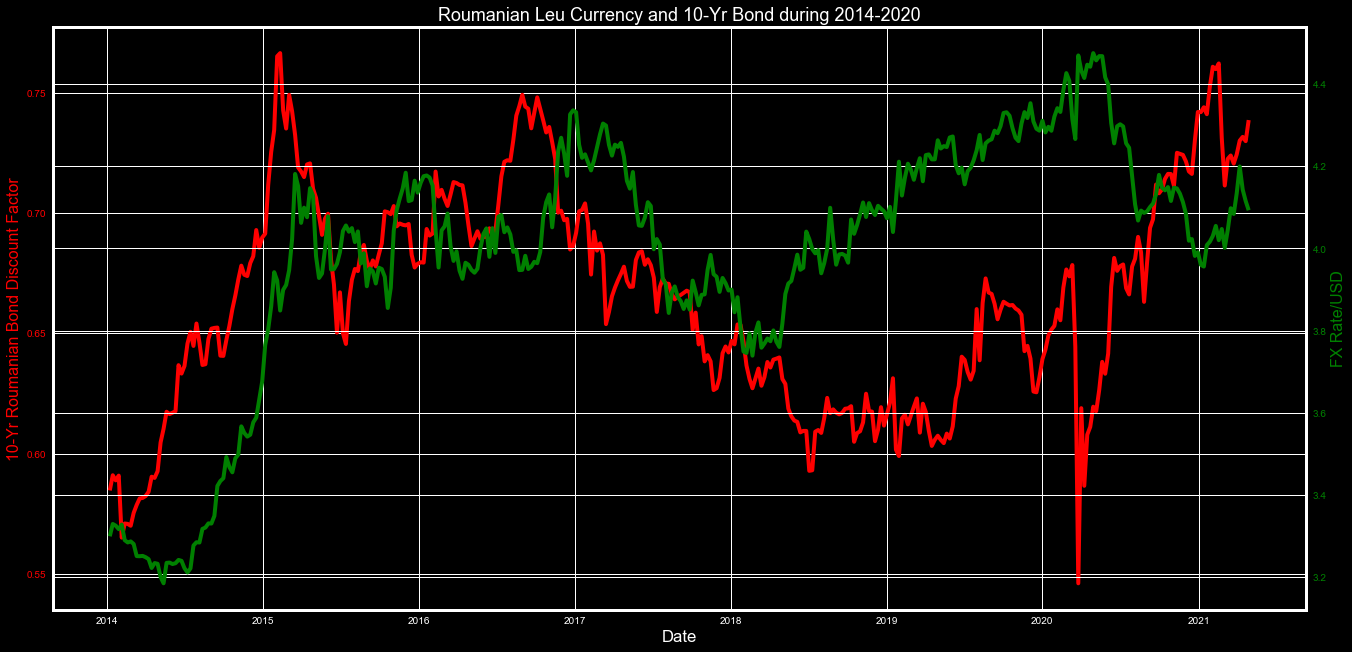

In [55]:
bond_prices_plots(dfs_port_rou[2], 'FX_Rate_Lend', 'Bond_lend_open', "Roumanian Leu Currency and 10-Yr Bond during 2014-2020","10-Yr Roumanian Bond Discount Factor", '2014-01-01')

Similar for the 5-Yr and 10-Yr bonds wiuth some quick change of bond evaluation early 2020. May explain some of the quick gains we made in that period. 

## 3.6 Time-Series Analysis

Let's start by checking the ACF and PACF of the returns of our strategies

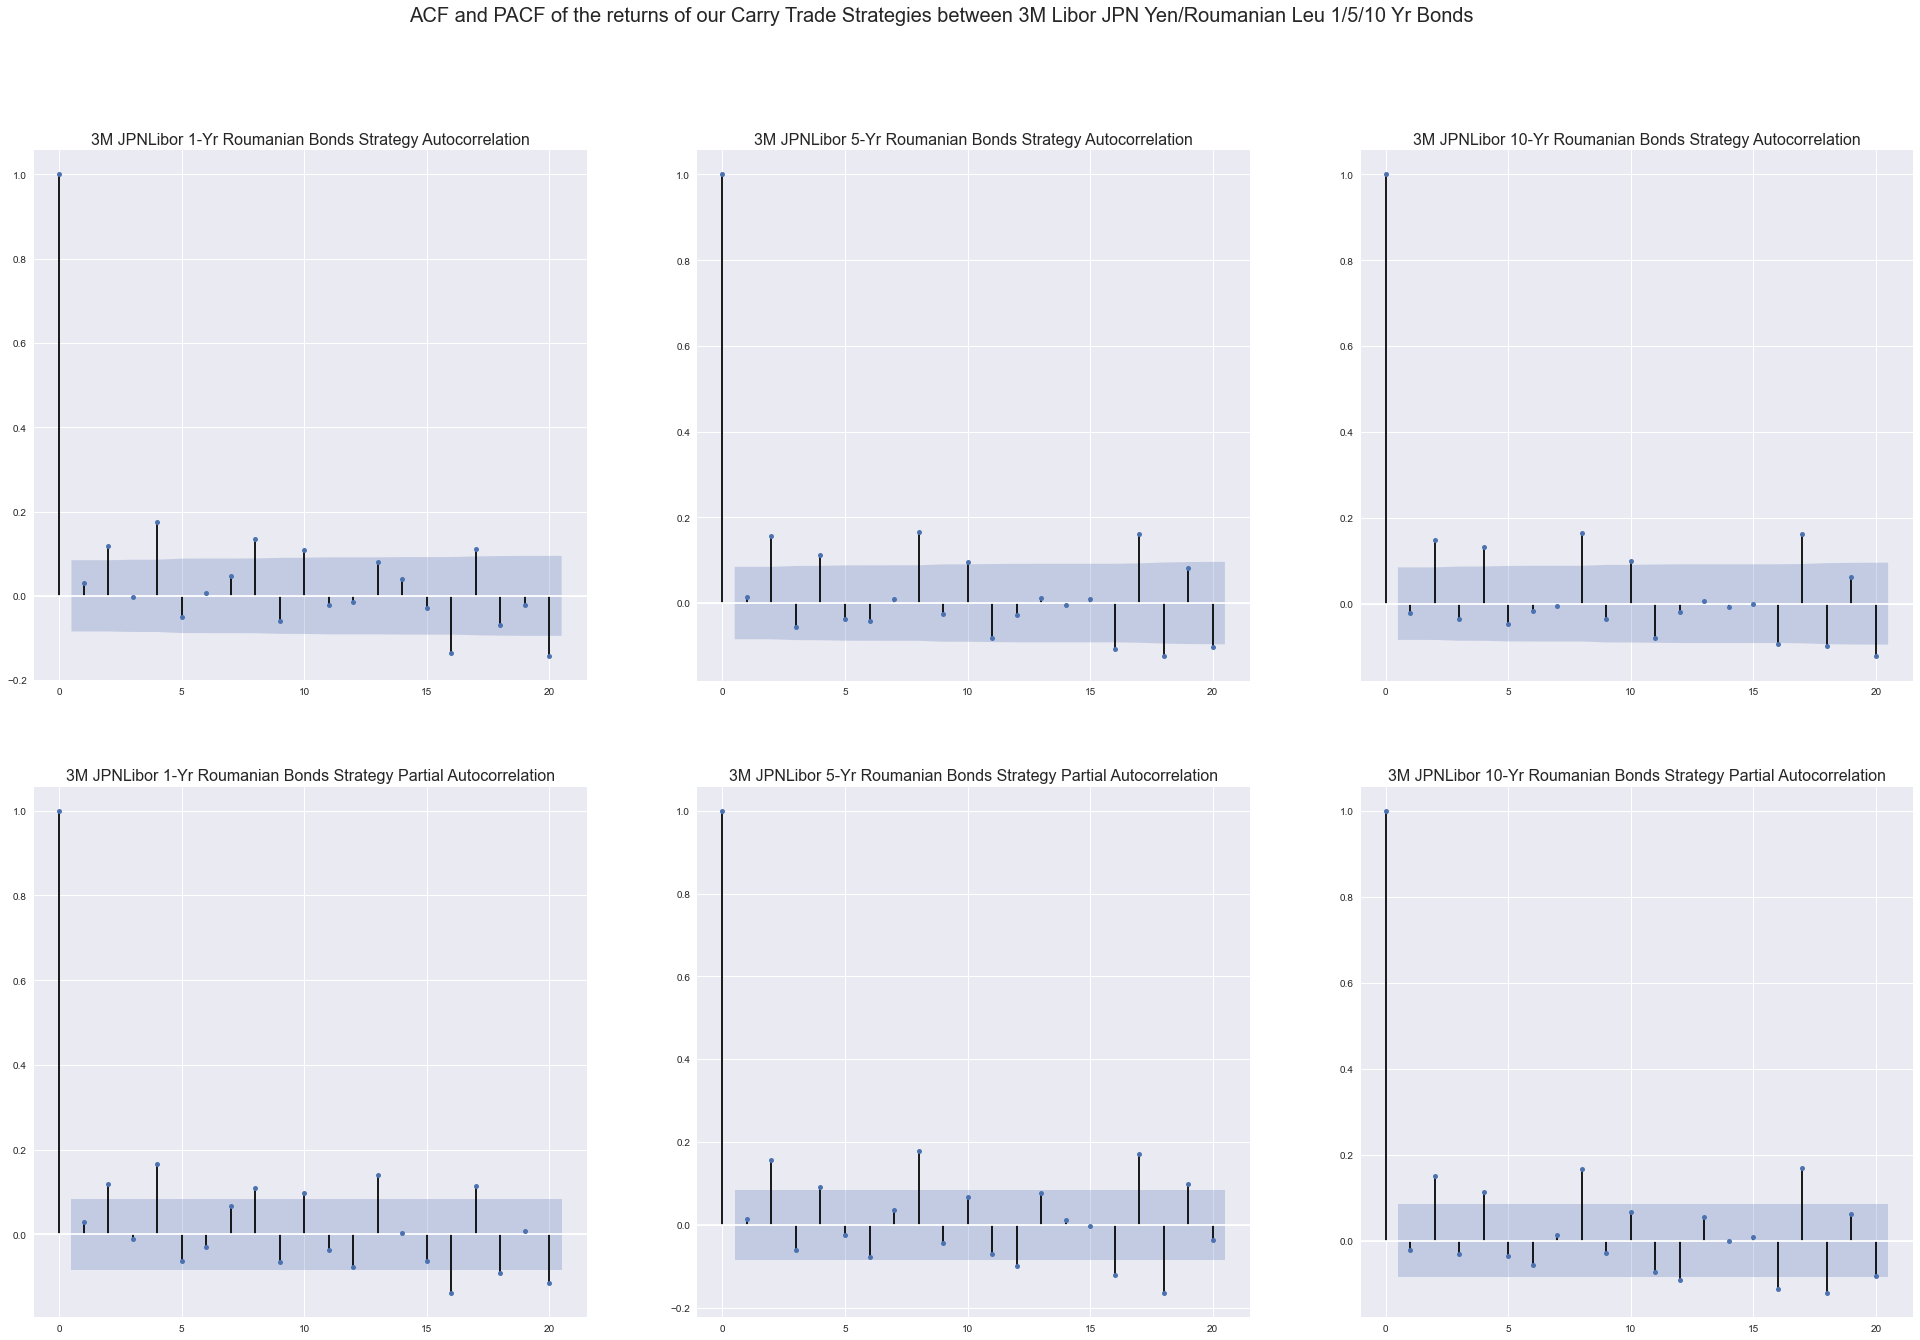

In [117]:
plot_acf_pacf(dfs_port_rou,col_names,'ACF and PACF of the returns of our Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

There doesn't seem to be too anysignificant autocorrelation or partial autocorrelation other than a few outlier, let's run further analysis finding the first few values of PACF using Yule-Walker method. 

In [57]:
yule_walker_pacf_df(dfs_port_rou, col_names, 10)

3M JPNLibor 1-Yr Roumanian Bonds  3M JPNLibor 5-Yr Roumanian Bonds  \
0                             1.0000                            1.0000   
1                             0.0294                            0.0133   
2                             0.1184                            0.1566   
3                            -0.0097                           -0.0610   
4                             0.1661                            0.0925   
5                            -0.0625                           -0.0255   
6                            -0.0291                           -0.0782   
7                             0.0661                            0.0362   
8                             0.1095                            0.1784   
9                            -0.0648                           -0.0445   
10                            0.0979                            0.0670   

    3M JPNLibor 10-Yr Roumanian Bonds  
0                              1.0000  
1                             -0.0220  
2                              0.1493  
3                             -0.0301  
4                              0.1130  
5                             -0.0359  
6                             -0.0559  
7                              0.0123  
8                              0.1661  
9                             -0.0276  
10                             0.0658

In [58]:
adf_df(dfs_port_rou,col_names)

3M JPNLibor 1-Yr Roumanian Bonds 3M JPNLibor 5-Yr Roumanian Bonds  \
p-value                               0.0                              0.0   
ADF Stat                           -5.587                          -4.8668   

         3M JPNLibor 10-Yr Roumanian Bonds  
p-value                                0.0  
ADF Stat                           -5.1395

There doesn't seem to be any patern that could be exploite and the ADF test confirms our assumptions that we cannot reject normality in our returns.

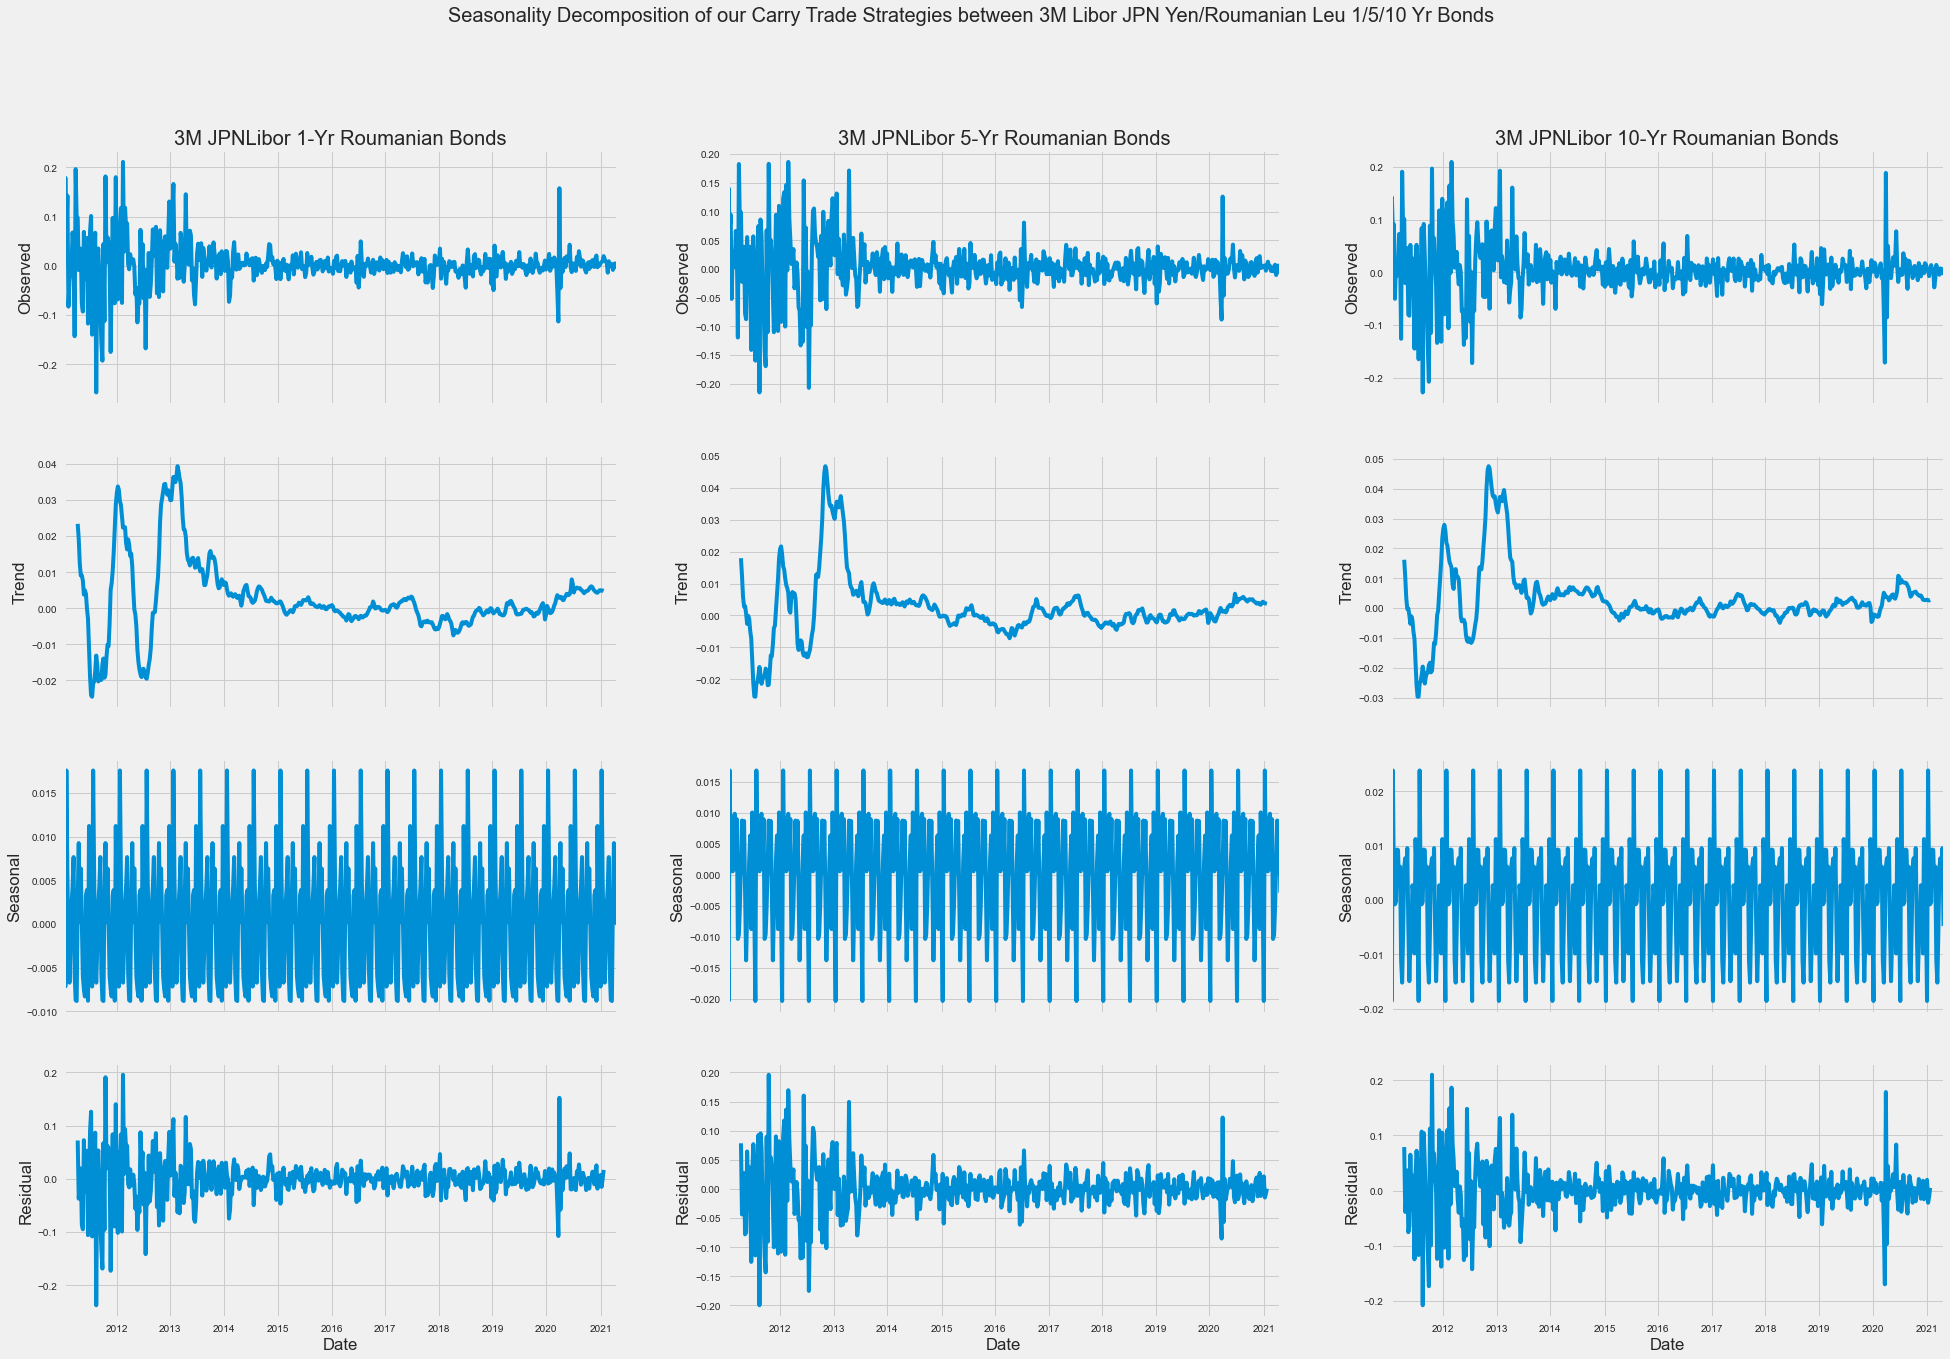

In [119]:
plot_seasonality(dfs_port_rou, col_names, 'Seasonality Decomposition of our Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds', per = 26)

There seem to be some more hectic behavior in the residuals in 2012 up to 2014 where our strategy seemed to perform well. Additionally, if we look at 2020 during the COVID-19 pandemic, there is hectic behavior in the residual again which also coincidence in a bullish moment from our strategy.

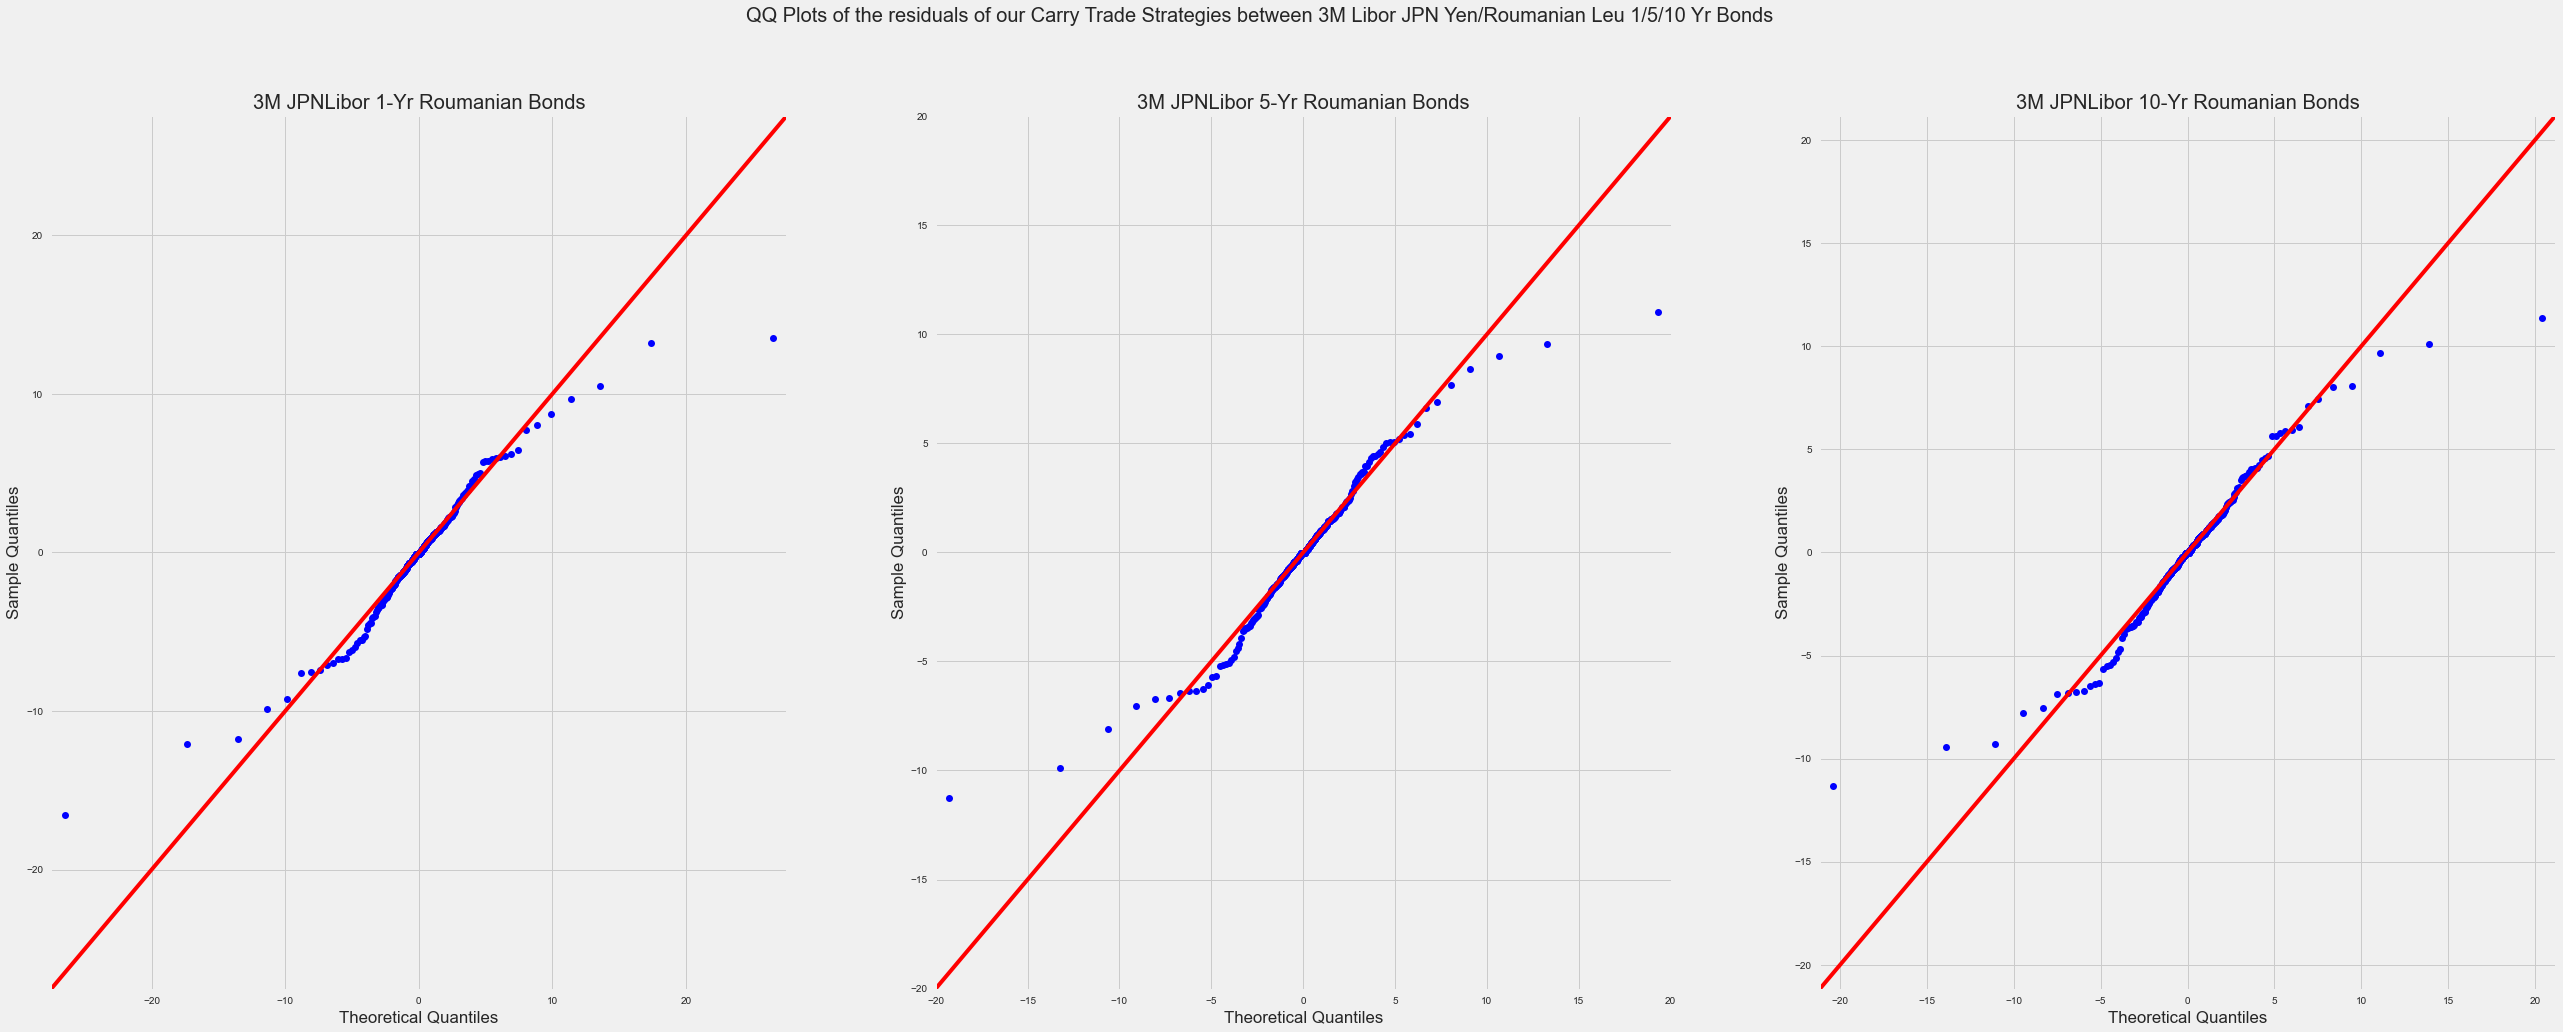

In [60]:
qq_plots(dfs_port_rou,col_names,'QQ Plots of the residuals of our Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds', 26)

Not too surprising considering the high kurtosis of our returns.

## 3.7 Farma-French Regression

In [61]:
ff_dfs = ff_regression(dfs_port_rou, col_names,"Log_Returns")
ff_dfs[0]

3M JPNLibor 1-Yr Roumanian Bonds  3M JPNLibor 5-Yr Roumanian Bonds  \
Factors                                                                       
Mkt-RF                            -0.0429                           -0.0276   
SMB                                0.0099                            0.0117   
HML                               -0.0150                            0.0052   
RF                                -0.0789                           -0.0540   
Ret                                1.0000                            1.0000   
Mkt                               -0.0432                           -0.0278   

         3M JPNLibor 10-Yr Roumanian Bonds  
Factors                                     
Mkt-RF                             -0.0408  
SMB                                 0.0122  
HML                                -0.0154  
RF                                 -0.0555  
Ret                                 1.0000  
Mkt                                -0.0410

Like the Carry Trade with the Thai bonds and FX, our strategy shows very little correlation with Farma-French Factors, let's visualize it.

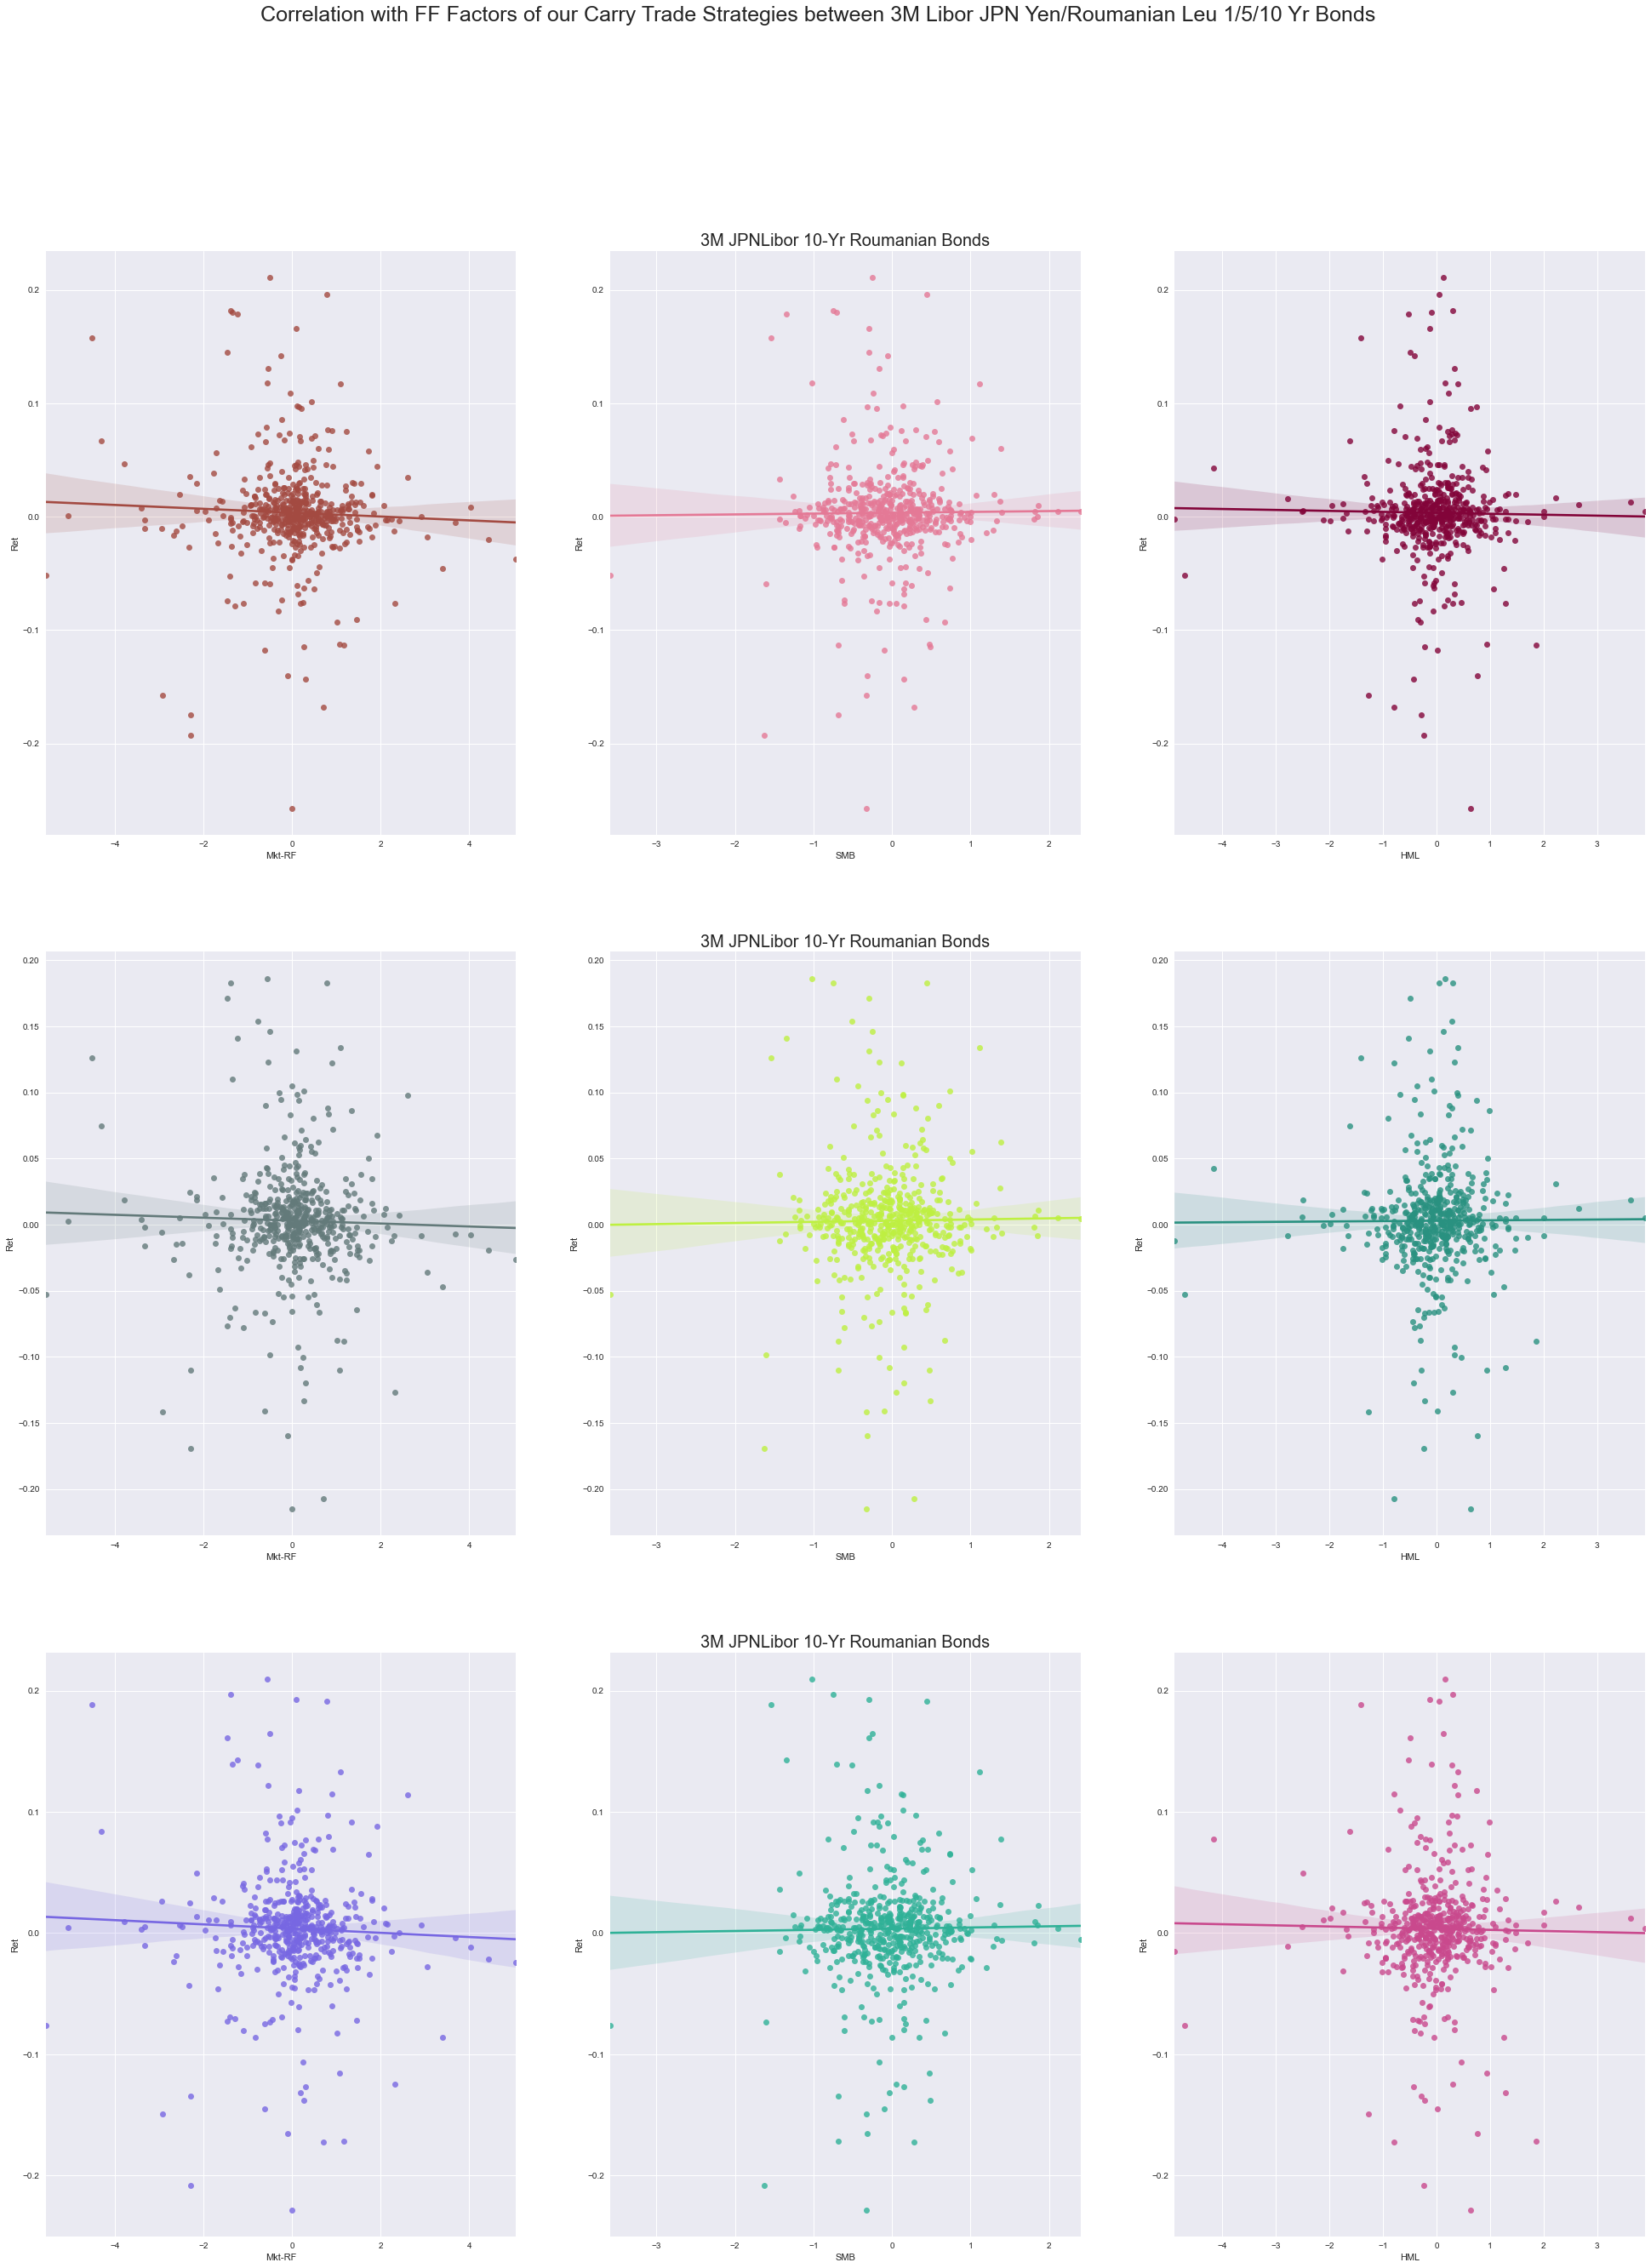

In [62]:
ff_plot(ff_dfs[1], col_names, 'Correlation with FF Factors of our Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

In [63]:
ff_metrics = ff_portfolio_metrics(dfs_port_rou, col_names,"Log_Returns")
ff_metrics[0]

3M JPNLibor 1-Yr Roumanian Bonds  \
Metrics                                           
Sharpe_Ratio                             0.5792   
Sortino_Ratio                            2.3722   
Treynor_Ratio                           -4.2173   

               3M JPNLibor 5-Yr Roumanian Bonds  \
Metrics                                           
Sharpe_Ratio                             0.4908   
Sortino_Ratio                            1.8200   
Treynor_Ratio                           -5.5873   

               3M JPNLibor 10-Yr Roumanian Bonds  
Metrics                                           
Sharpe_Ratio                              0.5501  
Sortino_Ratio                             2.0979  
Treynor_Ratio                            -4.5310

In [64]:
ff_metrics[1]

Downside Beta Regression 3M JPNLibor 1-Yr Roumanian Bonds  \
const                                           5.1421e-03           
Mkt-RF                                          4.0074e-02           
R${^2}$                                         5.0688e-05           

         Downside Beta Regression 3M JPNLibor 5-Yr Roumanian Bonds  \
const                                               0.0044           
Mkt-RF                                              0.1357           
R${^2}$                                             0.0006           

         Downside Beta Regression 3M JPNLibor 10-Yr Roumanian Bonds  
const                                           4.3995e-03           
Mkt-RF                                          2.0080e-02           
R${^2}$                                         1.2057e-05

The Ratios are better than they were in the previous section. The Treynor ratio is high and negative due to the low negative beta of the strategies.The downside beta regression confirms the lack of correlation between our strategy and the market even when downside.

## 3.8 Additional Analysis

We'd expect a wildly different behavior for the leverage over-time for this strategy, mostl likely decreasing over time.

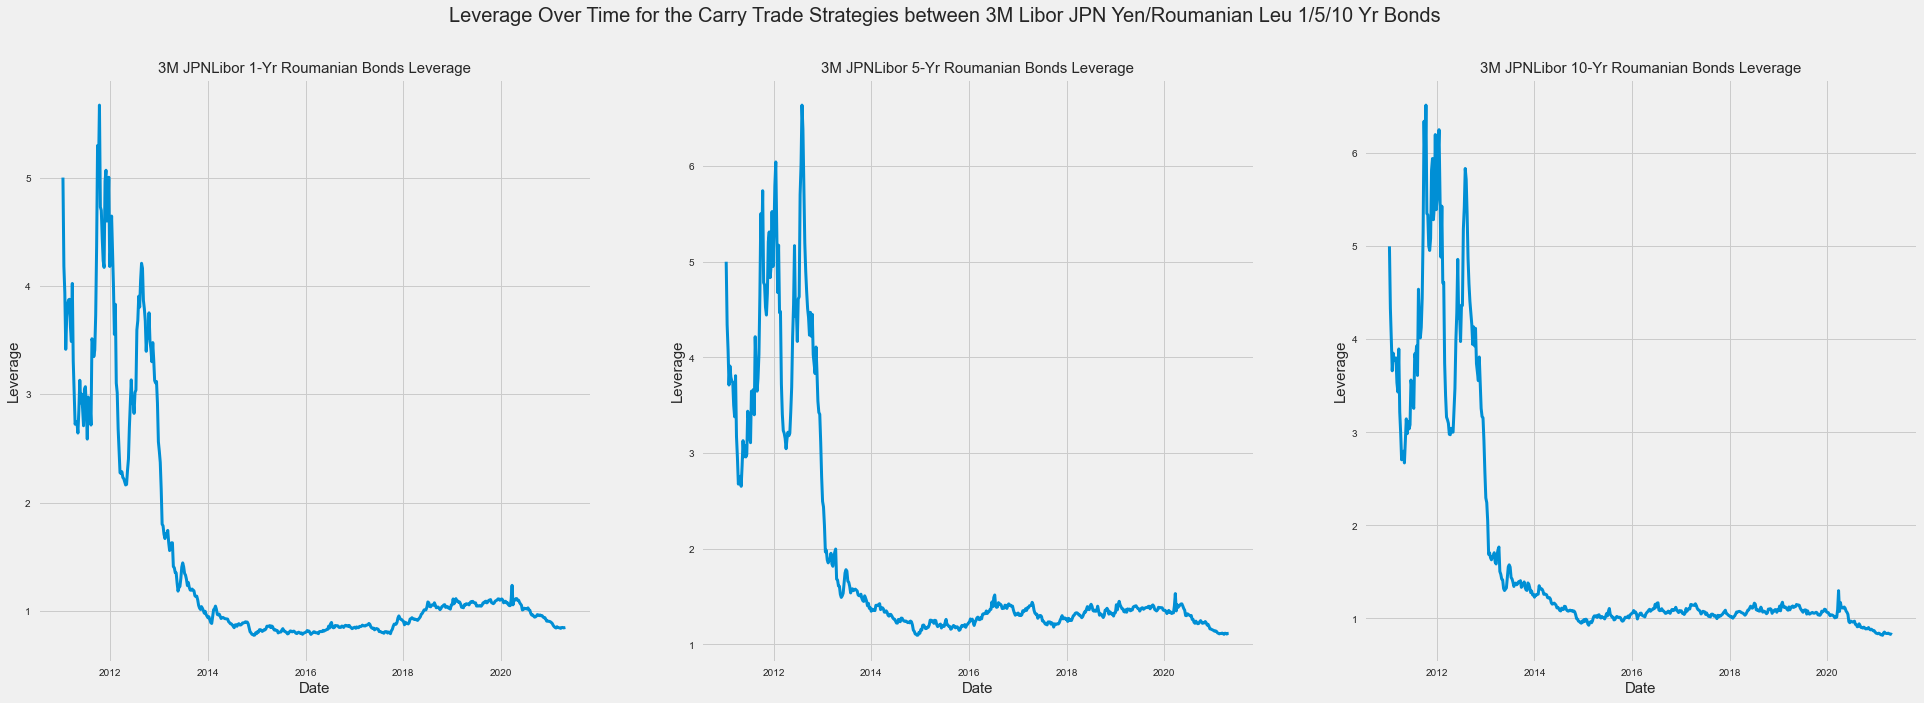

In [120]:
leverage_plots(dfs_port_rou, col_names, 'Leverage Over Time for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

This agrees with our PnL which ends around $\$10$MM USD so we end up with more money than we want to be trading so we're fully utilizing our capital by the end. The next plot shows how many trades were losts (-1) vs wins (+1) when both FX currencies goes against us.

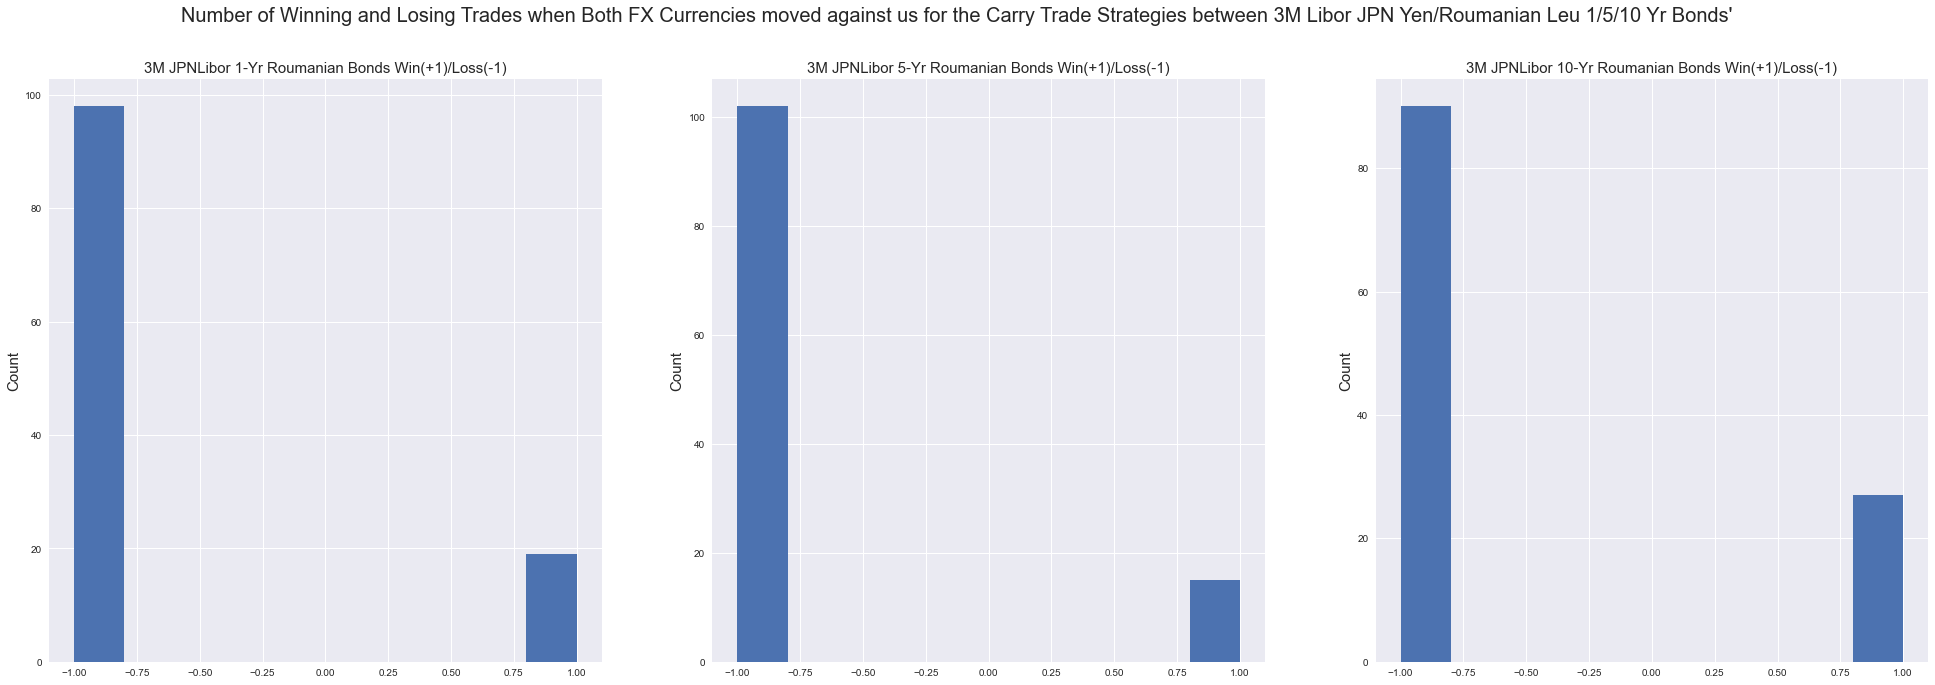

In [122]:
win_lost_vs_FX(dfs_port_rou, col_names, "Number of Winning and Losing Trades when Both FX Currencies moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds'")

Since the strategy seems more stable across maturities, we observe similar behavior here also. Note that when the FX currency goes against us, 

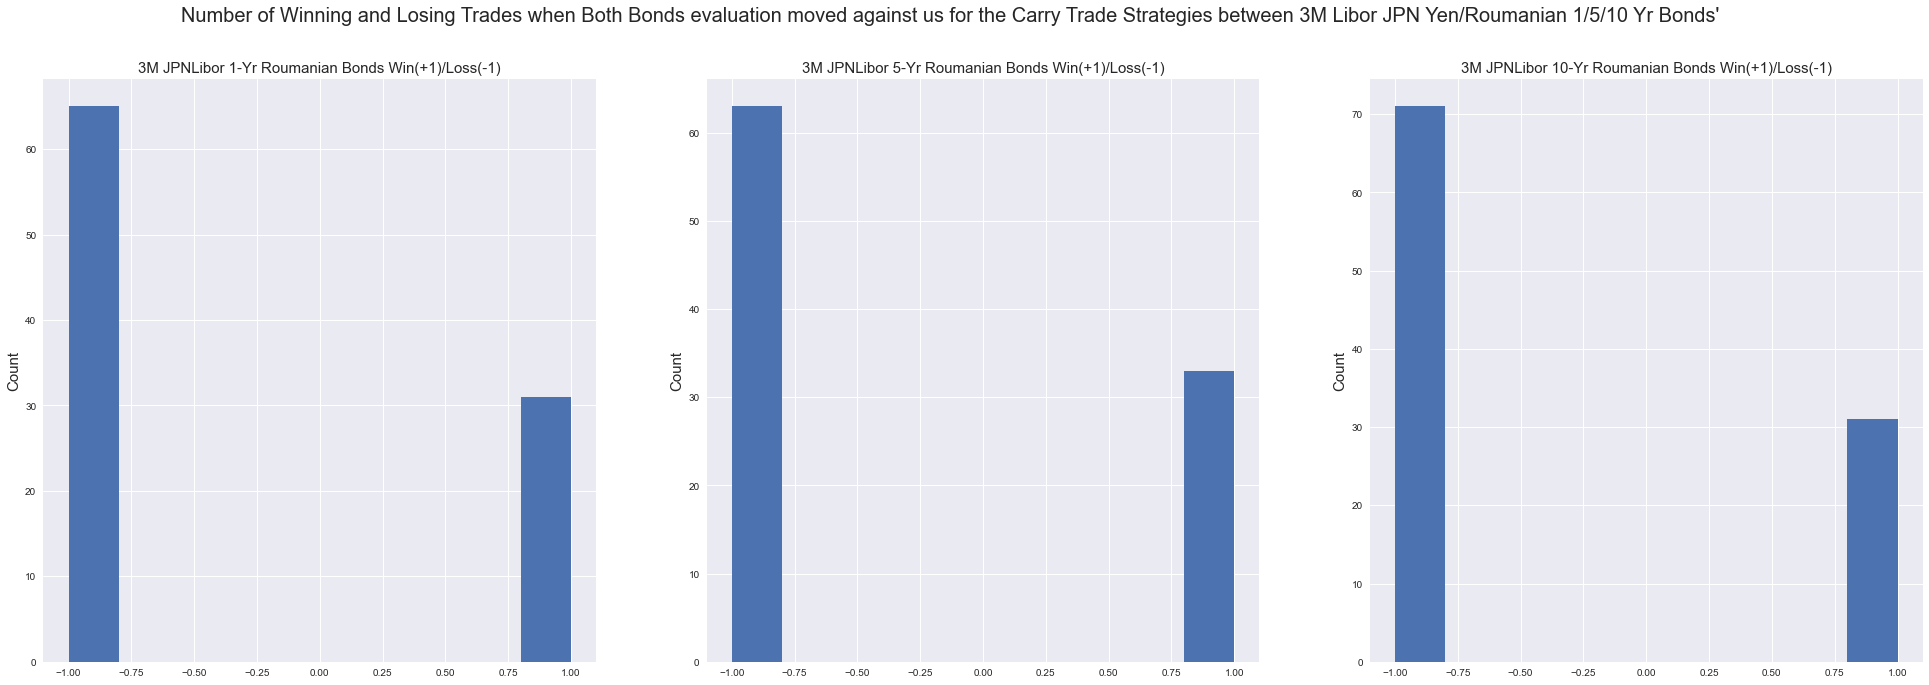

In [67]:
win_lost_vs_bonds(dfs_port_rou, col_names, "Number of Winning and Losing Trades when Both Bonds evaluation moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian 1/5/10 Yr Bonds'")

Compare to thai we still see more loses when the bonds moved against us but we observe more winning trade than the FX part. It definitely seems that over short period, small change in FX rate has greater impact on the returns of the strategy thans bonds.

# 4. Analyzing Indonesian Rupiah vs 3M Libor JPN Yen Carry Trade

We'll analyze three different carry trade strategies, 1Y, 5Y and 10Y for Indonesian Rupiah. I chose three since for each currencies there are at least 3 different Tenor of 1Y+ to analyze for homogeneity and we had the same tenors available for the Thai Baht and Roumanian Leu which could be interesting to compare.

In [68]:
dfs_ind = [df_zcb[4]['1-Year'].to_frame()[df_zcb[4].index < '2021-04-23'],df_zcb[4]['5-Year'].to_frame()[df_zcb[4].index < '2021-04-23'],df_zcb[4]['10-Year'].to_frame()[df_zcb[4].index < '2021-04-23']]

In [69]:
dfs_port_ind = [] 
for i in range(len(dfs_ind)):
    dfs_port_ind.append(carry_trade_simulation(dfs_ind[i], df_jp_3m_libor, df_fx[2], df_fx[3]))

Printing number of null values in dataframe: 
1-Year            0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64
Printing number of null values in dataframe: 
5-Year            0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64
Printing number of null values in dataframe: 
10-Year           0
JPY3MLibor        0
FX_Rate_Borrow    0
FX_Rate_Lend      0
dtype: int64


C:\Users\laure\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 4.1 Bond Prices Statistics

In [70]:
col_names = ['JPN 3M-ZCBond','IND 1Yr-ZCBond', 'IND 5Yr-ZCBond', 'IND 10Yr-ZCBond']
col_data = ['Bond_borrow_open'] + 3*['Bond_lend_open']

bond_moments_dataframe(dfs_port_ind, col_names, col_data)

JPN 3M-ZCBond IND 1Yr-ZCBond IND 5Yr-ZCBond IND 10Yr-ZCBond
Mean                1.0001          0.942         0.7076          0.4807
Median              1.0001         0.9397         0.7083          0.4822
Std Dev             0.0002         0.0105          0.032           0.032
1st Quartile           1.0         0.9352         0.6848          0.4566
3rd Quartile        1.0002         0.9478         0.7275           0.505
Skew               -0.8656          0.858         0.0868         -0.1509
Kurtosis           -0.1562         0.2868        -0.6357         -0.5261

Here we do not notice the same phenomena with really high kurtosis like Thai Bonds for any of them, it seems to be a lot more stable in terms of bond pricing like the Roumanian bonds.

## 4.2 FX Statistics

In [71]:
col_names = ['JPN/YEN FX','IND/RUPIAH FX', 'YEN/RUPIAH Spread']
col_data = ['FX_Rate_Borrow', 'FX_Rate_Lend']

fx_moments_dataframe(dfs_port_ind, col_names, col_data)

JPN/YEN FX IND/RUPIAH FX YEN/RUPIAH Spread
Mean            111.246    13820.0602            0.0081
Median         110.1915    13774.1471            0.0079
Std Dev          5.5192      638.7531            0.0006
1st Quartile   107.4344    13327.0747            0.0076
3rd Quartile   113.4325       14206.7            0.0084
Skew             0.6087        0.4325            0.5644
Kurtosis        -0.2512        0.5313           -0.2773

Again, nothing too distinguishable between the currencies and the spread between them.

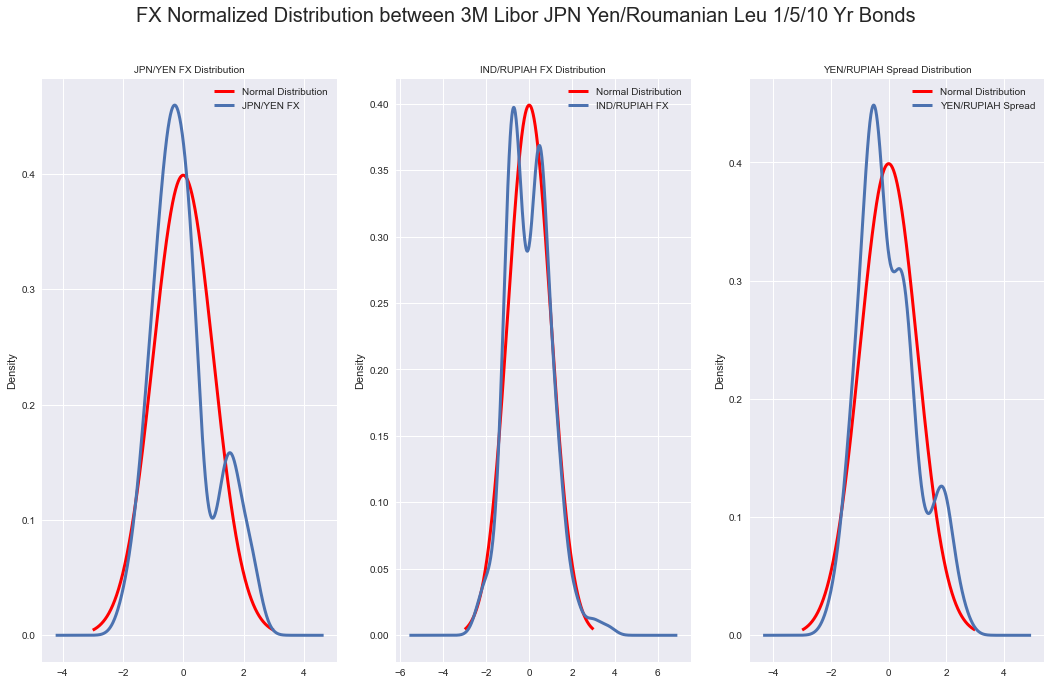

In [72]:
fx_distribution_plot(dfs_port_ind, col_names, col_data, 'FX Normalized Distribution between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

We've already discuss the bimodial nature of a lot of these currencies, not much else to observe here except that in the spread between them we see a third little bump 2 standard deviation off the mean. 

## 4.3 Daily Returns

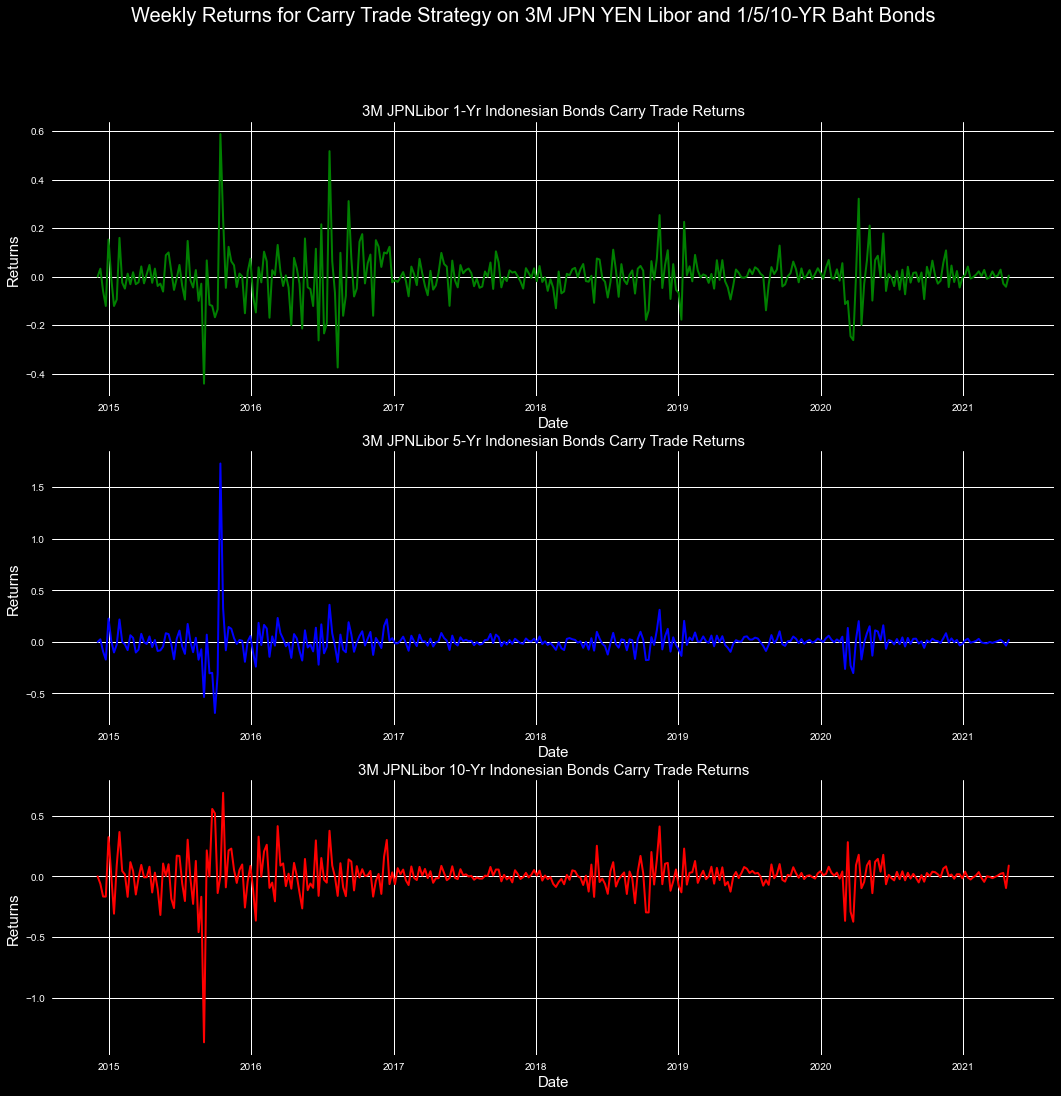

In [124]:
col_names = ["3M JPNLibor "+str(i)+"-Yr Indonesian Bonds" for i in [1,5,10]]
daily_returns_carry_trade(dfs_port_ind, col_names)

In all the cases the returns looks very similar with more hectic behavior around second half of 2015 and the spread of the returns doesn't go astronomical like it did with the Thai currency. We have something that looks a lot more stable in this strategy pair kind of like the Roumanian Leu. 

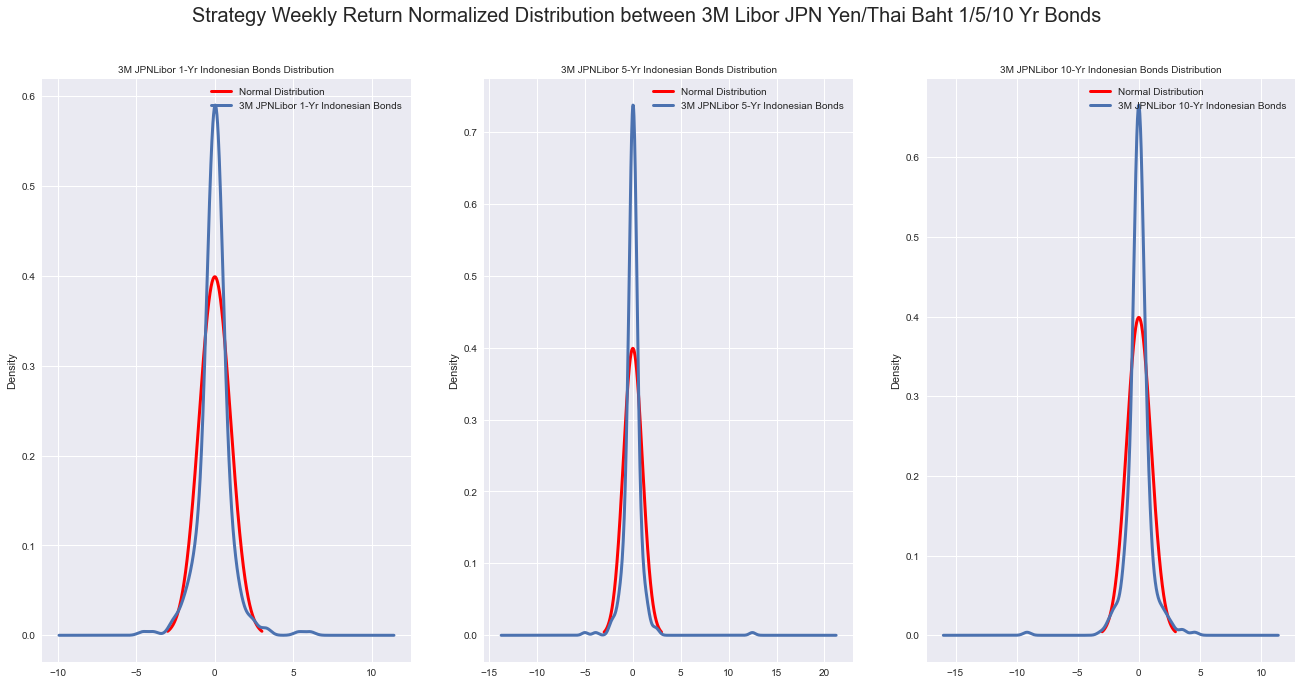

In [126]:
distribution_plot(dfs_port_ind, col_names, 'Log_Returns')

The strategy does seem to exhibit kurtosis for all the maturities duration of the bonds Let's look at the statistics of the distribution now.

In [75]:
moments_dataframe(dfs_port_ind, col_names, 'Log_Returns')

3M JPNLibor 1-Yr Indonesian Bonds  \
Mean                                    0.0016   
Median                                  0.0024   
Std Dev                                 0.0964   
1st Quartile                           -0.0384   
3rd Quartile                            0.0386   
Skew                                     0.695   
Kurtosis                                8.1714   

             3M JPNLibor 5-Yr Indonesian Bonds  \
Mean                                    0.0028   
Median                                  0.0049   
Std Dev                                 0.1384   
1st Quartile                           -0.0347   
3rd Quartile                            0.0367   
Skew                                    5.2375   
Kurtosis                               73.4472   

             3M JPNLibor 10-Yr Indonesian Bonds  
Mean                                     0.0044  
Median                                   0.0038  
Std Dev                                  0.1502  
1st Quartile                            -0.0444  
3rd Quartile                             0.0528  
Skew                                    -1.7701  
Kurtosis                                22.3966

The kurtosis on each one of them is really high. Especially trading the longer maturities bond in these case exhibit an astronomical kurtosis in our case. Interestinging enough the skew on the 5-Yr Indonesian Bonds is also quite positive. Having a look at the PnL might give us more information about the kurtosis.

## 3.4 PnL

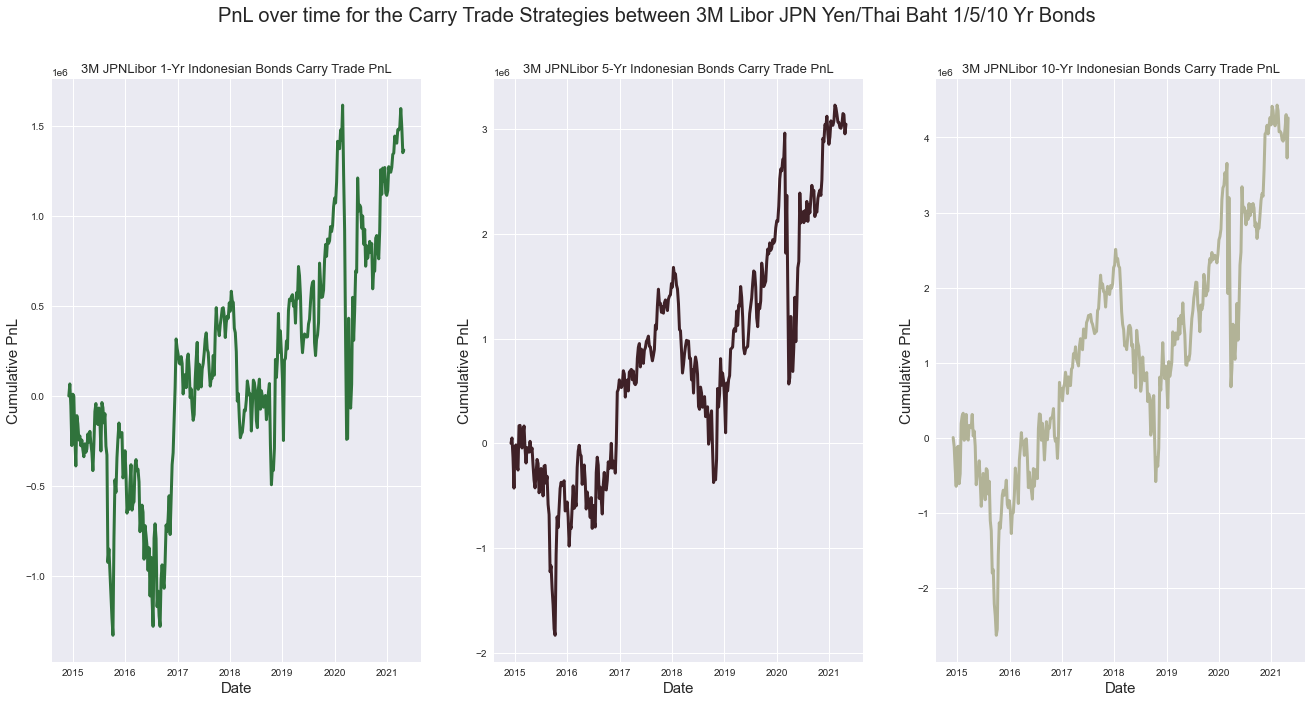

In [76]:
pnl_plots(dfs_port_ind, col_names)

The volatility of the strategy is quite high, in the case of the 10-Yr Bonds we end up blowing our account and then finish by doubling what we initially started with. The strategy seems to be exhibiting periods of high gains and high losts. Not ideal for someone looking for robust steady gains.

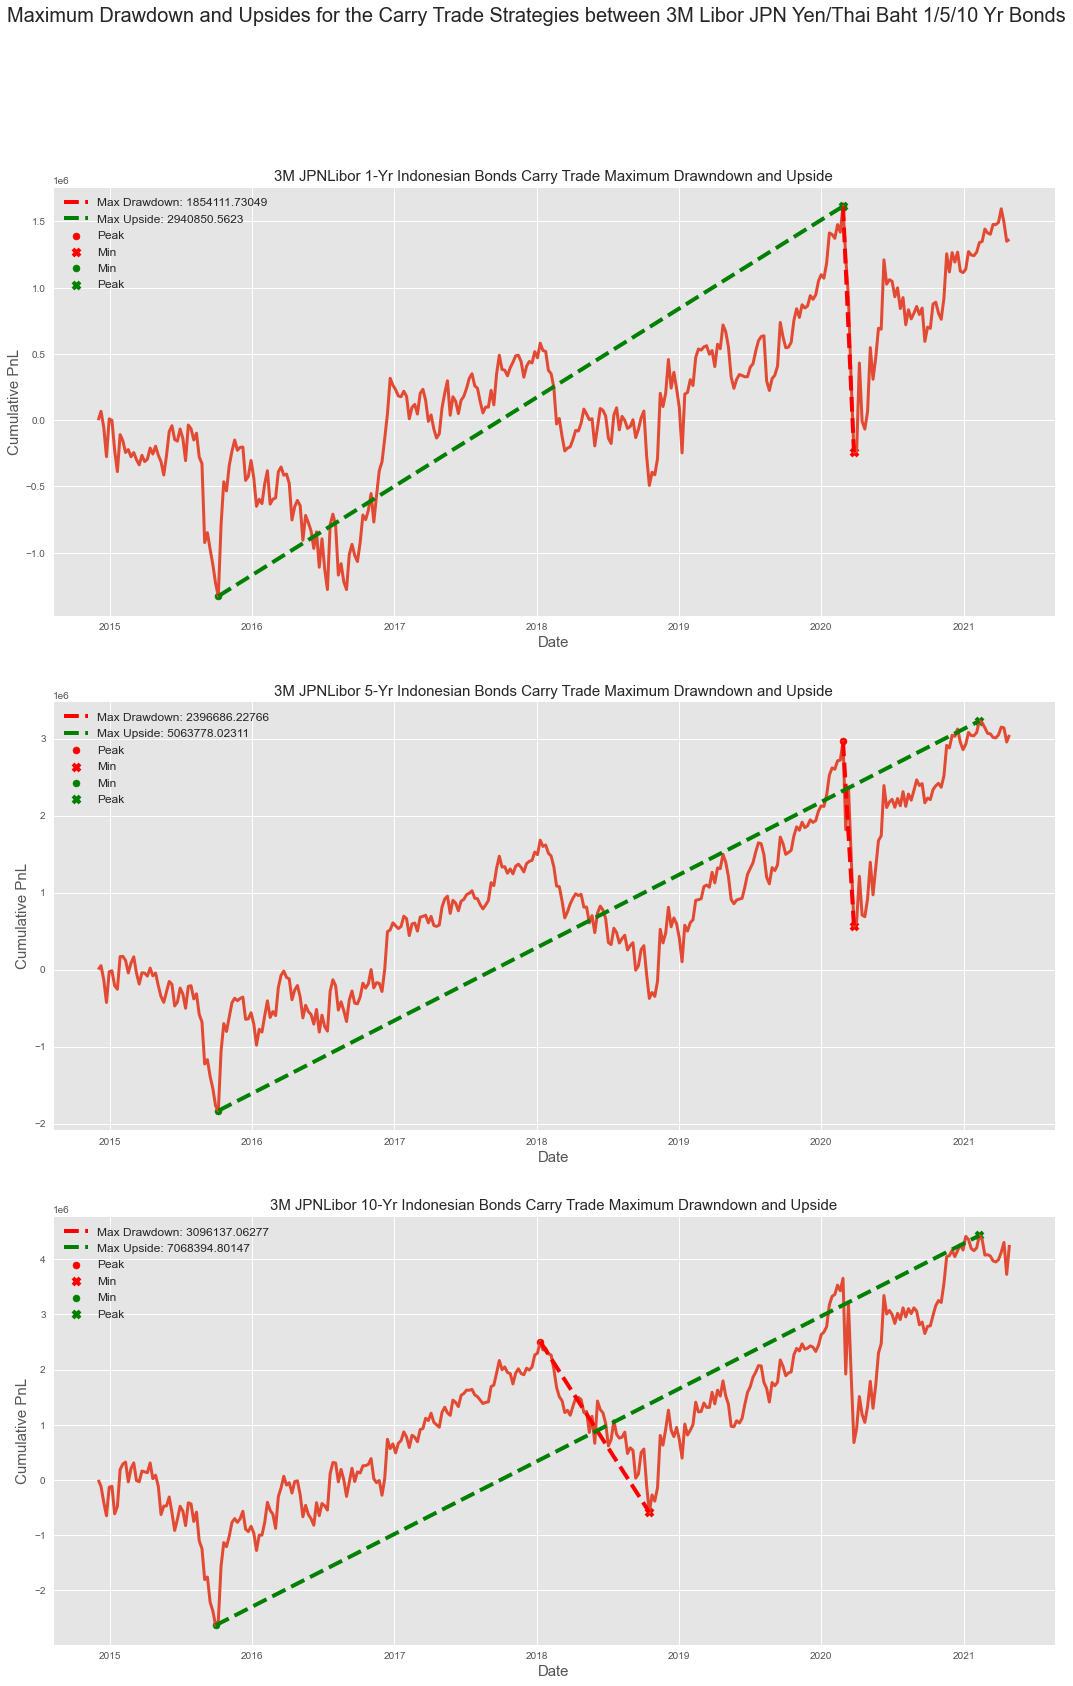

In [77]:
drawdown_plots(dfs_port_ind, col_names)

The high volatility of the strategy shows here. This is the first time that the period of maximum drawdown is not the same for a given currency since there are a couple of periods where the drawdown is close to each other and they seem regular enough to be a worry. Let's pay more attention to the period of 2017-2020 where we see an increasing period and decreasing period. 


## 4.5 Period Analysis 2017 2020

Considering that this is the period that coincide with our maximum drawdown, we'll look at the bond valuation and FX rates more closely for that period.

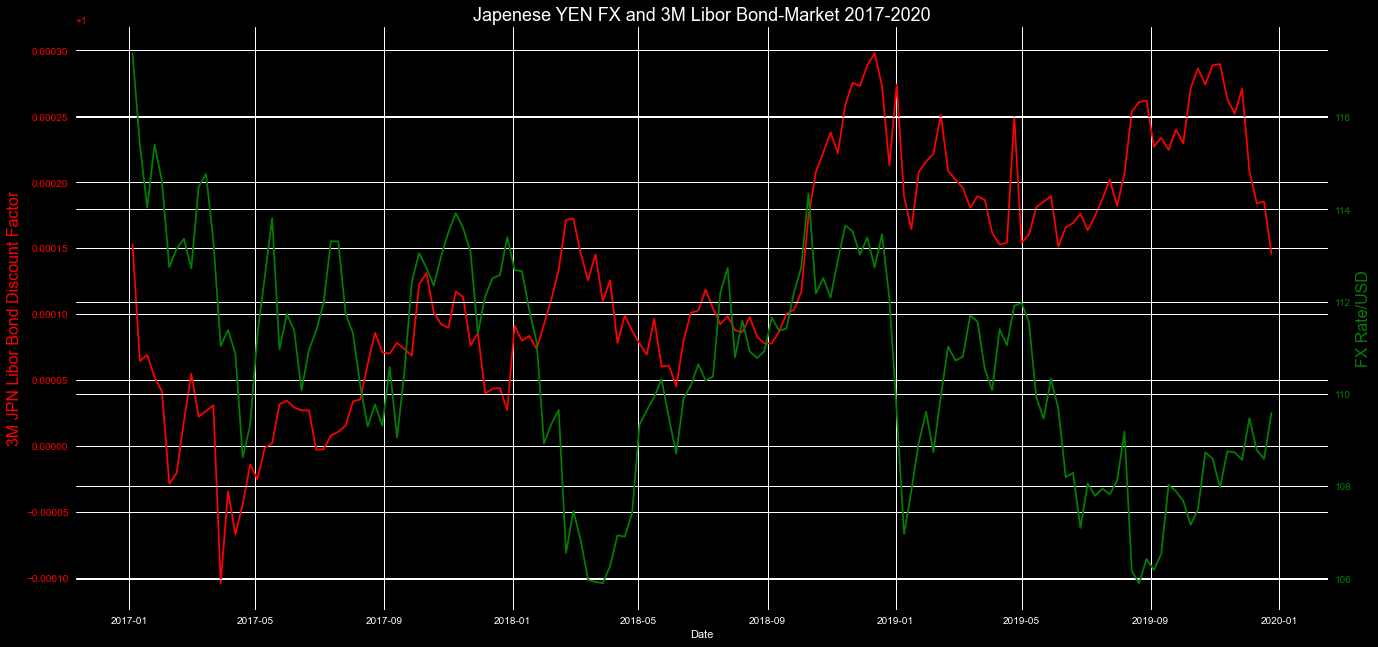

In [128]:
bond_prices_plots(dfs_port_ind[0], 'FX_Rate_Borrow', 'Bond_borrow_open', "Japenese YEN FX and 3M Libor Bond-Market 2017-2020", '3M JPN Libor Bond Discount Factor','2017-01-01', '2020-01-01')

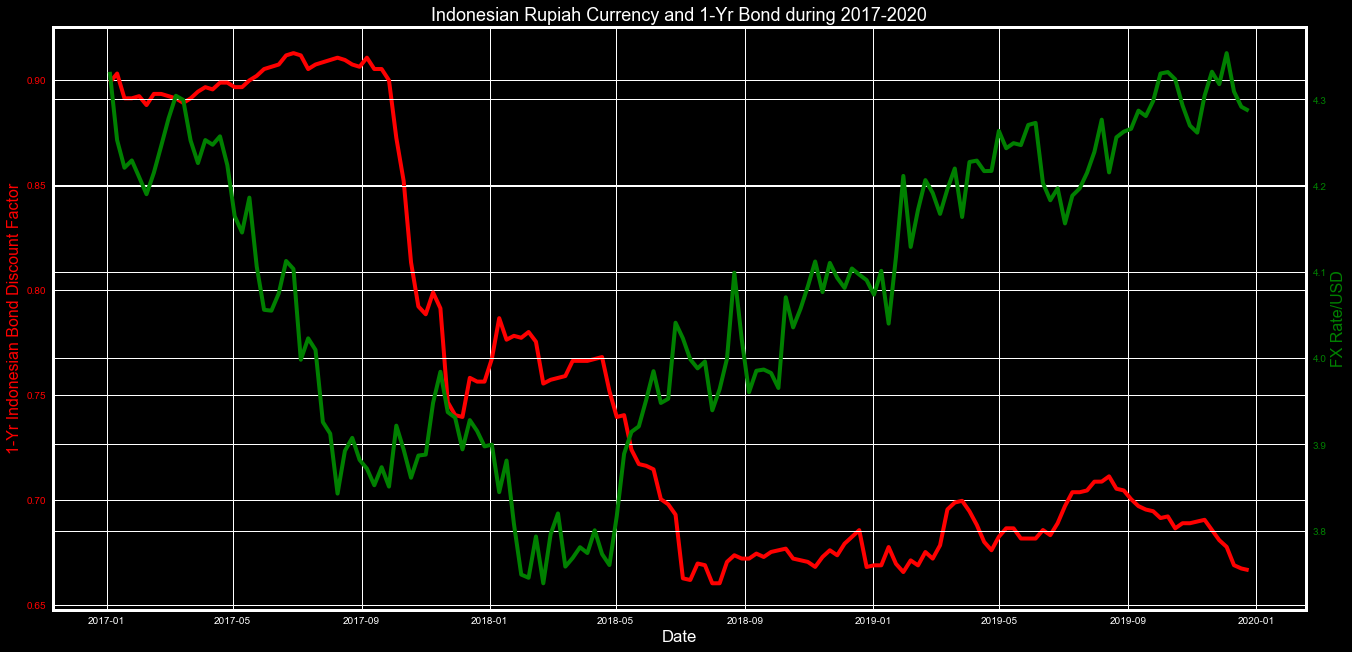

In [79]:
bond_prices_plots(dfs_port_rou[0], 'FX_Rate_Lend', 'Bond_lend_open', "Indonesian Rupiah Currency and 1-Yr Bond during 2017-2020", "1-Yr Indonesian Bond Discount Factor",'2017-01-01', '2020-01-01')

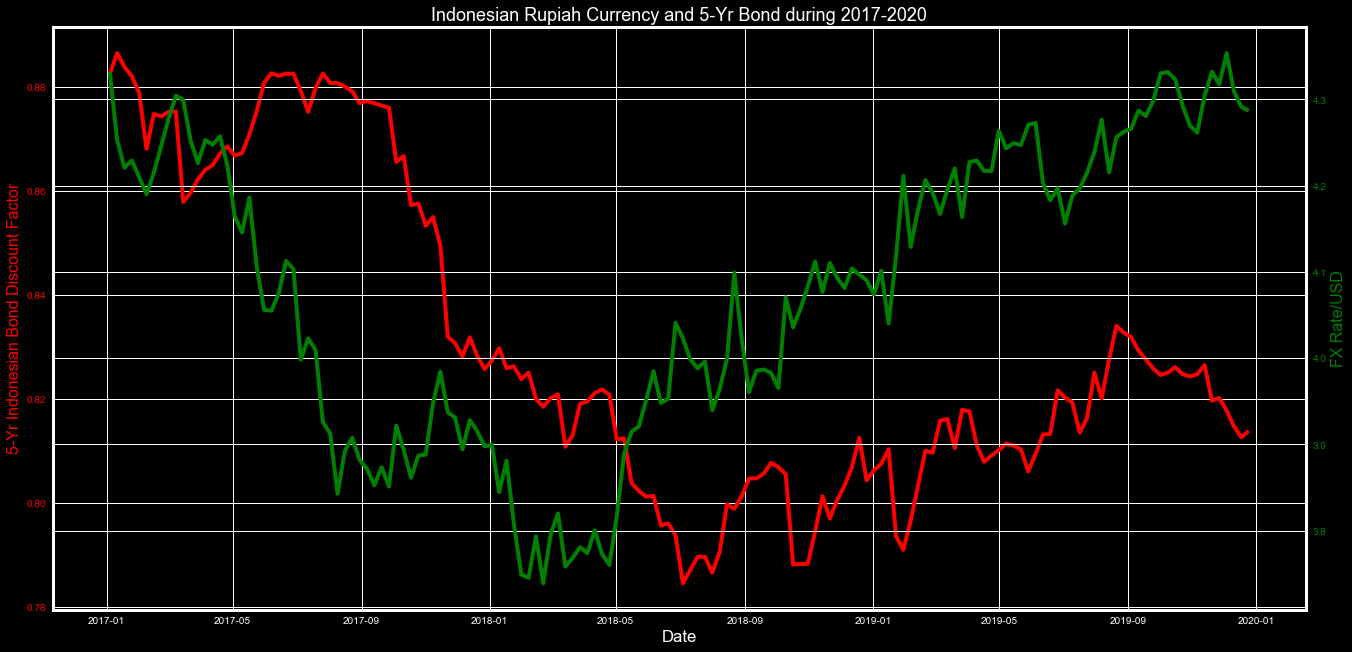

In [80]:
bond_prices_plots(dfs_port_rou[1], 'FX_Rate_Lend', 'Bond_lend_open',"Indonesian Rupiah Currency and 5-Yr Bond during 2017-2020", "5-Yr Indonesian Bond Discount Factor",'2017-01-01', '2020-01-01')

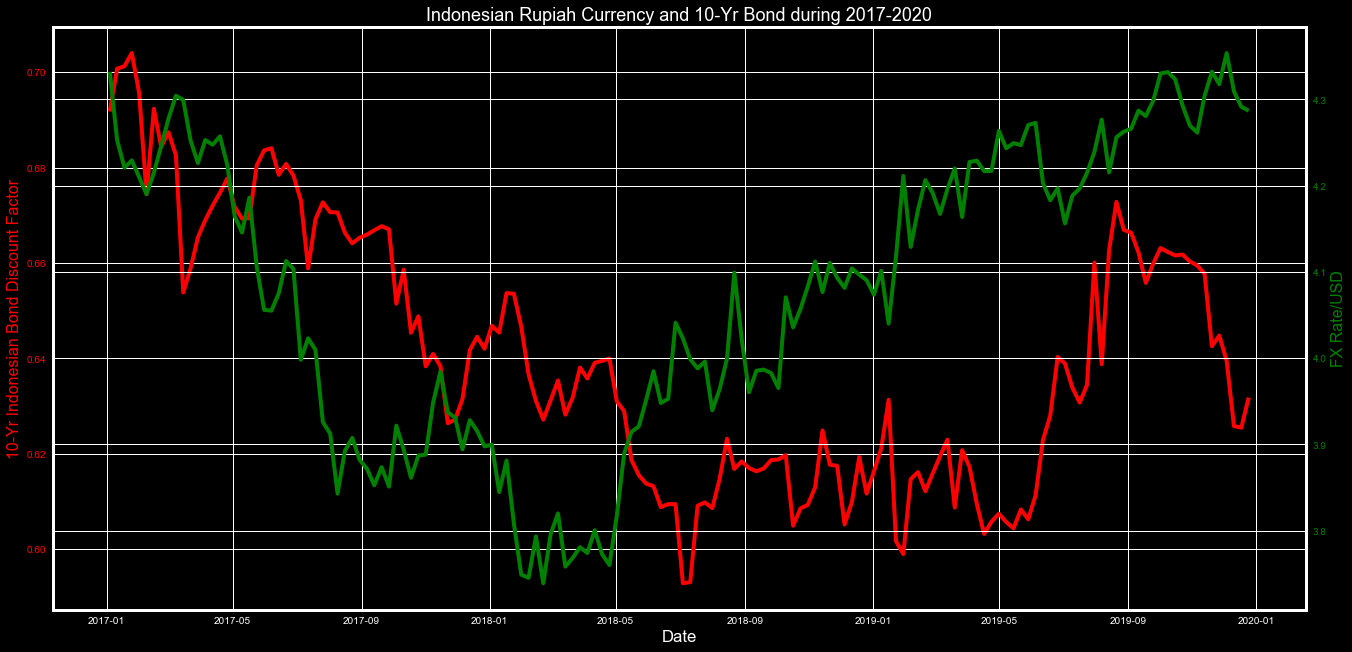

In [81]:
bond_prices_plots(dfs_port_rou[2], 'FX_Rate_Lend', 'Bond_lend_open', "Indonesian Rupiah Currency and 10-Yr Bond during 2017-2020", "10-Yr Indonesian Bond Discount Factor",'2017-01-01', '2020-01-01')

For this trade the period where the value of the lending bond was decreasing while the local currency was also decreasing are periods where our strategy lost the most amount of money. This goes in contrast to the other strategies and our intuition that buying back the bond cheaper should be increasing our PnL. There might be some market structure happening at at scale that are not visible here that eludes us. 

## 4.6 Time-Series Analysis

Let's start by checking the ACF and PACF of the returns of our strategies

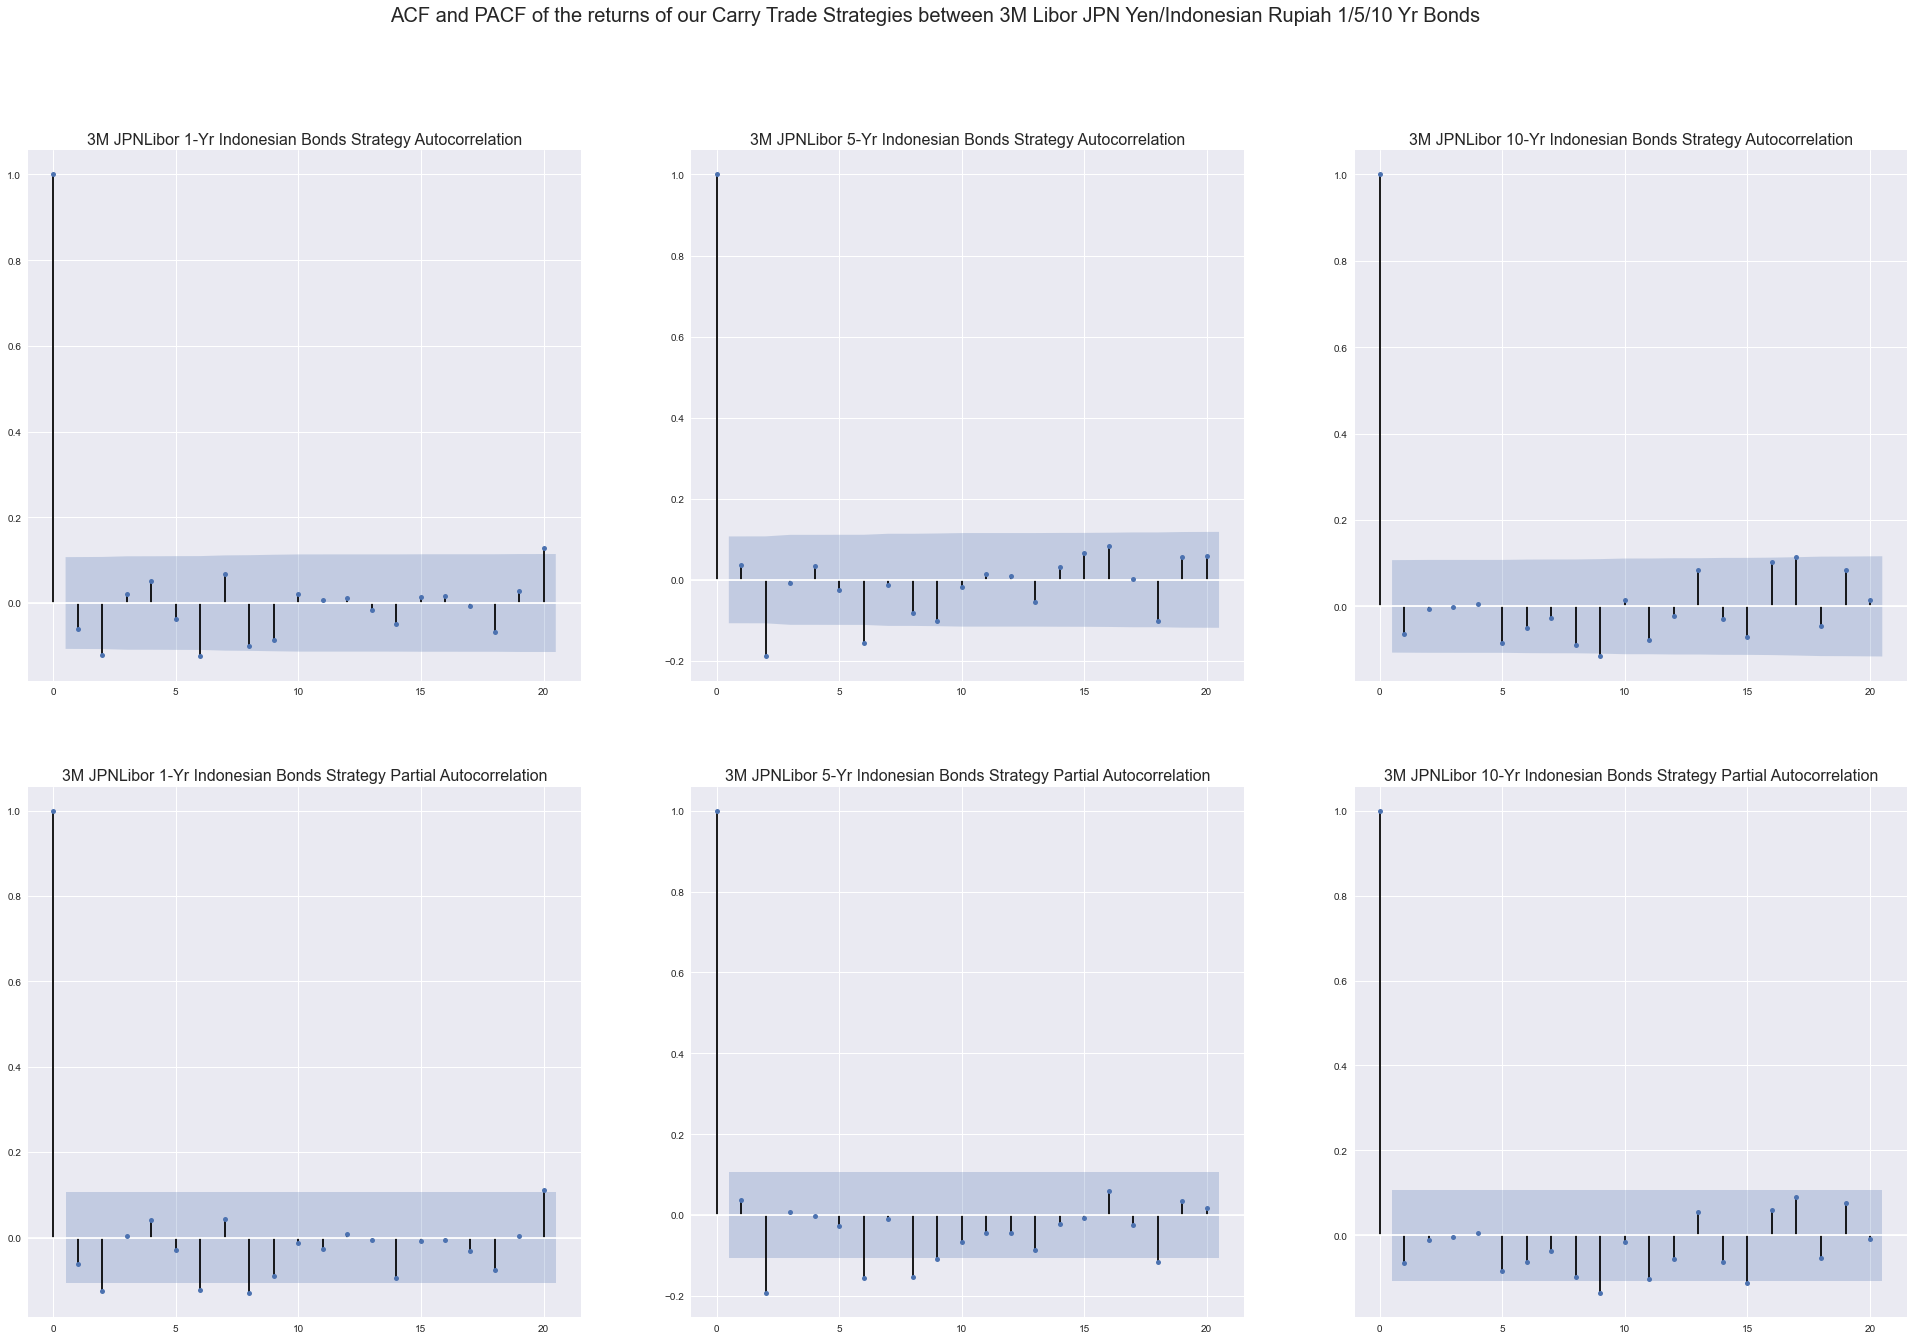

In [130]:
plot_acf_pacf(dfs_port_ind,col_names,'ACF and PACF of the returns of our Carry Trade Strategies between 3M Libor JPN Yen/Indonesian Rupiah 1/5/10 Yr Bonds')

There doesn't seem to be too anysignificant autocorrelation or partial autocorrelation other than a few outlier, let's run further analysis finding the first few values of PACF using Yule-Walker method. 

In [83]:
yule_walker_pacf_df(dfs_port_ind, col_names, 10)

3M JPNLibor 1-Yr Indonesian Bonds  3M JPNLibor 5-Yr Indonesian Bonds  \
0                              1.0000                             1.0000   
1                             -0.0619                             0.0372   
2                             -0.1256                            -0.1919   
3                              0.0047                             0.0070   
4                              0.0403                            -0.0030   
5                             -0.0288                            -0.0274   
6                             -0.1232                            -0.1565   
7                              0.0445                            -0.0098   
8                             -0.1293                            -0.1531   
9                             -0.0903                            -0.1094   
10                            -0.0118                            -0.0660   

    3M JPNLibor 10-Yr Indonesian Bonds  
0                               1.0000  
1                              -0.0650  
2                              -0.0102  
3                              -0.0031  
4                               0.0050  
5                              -0.0847  
6                              -0.0619  
7                              -0.0365  
8                              -0.0982  
9                              -0.1352  
10                             -0.0167

In [84]:
adf_df(dfs_port_ind,col_names)

3M JPNLibor 1-Yr Indonesian Bonds 3M JPNLibor 5-Yr Indonesian Bonds  \
p-value                                0.0                               0.0   
ADF Stat                          -15.0067                            -8.649   

         3M JPNLibor 10-Yr Indonesian Bonds  
p-value                                 0.0  
ADF Stat                           -19.4347

There doesn't seem to be any patern that could be exploite and the ADF test confirms our assumptions that we cannot reject normality in our returns.

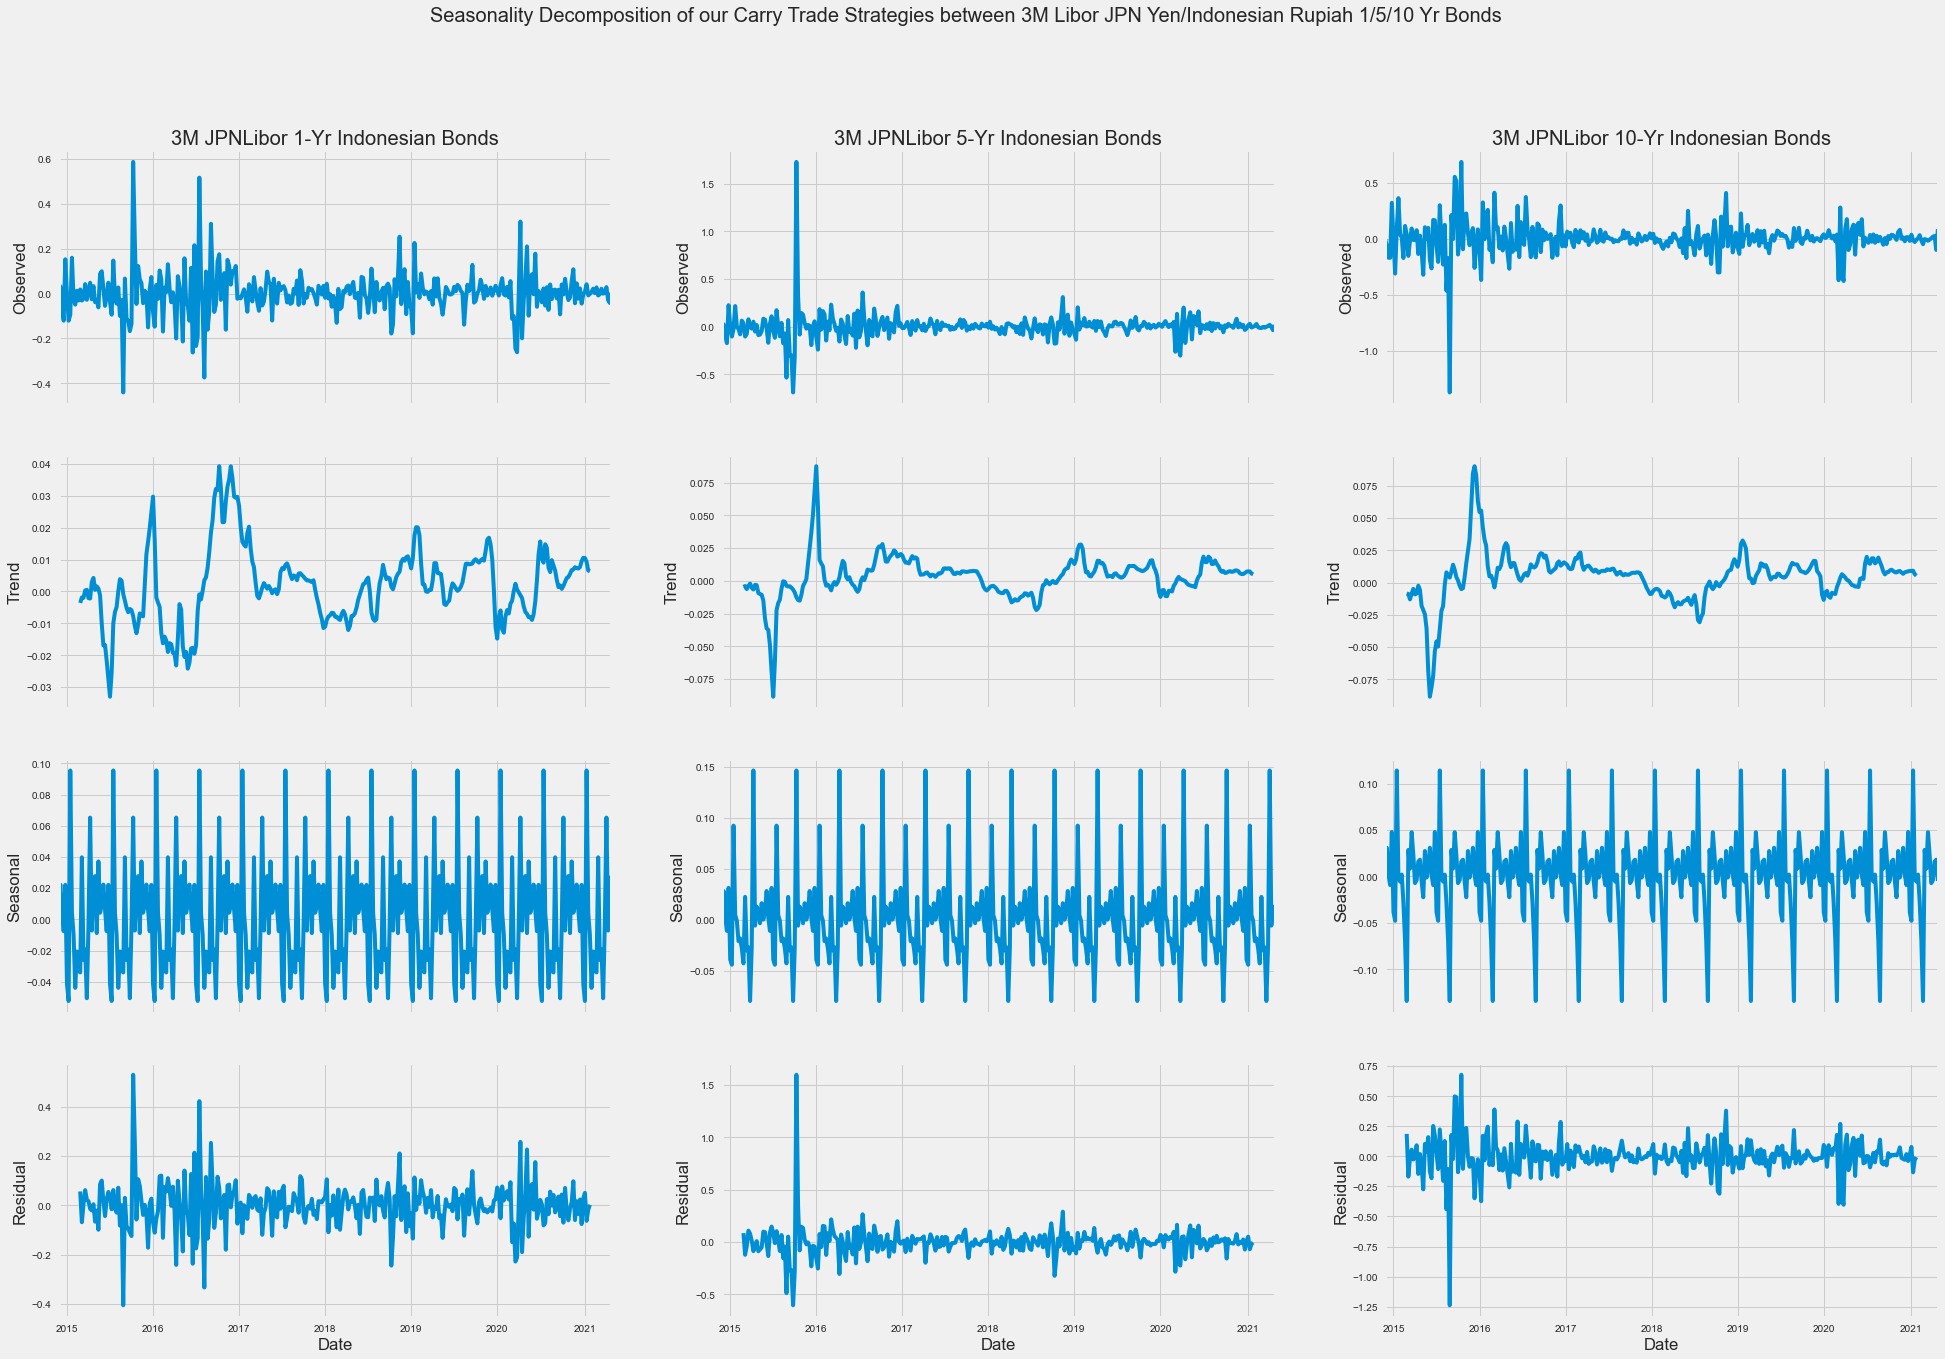

In [132]:
plot_seasonality(dfs_port_ind, col_names, 'Seasonality Decomposition of our Carry Trade Strategies between 3M Libor JPN Yen/Indonesian Rupiah 1/5/10 Yr Bonds', per = 26)

TThe residuals do seems to be more hectic around 2016 for the bonds and no apparent seasonal.

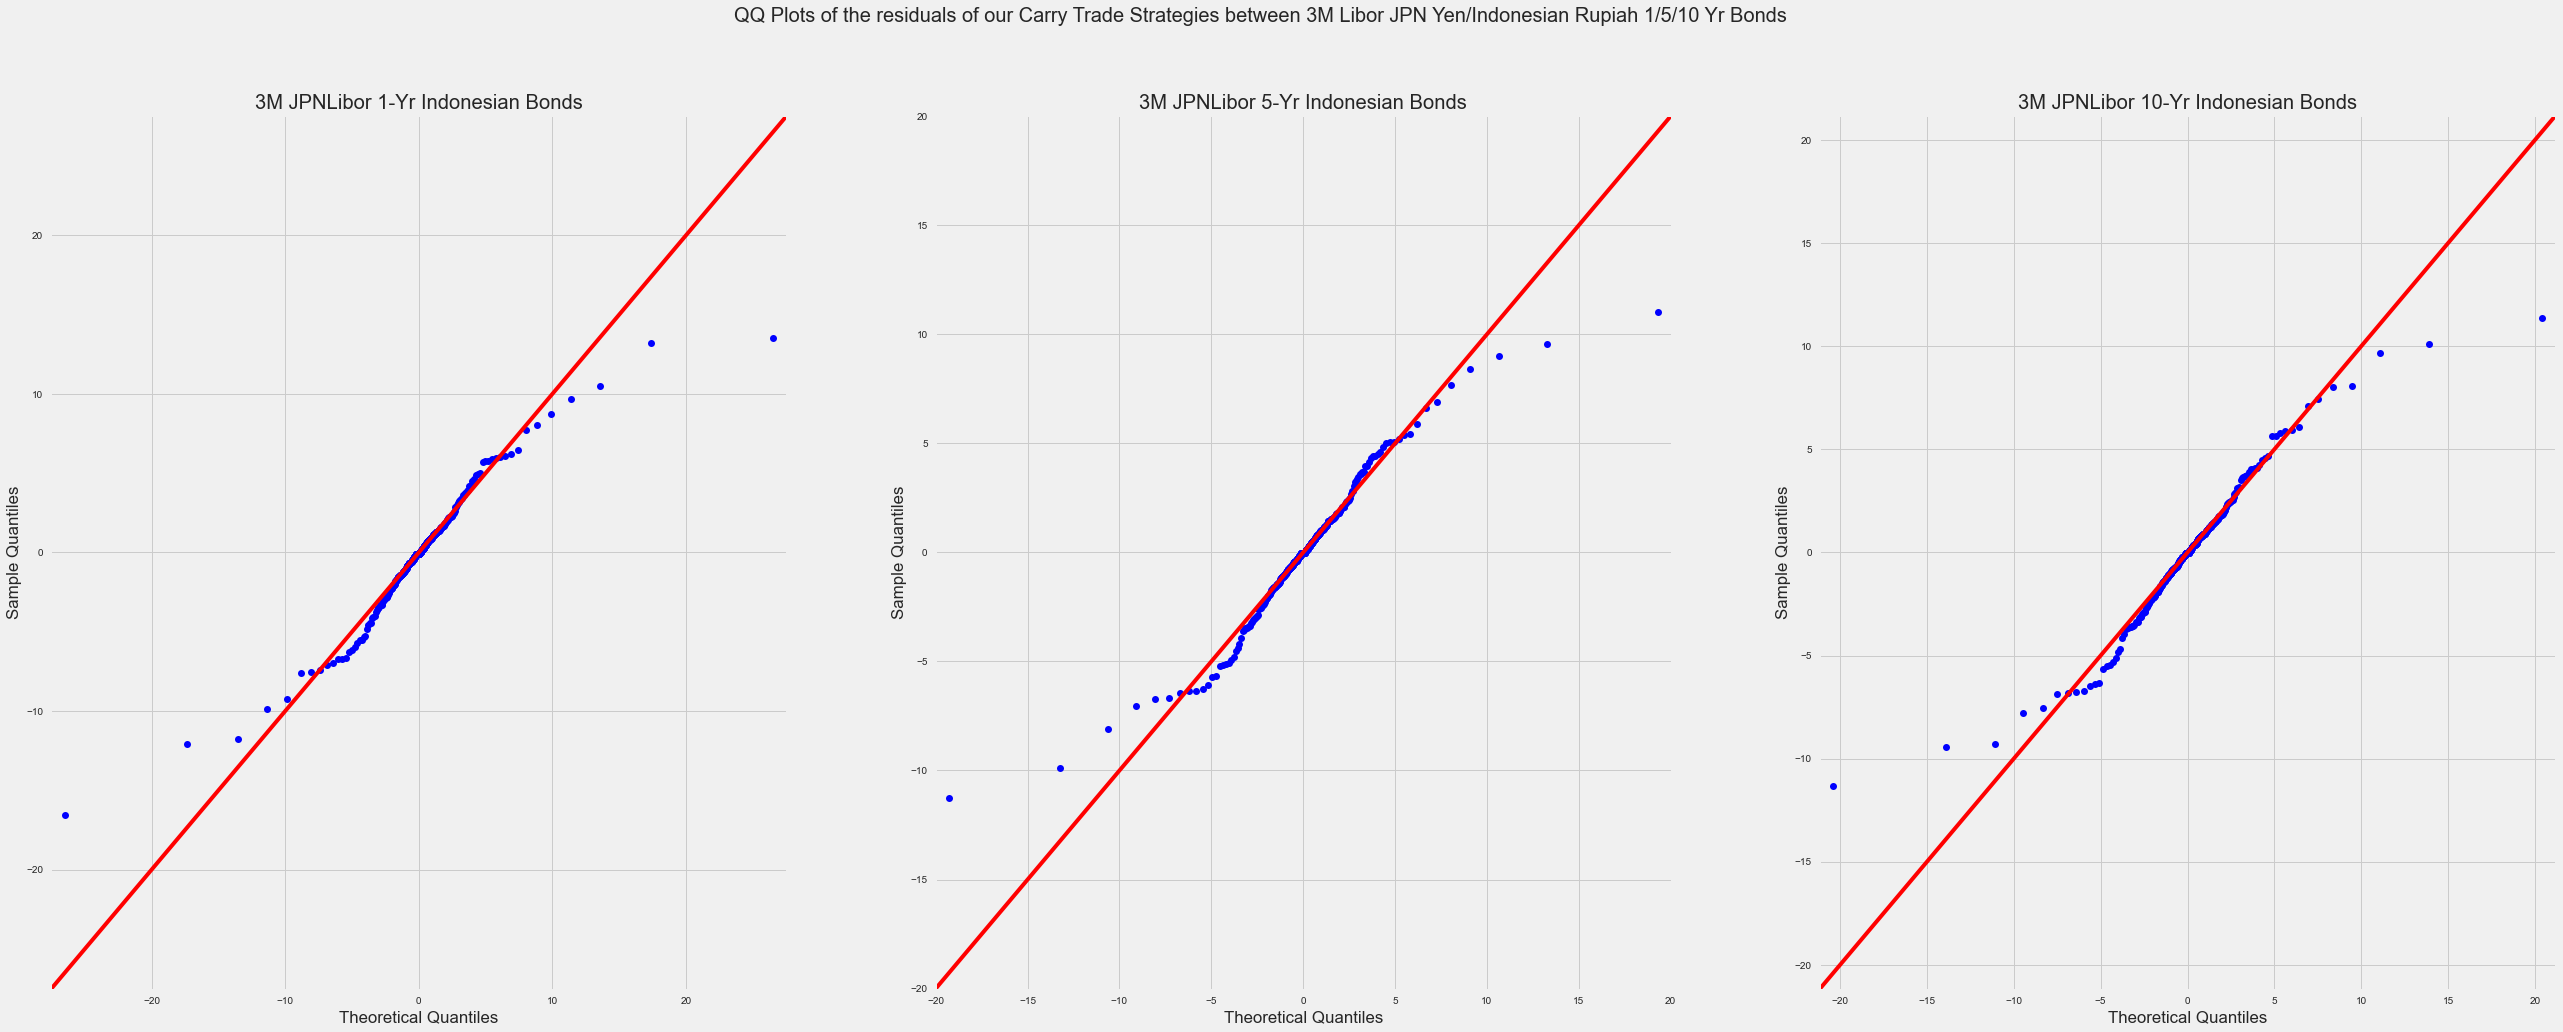

In [86]:
qq_plots(dfs_port_rou,col_names,'QQ Plots of the residuals of our Carry Trade Strategies between 3M Libor JPN Yen/Indonesian Rupiah 1/5/10 Yr Bonds', 26)

Not too surprising considering the high kurtosis of our returns.

## 4.7 Farma-French Regression

In [87]:
ff_dfs = ff_regression(dfs_port_ind, col_names,"Log_Returns")
ff_dfs[0]

3M JPNLibor 1-Yr Indonesian Bonds  3M JPNLibor 5-Yr Indonesian Bonds  \
Factors                                                                         
Mkt-RF                              0.0451                            -0.0649   
SMB                                 0.0997                             0.0452   
HML                                 0.0396                             0.0278   
RF                                 -0.0134                            -0.0108   
Ret                                 1.0000                             1.0000   
Mkt                                 0.0450                            -0.0649   

         3M JPNLibor 10-Yr Indonesian Bonds  
Factors                                      
Mkt-RF                              -0.0649  
SMB                                  0.0431  
HML                                  0.0220  
RF                                  -0.0230  
Ret                                  1.0000  
Mkt                                 -0.0650

Like the Carry Trade with the Thai bonds and FX or with Roumanian Leu, our strategy shows very little correlation with Farma-French Factors, let's visualize it.

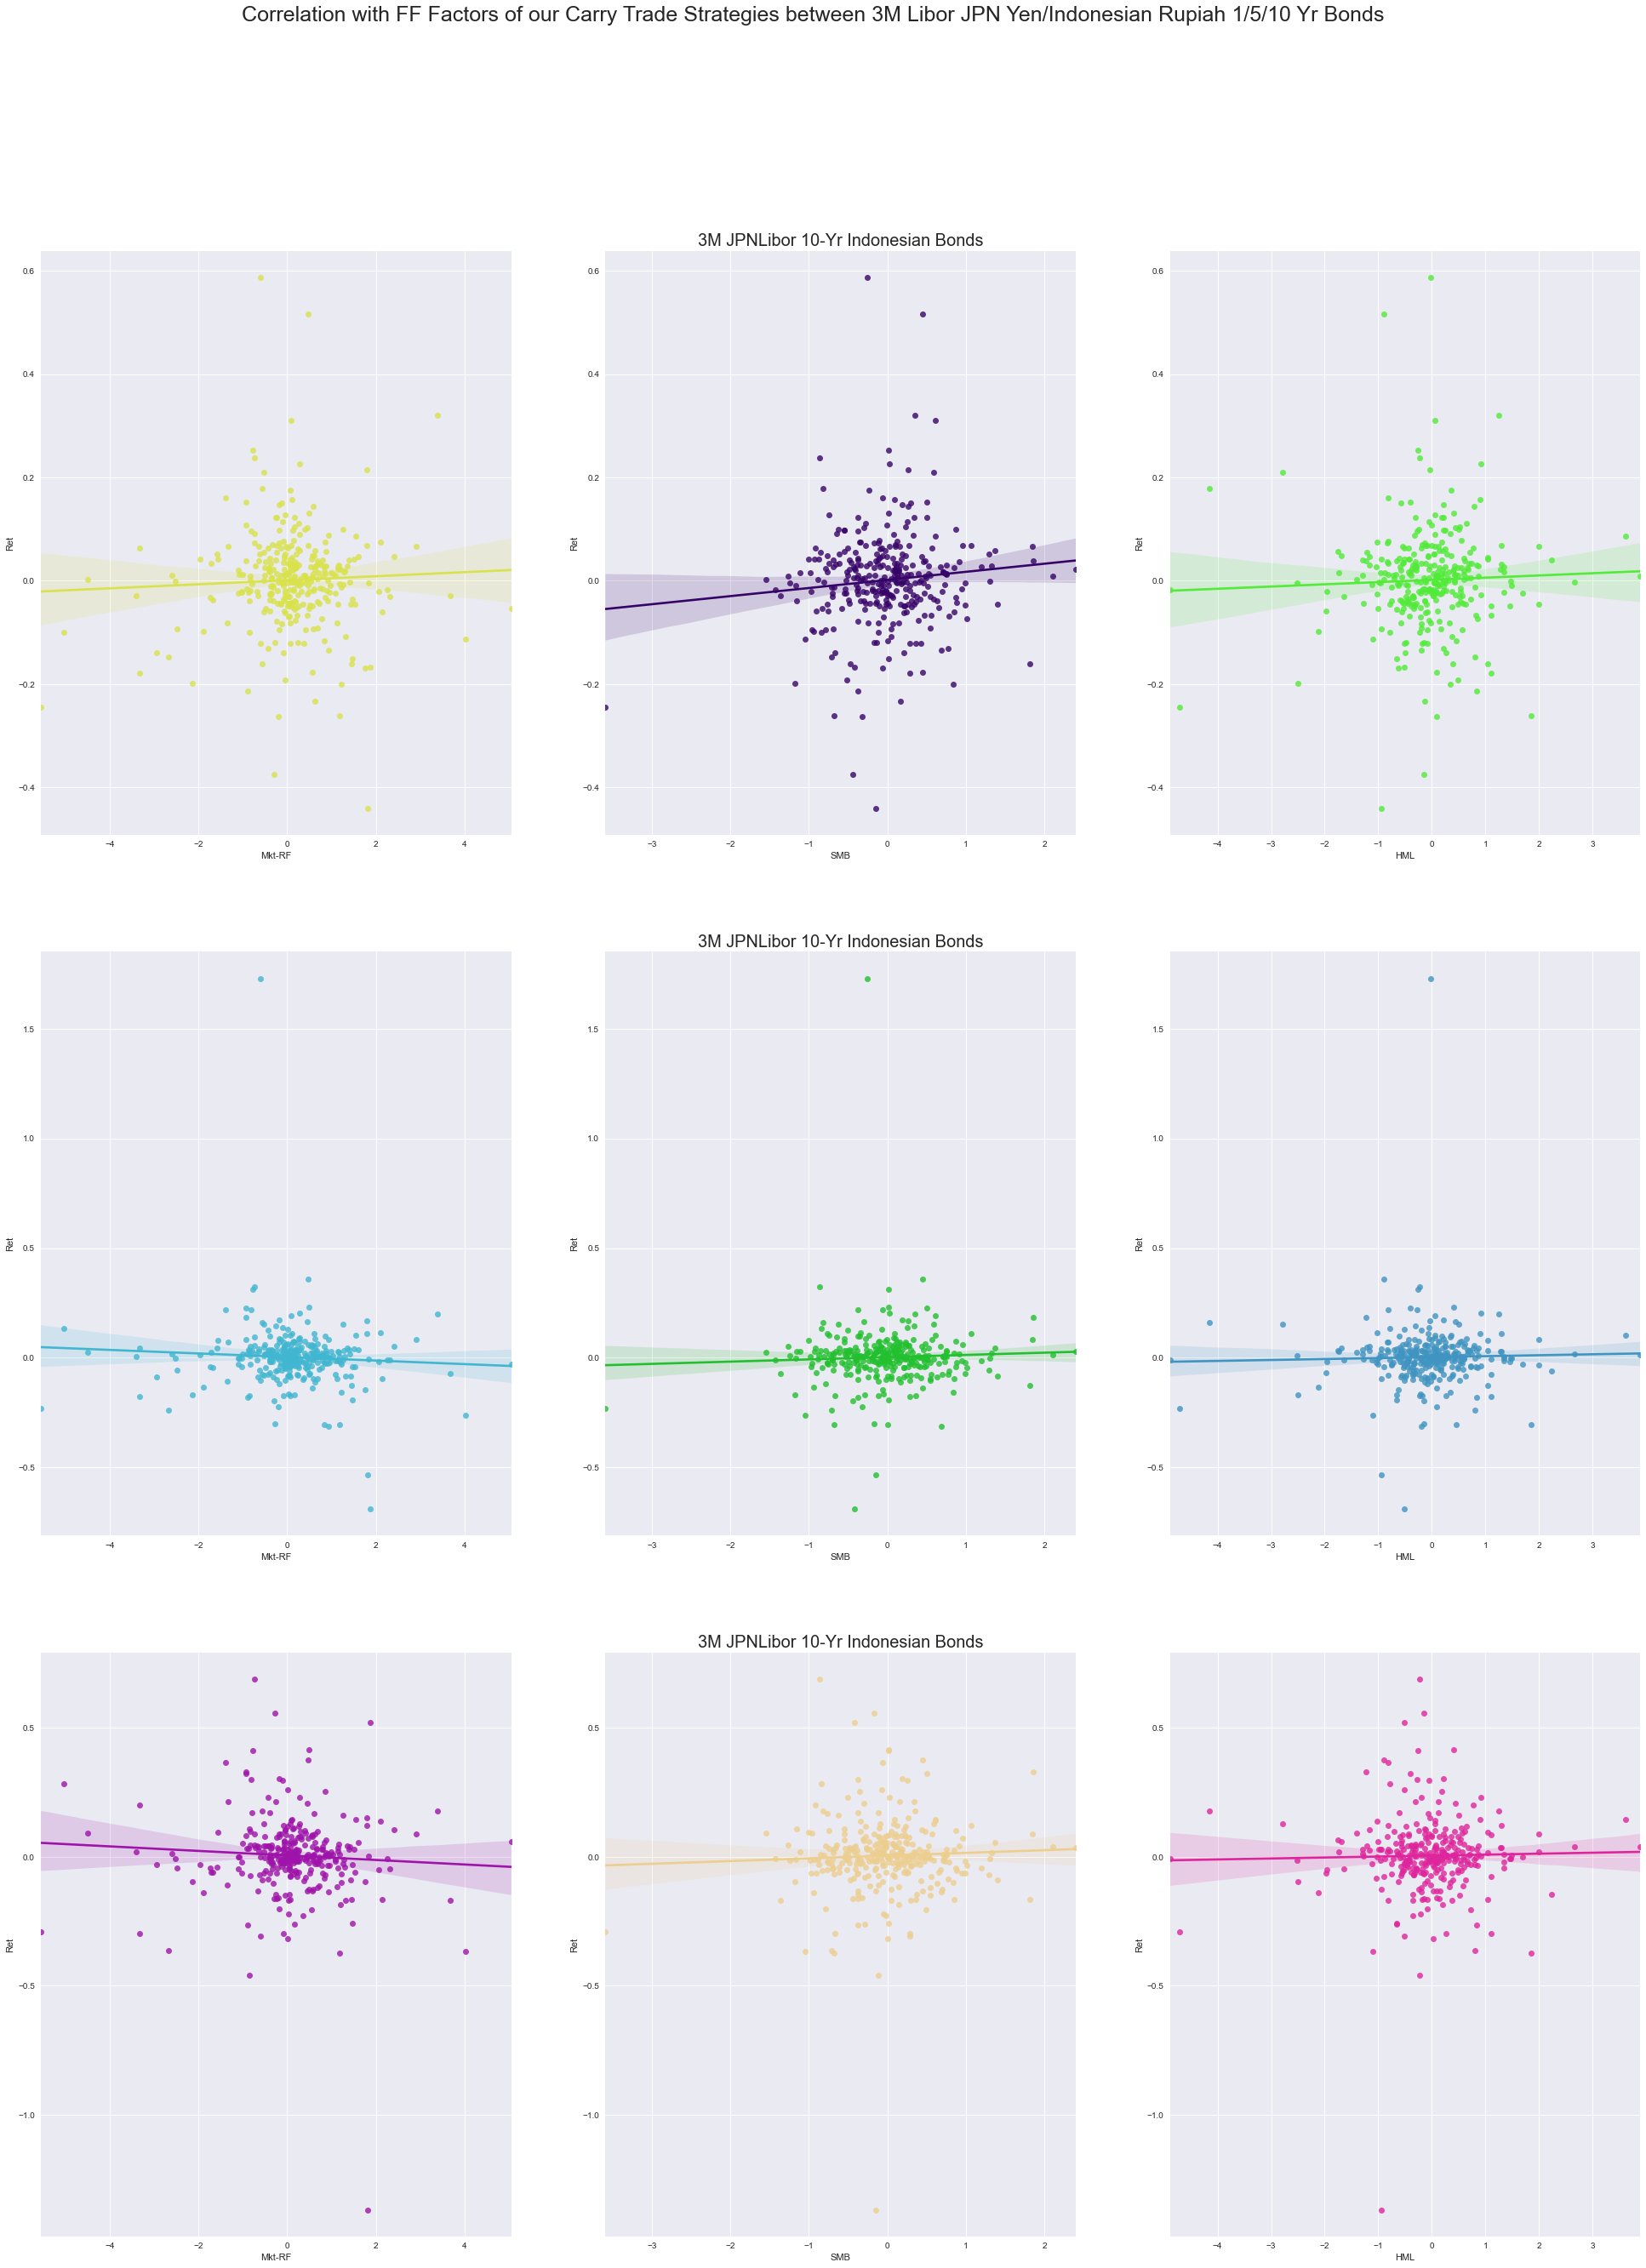

In [88]:
ff_plot(ff_dfs[1], col_names, 'Correlation with FF Factors of our Carry Trade Strategies between 3M Libor JPN Yen/Indonesian Rupiah 1/5/10 Yr Bonds')

In [89]:
ff_metrics = ff_portfolio_metrics(dfs_port_ind, col_names,"Log_Returns")
ff_metrics[0]

3M JPNLibor 1-Yr Indonesian Bonds  \
Metrics                                            
Sharpe_Ratio                              0.1049   
Sortino_Ratio                             0.3346   
Treynor_Ratio                             1.6442   

               3M JPNLibor 5-Yr Indonesian Bonds  \
Metrics                                            
Sharpe_Ratio                              0.1403   
Sortino_Ratio                             0.5889   
Treynor_Ratio                            -2.1952   

               3M JPNLibor 10-Yr Indonesian Bonds  
Metrics                                            
Sharpe_Ratio                               0.2064  
Sortino_Ratio                              0.7434  
Treynor_Ratio                             -3.4987

In [90]:
ff_metrics[1]

Downside Beta Regression 3M JPNLibor 1-Yr Indonesian Bonds  \
const                                               0.0200            
Mkt-RF                                              2.3164            
R${^2}$                                             0.0459            

         Downside Beta Regression 3M JPNLibor 5-Yr Indonesian Bonds  \
const                                               0.0292            
Mkt-RF                                              1.5254            
R${^2}$                                             0.0070            

         Downside Beta Regression 3M JPNLibor 10-Yr Indonesian Bonds  
const                                               0.0274            
Mkt-RF                                              1.1710            
R${^2}$                                             0.0055

The Ratios are better than they were in the Thai section but not as good as Roumanien. The Sharpe and Sortino Ratio do seem pretty low and the Treynor Ratio doesn't say much given that the beta of our strategy to the market is very small.

## 4.8 Additional Analysis

We'd expect a wildly different behavior for the leverage over-time for this strategy, mostl likely be wilder than the previous section but not as quite as the Thai one. 

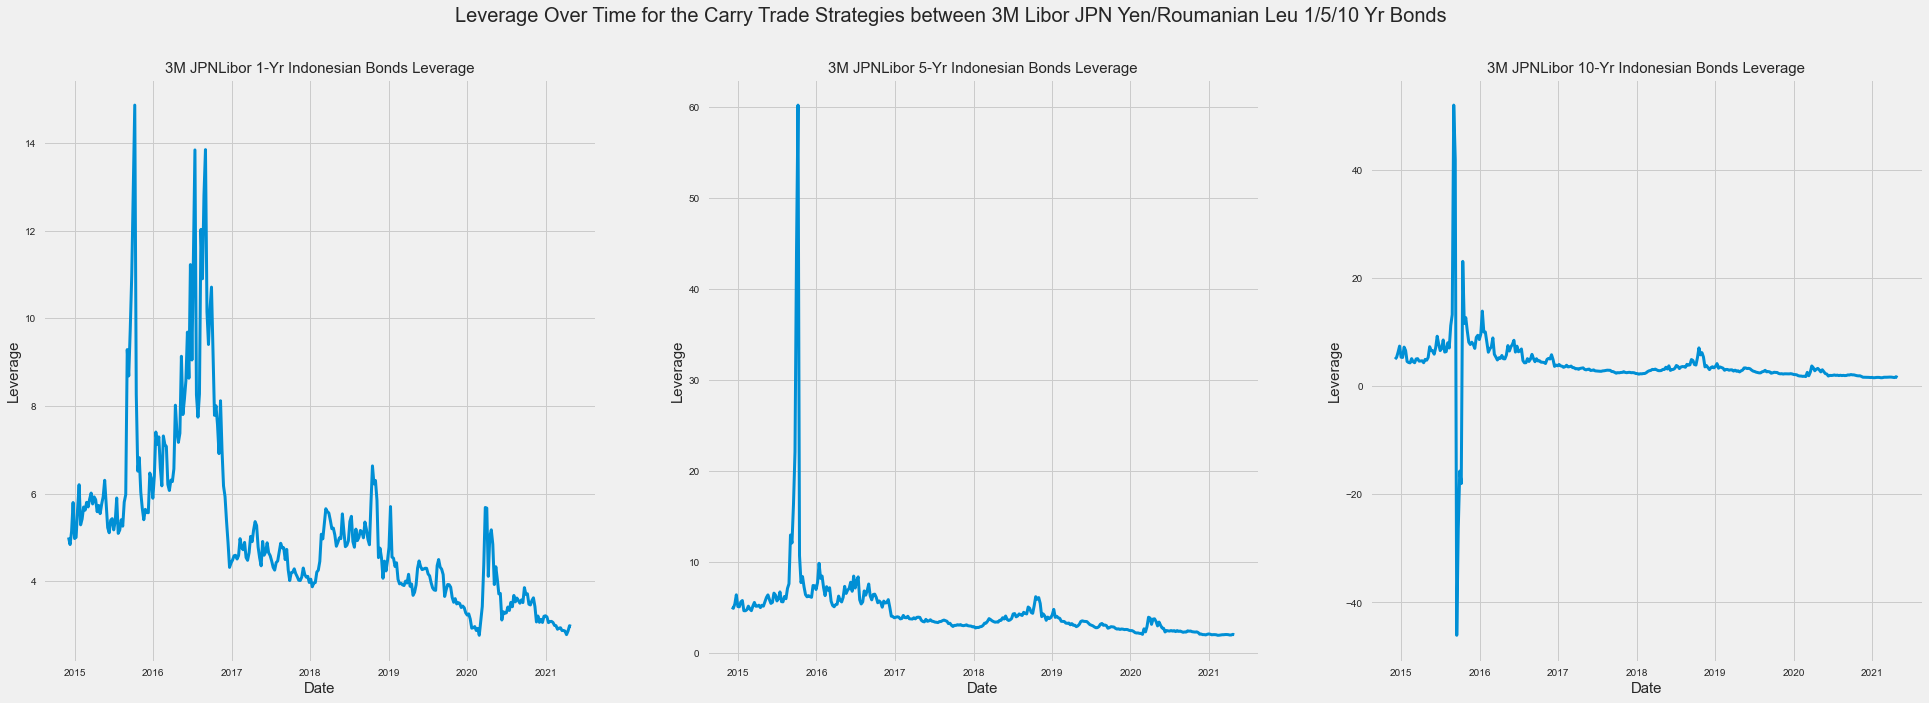

In [133]:
leverage_plots(dfs_port_ind, col_names, 'Leverage Over Time for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds')

The leverage near the end seems to be converging less than our initial leverage because we end up have a positive PnL but when in 2015 our accounts get nearly or totally blown out, the leverage spikes.

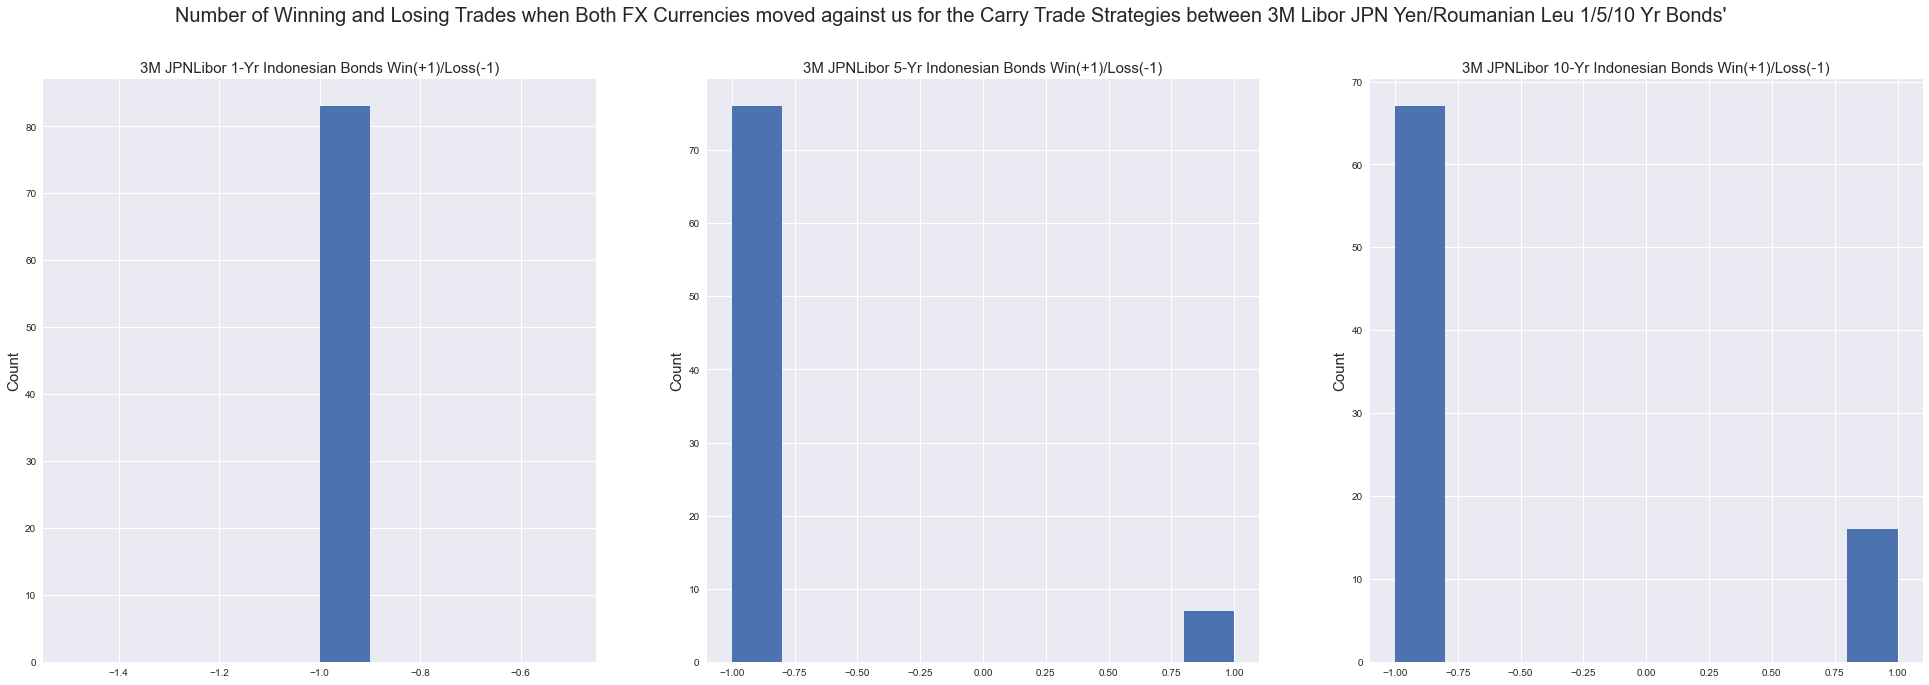

In [135]:
win_lost_vs_FX(dfs_port_ind, col_names, "Number of Winning and Losing Trades when Both FX Currencies moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian Leu 1/5/10 Yr Bonds'")

More like the Thai strategy, we observe very few winnable trades when the currencies goes against us.

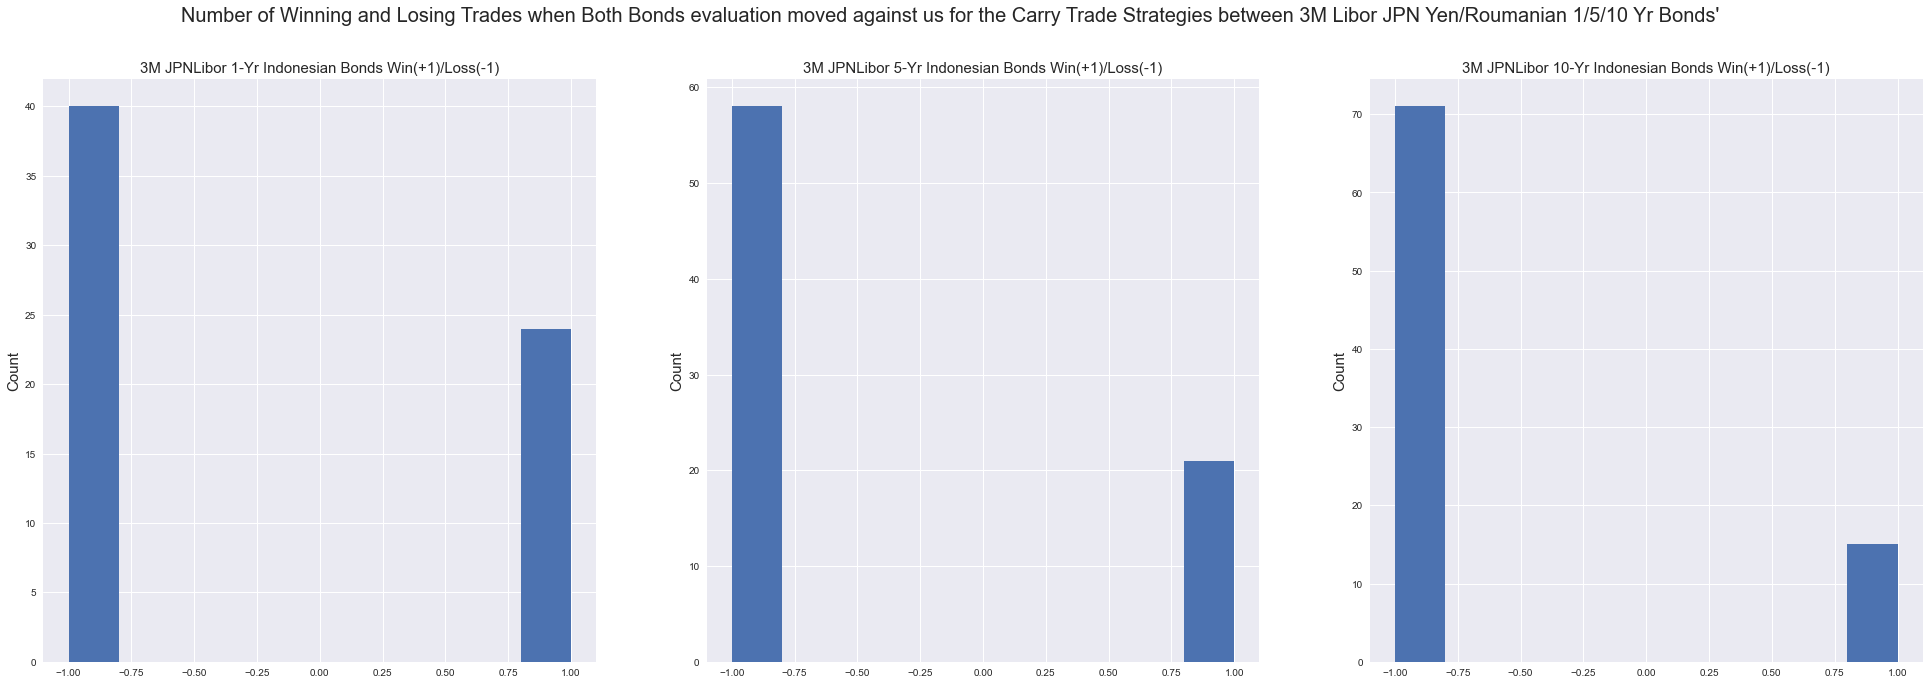

In [93]:
win_lost_vs_bonds(dfs_port_ind, col_names, "Number of Winning and Losing Trades when Both Bonds evaluation moved against us for the Carry Trade Strategies between 3M Libor JPN Yen/Roumanian 1/5/10 Yr Bonds'")

A bit more winnable trades when the bonds goes against us, again showing bigger weight of the change in FX over the short-term for winnable trades. The change in bond price in a week tends to be dominated by the change in FX in the week.

# 5. Additional Notes

From analysis different Carry Trade Strategies involving lending bonds of different maturities (1y/5Yr/10Yr) for three different currencies (Thai-Baht/Romanian-Leu/Indonesian-Rupiah) by borrowing 3M Libor-rate Japanese Bonds in Yen. The result is 9 different strategies over 3 currencies with 3 different maturity bonds. I made this choice in order to be able to compare between the currencies and try to have a better overall sense of the dynamics and sensitivities to the strategy PnL.

There are some similarities such as the strategies seems to describe high kurtosis, no periodic seasonality, fat-tailed residuals, binodal distributions of the bond prices, no correlations to the Farma-French factors, not interesting Financial Metric Ratios such as (Sharpe/Sortino/Treynor's), no real autocorrelation significant enough. Each of the strategy seemed to be more dependent on short-term movement in the FX Rate over short-term movement in the evaluation of the bonds. The leverages vary a lot and in certain cases even get's blown out from our accumulated PnL losing more than our starting capital. 

Except for the Romanian Leu, the maximum drawdowns are quite scary, and any investors would be worried about the level of potential lost. This leads us that if I had to choose one currency to do our carry trade based on what I have analyzed, it would be the Romanian Leu. It is important to note that all of our gains was done in a big ramp up from 2012 to the middle of 2014 which may be problematic in the future. We have no indication that this event would repeat itself and it looks more like an outlier. Removing the outlier really doesn't show much in terms of performance so it is very possible that heading into the future this strategy PnL would be flat. 

In that case, it may look like the Indonesian Rupiah is more interesting but the amount of drawdown in the PnL and high kurtosis is worrying and in one of the case the account got blown out so we don't have something we could easily sell to a potential investor. We really see the risk of running carry-trade strategies where the account is at risk of potential blow-out when things goes against us quick.
